In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

C:\Users\MA20018398\AppData\Local\conda\conda\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_excel("Primary_data_tomod.xlsx")

In [3]:
master = data['master']

In [4]:
seq = master.copy()

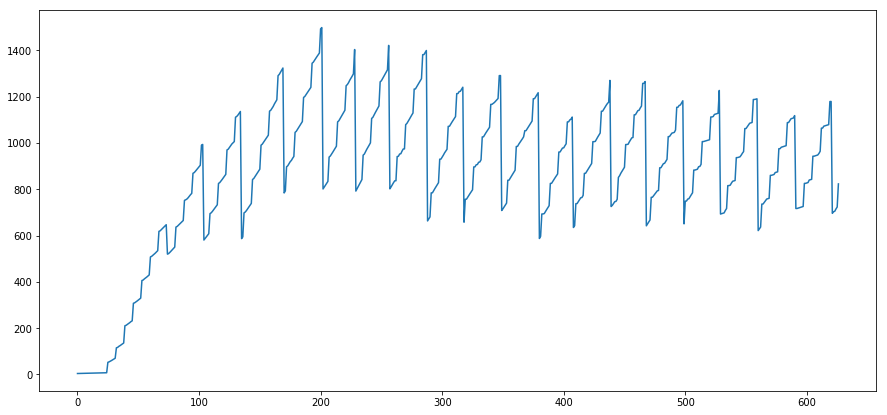

In [5]:
plt.figure(figsize=(15,7))
plt.plot(seq)

In [6]:
plt.figure(figsize=(15,7))
plt.plot(seq[70:])

In [7]:
seq = seq[70:].reset_index(drop = True)

In [8]:
X = seq.values.reshape(-1,1)
Y = seq.values.reshape(-1,1)

In [9]:
scaler = MinMaxScaler()
X =scaler.fit_transform(X)
Y =scaler.fit_transform(Y)

In [10]:
x_train = X[:-50]
y_train = Y[:-50]

In [11]:
x_test = X[-50:]
y_test = Y[-50:]

In [12]:
input_seq_len = 30 
output_seq_len = 15
n_in_features = 1
n_out_features = 1
#layers = [40]
teacher_forcing = False
#n_layers = len(layers)

In [13]:
#def generate_train_batches(x, y, batch_size, input_seq_len, output_seq_len, n_in_features, n_out_features):

def generate_train_batches(x, y, batch_size):
    
    total_start_points = len(x) - input_seq_len - output_seq_len

    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)
    
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

In [14]:
'''
def create_model(layers,n_layers):

    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    encoder = RNN(lstm_cells, return_state=True)
    encoder_outputs_and_states = encoder(encoder_inputs)

    encoder_states = encoder_outputs_and_states[1:]

    decoder_inputs = Input(shape=(None, n_out_features))
    decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model
    
'''

'\ndef create_model(layers,n_layers):\n\n    encoder_inputs = Input(shape=(None, n_in_features))\n    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]\n    encoder = RNN(lstm_cells, return_state=True)\n    encoder_outputs_and_states = encoder(encoder_inputs)\n\n    encoder_states = encoder_outputs_and_states[1:]\n\n    decoder_inputs = Input(shape=(None, n_out_features))\n    decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]\n    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)\n\n    decoder_outputs_and_states = decoder_lstm(decoder_inputs,\n                                          initial_state=encoder_states)\n    decoder_outputs = decoder_outputs_and_states[0]\n\n    decoder_dense = Dense(n_out_features) \n    decoder_outputs = decoder_dense(decoder_outputs)\n\n    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)\n    return model\n    \n'

In [15]:
def create_model(layers,n_layers, bidirectional=False):

    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [213]:
def run_model(model,epochs,steps_per_epoch,batch_size):

    for _ in range(epochs):

        input_seq, output_seq = generate_train_batches(x_train, y_train,batch_size)

        encoder_input_data = input_seq
        decoder_target_data = output_seq

        if teacher_forcing:
            decoder_input_data = np.zeros(decoder_target_data.shape)
            decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
            decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

        else:
            decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=steps_per_epoch,
                             validation_split=0.2
                           )

        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [128]:
model_1 = create_model([40],1)

In [129]:
total_loss = []
total_val_loss = []
model_1.compile(Adam(), loss = 'mse')

In [130]:
#less batch_size model
start_time = time.time()
run_model(model_1,100,64)
end_time = time.time()

Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 6s 115ms/step - loss: 0.2684 - val_loss: 0.2431
Epoch 2/100
51/51 [==============================] - 0s 845us/step - loss: 0.2568 - val_loss: 0.2329
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.2455 - val_loss: 0.2228
Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 0.2343 - val_loss: 0.2127
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2232 - val_loss: 0.2025
Epoch 6/100
51/51 [==============================] - 0s 1ms/step - loss: 0.2120 - val_loss: 0.1922
Epoch 7/100
51/51 [==============================] - 0s 747us/step - loss: 0.2007 - val_loss: 0.1817
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.1892 - val_loss: 0.1709
Epoch 9/100
51/51 [==============================] - 0s 1ms/step - loss: 0.1773 - val_loss: 0.1596
Epoch 10/100
51/51 [==============================] - 0s 74

Epoch 82/100
51/51 [==============================] - 0s 767us/step - loss: 0.0374 - val_loss: 0.0342
Epoch 83/100
51/51 [==============================] - 0s 727us/step - loss: 0.0373 - val_loss: 0.0341
Epoch 84/100
51/51 [==============================] - 0s 845us/step - loss: 0.0373 - val_loss: 0.0341
Epoch 85/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0340
Epoch 86/100
51/51 [==============================] - 0s 944us/step - loss: 0.0373 - val_loss: 0.0340
Epoch 87/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0340
Epoch 88/100
51/51 [==============================] - 0s 885us/step - loss: 0.0372 - val_loss: 0.0340
Epoch 89/100
51/51 [==============================] - 0s 963us/step - loss: 0.0372 - val_loss: 0.0340
Epoch 90/100
51/51 [==============================] - 0s 786us/step - loss: 0.0372 - val_loss: 0.0340
Epoch 91/100
51/51 [==============================] - 0s 767us/step - loss: 0.0372 - v

Epoch 63/100
51/51 [==============================] - 0s 904us/step - loss: 0.0309 - val_loss: 0.0366
Epoch 64/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0366
Epoch 65/100
51/51 [==============================] - 0s 668us/step - loss: 0.0308 - val_loss: 0.0366
Epoch 66/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0366
Epoch 67/100
51/51 [==============================] - 0s 767us/step - loss: 0.0308 - val_loss: 0.0366
Epoch 68/100
51/51 [==============================] - 0s 708us/step - loss: 0.0308 - val_loss: 0.0366
Epoch 69/100
51/51 [==============================] - 0s 904us/step - loss: 0.0308 - val_loss: 0.0366
Epoch 70/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0366
Epoch 71/100
51/51 [==============================] - 0s 963us/step - loss: 0.0308 - val_loss: 0.0366
Epoch 72/100
51/51 [==============================] - 0s 609us/step - loss: 0.0308 - val

Epoch 44/100
51/51 [==============================] - 0s 904us/step - loss: 0.0352 - val_loss: 0.0303
Epoch 45/100
51/51 [==============================] - 0s 688us/step - loss: 0.0348 - val_loss: 0.0301
Epoch 46/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0299
Epoch 47/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0296
Epoch 48/100
51/51 [==============================] - 0s 609us/step - loss: 0.0334 - val_loss: 0.0292
Epoch 49/100
51/51 [==============================] - 0s 944us/step - loss: 0.0329 - val_loss: 0.0289
Epoch 50/100
51/51 [==============================] - 0s 767us/step - loss: 0.0323 - val_loss: 0.0285
Epoch 51/100
51/51 [==============================] - 0s 983us/step - loss: 0.0317 - val_loss: 0.0281
Epoch 52/100
51/51 [==============================] - 0s 983us/step - loss: 0.0311 - val_loss: 0.0278
Epoch 53/100
51/51 [==============================] - 0s 649us/step - loss: 0.0305 - v

Epoch 25/100
51/51 [==============================] - 0s 983us/step - loss: 0.0179 - val_loss: 0.0179
Epoch 26/100
51/51 [==============================] - 0s 747us/step - loss: 0.0178 - val_loss: 0.0179
Epoch 27/100
51/51 [==============================] - 0s 708us/step - loss: 0.0177 - val_loss: 0.0180
Epoch 28/100
51/51 [==============================] - 0s 845us/step - loss: 0.0175 - val_loss: 0.0181
Epoch 29/100
51/51 [==============================] - 0s 845us/step - loss: 0.0174 - val_loss: 0.0183
Epoch 30/100
51/51 [==============================] - 0s 865us/step - loss: 0.0174 - val_loss: 0.0180
Epoch 31/100
51/51 [==============================] - 0s 767us/step - loss: 0.0173 - val_loss: 0.0183
Epoch 32/100
51/51 [==============================] - 0s 727us/step - loss: 0.0172 - val_loss: 0.0178
Epoch 33/100
51/51 [==============================] - 0s 786us/step - loss: 0.0172 - val_loss: 0.0190
Epoch 34/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0172 -

Epoch 6/100
51/51 [==============================] - 0s 826us/step - loss: 0.0175 - val_loss: 0.0156
Epoch 7/100
51/51 [==============================] - 0s 806us/step - loss: 0.0174 - val_loss: 0.0153
Epoch 8/100
51/51 [==============================] - 0s 688us/step - loss: 0.0174 - val_loss: 0.0157
Epoch 9/100
51/51 [==============================] - 0s 845us/step - loss: 0.0172 - val_loss: 0.0167
Epoch 10/100
51/51 [==============================] - 0s 983us/step - loss: 0.0169 - val_loss: 0.0182
Epoch 11/100
51/51 [==============================] - 0s 904us/step - loss: 0.0169 - val_loss: 0.0192
Epoch 12/100
51/51 [==============================] - 0s 747us/step - loss: 0.0170 - val_loss: 0.0191
Epoch 13/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0169 - val_loss: 0.0180
Epoch 14/100
51/51 [==============================] - 0s 708us/step - loss: 0.0168 - val_loss: 0.0170
Epoch 15/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0168 - val_l

Epoch 87/100
51/51 [==============================] - 0s 865us/step - loss: 0.0145 - val_loss: 0.0170
Epoch 88/100
51/51 [==============================] - 0s 668us/step - loss: 0.0145 - val_loss: 0.0169
Epoch 89/100
51/51 [==============================] - 0s 649us/step - loss: 0.0145 - val_loss: 0.0171
Epoch 90/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0145 - val_loss: 0.0168
Epoch 91/100
51/51 [==============================] - 0s 865us/step - loss: 0.0144 - val_loss: 0.0170
Epoch 92/100
51/51 [==============================] - 0s 944us/step - loss: 0.0144 - val_loss: 0.0168
Epoch 93/100
51/51 [==============================] - 0s 767us/step - loss: 0.0143 - val_loss: 0.0168
Epoch 94/100
51/51 [==============================] - 0s 747us/step - loss: 0.0143 - val_loss: 0.0169
Epoch 95/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0167
Epoch 96/100
51/51 [==============================] - 0s 845us/step - loss: 0.0142 - v

Epoch 68/100
51/51 [==============================] - 0s 786us/step - loss: 0.0120 - val_loss: 0.0280
Epoch 69/100
51/51 [==============================] - 0s 885us/step - loss: 0.0120 - val_loss: 0.0281
Epoch 70/100
51/51 [==============================] - 0s 688us/step - loss: 0.0120 - val_loss: 0.0282
Epoch 71/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0280
Epoch 72/100
51/51 [==============================] - 0s 747us/step - loss: 0.0120 - val_loss: 0.0280
Epoch 73/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0282
Epoch 74/100
51/51 [==============================] - 0s 767us/step - loss: 0.0119 - val_loss: 0.0280
Epoch 75/100
51/51 [==============================] - 0s 629us/step - loss: 0.0119 - val_loss: 0.0281
Epoch 76/100
51/51 [==============================] - 0s 826us/step - loss: 0.0119 - val_loss: 0.0282
Epoch 77/100
51/51 [==============================] - 0s 786us/step - loss: 0.0119 - v

Epoch 49/100
51/51 [==============================] - 0s 629us/step - loss: 0.0146 - val_loss: 0.0189
Epoch 50/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0145 - val_loss: 0.0188
Epoch 51/100
51/51 [==============================] - 0s 845us/step - loss: 0.0145 - val_loss: 0.0187
Epoch 52/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 0.0188
Epoch 53/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 0.0188
Epoch 54/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0188
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.0187
Epoch 56/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0188
Epoch 57/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0191
Epoch 58/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.0

Epoch 30/100
51/51 [==============================] - 0s 649us/step - loss: 0.0176 - val_loss: 0.0173
Epoch 31/100
51/51 [==============================] - 0s 904us/step - loss: 0.0174 - val_loss: 0.0172
Epoch 32/100
51/51 [==============================] - 0s 826us/step - loss: 0.0174 - val_loss: 0.0172
Epoch 33/100
51/51 [==============================] - 0s 727us/step - loss: 0.0173 - val_loss: 0.0175
Epoch 34/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0172 - val_loss: 0.0175
Epoch 35/100
51/51 [==============================] - 0s 747us/step - loss: 0.0172 - val_loss: 0.0167
Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.0162
Epoch 37/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0171 - val_loss: 0.0163
Epoch 38/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 39/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0169 - val_los

Epoch 11/100
51/51 [==============================] - 0s 963us/step - loss: 0.0174 - val_loss: 0.0173
Epoch 12/100
51/51 [==============================] - 0s 963us/step - loss: 0.0163 - val_loss: 0.0154
Epoch 13/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0150 - val_loss: 0.0169
Epoch 14/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0165 - val_loss: 0.0178
Epoch 15/100
51/51 [==============================] - 0s 924us/step - loss: 0.0164 - val_loss: 0.0164
Epoch 16/100
51/51 [==============================] - 0s 688us/step - loss: 0.0145 - val_loss: 0.0166
Epoch 17/100
51/51 [==============================] - 0s 904us/step - loss: 0.0151 - val_loss: 0.0171
Epoch 18/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 19/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 20/100
51/51 [==============================] - 0s 944us/step - loss: 0.0141 - val_l

Epoch 92/100
51/51 [==============================] - 0s 727us/step - loss: 0.0110 - val_loss: 0.0163
Epoch 93/100
51/51 [==============================] - 0s 944us/step - loss: 0.0110 - val_loss: 0.0163
Epoch 94/100
51/51 [==============================] - 0s 767us/step - loss: 0.0110 - val_loss: 0.0163
Epoch 95/100
51/51 [==============================] - 0s 885us/step - loss: 0.0110 - val_loss: 0.0163
Epoch 96/100
51/51 [==============================] - 0s 904us/step - loss: 0.0110 - val_loss: 0.0163
Epoch 97/100
51/51 [==============================] - 0s 806us/step - loss: 0.0109 - val_loss: 0.0163
Epoch 98/100
51/51 [==============================] - 0s 767us/step - loss: 0.0109 - val_loss: 0.0163
Epoch 99/100
51/51 [==============================] - 0s 747us/step - loss: 0.0109 - val_loss: 0.0164
Epoch 100/100
51/51 [==============================] - 0s 727us/step - loss: 0.0109 - val_loss: 0.0164
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==================

Epoch 73/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0175
Epoch 74/100
51/51 [==============================] - 0s 924us/step - loss: 0.0119 - val_loss: 0.0175
Epoch 75/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0175
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0176
Epoch 77/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0175
Epoch 78/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0175
Epoch 79/100
51/51 [==============================] - 0s 767us/step - loss: 0.0118 - val_loss: 0.0175
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0175
Epoch 81/100
51/51 [==============================] - 0s 964us/step - loss: 0.0117 - val_loss: 0.0175
Epoch 82/100
51/51 [==============================] - 0s 944us/step - loss: 0.0117 - val_loss:

Epoch 54/100
51/51 [==============================] - 0s 924us/step - loss: 0.0107 - val_loss: 0.0148
Epoch 55/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0149
Epoch 56/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0147
Epoch 57/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 58/100
51/51 [==============================] - 0s 865us/step - loss: 0.0106 - val_loss: 0.0148
Epoch 59/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 60/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0149
Epoch 61/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0150
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0148
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0

51/51 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0160
Epoch 36/100
51/51 [==============================] - 0s 944us/step - loss: 0.0124 - val_loss: 0.0155
Epoch 37/100
51/51 [==============================] - 0s 983us/step - loss: 0.0123 - val_loss: 0.0153
Epoch 38/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0158
Epoch 39/100
51/51 [==============================] - 0s 786us/step - loss: 0.0122 - val_loss: 0.0161
Epoch 40/100
51/51 [==============================] - 0s 944us/step - loss: 0.0121 - val_loss: 0.0156
Epoch 41/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0150
Epoch 42/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 43/100
51/51 [==============================] - 0s 924us/step - loss: 0.0120 - val_loss: 0.0157
Epoch 44/100
51/51 [==============================] - 0s 963us/step - loss: 0.0119 - val_loss: 0.0162
E

Epoch 16/100
51/51 [==============================] - 0s 727us/step - loss: 0.0116 - val_loss: 0.0192
Epoch 17/100
51/51 [==============================] - 0s 550us/step - loss: 0.0118 - val_loss: 0.0197
Epoch 18/100
51/51 [==============================] - 0s 904us/step - loss: 0.0118 - val_loss: 0.0196
Epoch 19/100
51/51 [==============================] - 0s 609us/step - loss: 0.0114 - val_loss: 0.0194
Epoch 20/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0194
Epoch 21/100
51/51 [==============================] - 0s 708us/step - loss: 0.0112 - val_loss: 0.0191
Epoch 22/100
51/51 [==============================] - 0s 708us/step - loss: 0.0113 - val_loss: 0.0189
Epoch 23/100
51/51 [==============================] - 0s 668us/step - loss: 0.0113 - val_loss: 0.0189
Epoch 24/100
51/51 [==============================] - 0s 708us/step - loss: 0.0111 - val_loss: 0.0192
Epoch 25/100
51/51 [==============================] - 0s 649us/step - loss: 0.0110 -

Epoch 97/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0174
Epoch 98/100
51/51 [==============================] - 0s 865us/step - loss: 0.0094 - val_loss: 0.0174
Epoch 99/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0174
Epoch 100/100
51/51 [==============================] - 0s 786us/step - loss: 0.0093 - val_loss: 0.0174
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0185
Epoch 2/100
51/51 [==============================] - 0s 786us/step - loss: 0.0119 - val_loss: 0.0179
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0198
Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0241
Epoch 5/100
51/51 [==============================] - 0s 826us/step - loss: 0.0106 - val_loss: 0.0253
Epoch 6/100
51/51 [==============================] -

Epoch 78/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0268
Epoch 79/100
51/51 [==============================] - 0s 806us/step - loss: 0.0071 - val_loss: 0.0271
Epoch 80/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0270
Epoch 81/100
51/51 [==============================] - 0s 727us/step - loss: 0.0071 - val_loss: 0.0275
Epoch 82/100
51/51 [==============================] - 0s 964us/step - loss: 0.0071 - val_loss: 0.0272
Epoch 83/100
51/51 [==============================] - 0s 668us/step - loss: 0.0072 - val_loss: 0.0281
Epoch 84/100
51/51 [==============================] - 0s 688us/step - loss: 0.0076 - val_loss: 0.0281
Epoch 85/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0287
Epoch 86/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0287
Epoch 87/100
51/51 [==============================] - 0s 963us/step - loss: 0.0077 - val_l

Epoch 59/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0158
Epoch 60/100
51/51 [==============================] - 0s 885us/step - loss: 0.0105 - val_loss: 0.0160
Epoch 61/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0154
Epoch 62/100
51/51 [==============================] - 0s 924us/step - loss: 0.0103 - val_loss: 0.0156
Epoch 63/100
51/51 [==============================] - 0s 786us/step - loss: 0.0103 - val_loss: 0.0158
Epoch 64/100
51/51 [==============================] - 0s 944us/step - loss: 0.0102 - val_loss: 0.0153
Epoch 65/100
51/51 [==============================] - 0s 767us/step - loss: 0.0101 - val_loss: 0.0150
Epoch 66/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0153
Epoch 67/100
51/51 [==============================] - 0s 904us/step - loss: 0.0100 - val_loss: 0.0152
Epoch 68/100
51/51 [==============================] - 0s 708us/step - loss: 0.0100 - val

Epoch 40/100
51/51 [==============================] - 0s 845us/step - loss: 0.0084 - val_loss: 0.0173
Epoch 41/100
51/51 [==============================] - 0s 983us/step - loss: 0.0084 - val_loss: 0.0171
Epoch 42/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0168
Epoch 43/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0166
Epoch 44/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0164
Epoch 45/100
51/51 [==============================] - 0s 924us/step - loss: 0.0082 - val_loss: 0.0169
Epoch 46/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0170
Epoch 47/100
51/51 [==============================] - 0s 983us/step - loss: 0.0081 - val_loss: 0.0165
Epoch 48/100
51/51 [==============================] - 0s 924us/step - loss: 0.0081 - val_loss: 0.0164
Epoch 49/100
51/51 [==============================] - 0s 767us/step - loss: 0.0081 - val_l

Epoch 21/100
51/51 [==============================] - 0s 767us/step - loss: 0.0096 - val_loss: 0.0316
Epoch 22/100
51/51 [==============================] - 0s 983us/step - loss: 0.0096 - val_loss: 0.0317
Epoch 23/100
51/51 [==============================] - 0s 983us/step - loss: 0.0096 - val_loss: 0.0320
Epoch 24/100
51/51 [==============================] - 0s 963us/step - loss: 0.0095 - val_loss: 0.0323
Epoch 25/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 0.0321
Epoch 26/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0316
Epoch 27/100
51/51 [==============================] - 0s 944us/step - loss: 0.0093 - val_loss: 0.0313
Epoch 28/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0314
Epoch 29/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0317
Epoch 30/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0091 - val_los

Epoch 2/100
51/51 [==============================] - 0s 983us/step - loss: 0.0184 - val_loss: 0.0208
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 0.0141
Epoch 4/100
51/51 [==============================] - 0s 885us/step - loss: 0.0166 - val_loss: 0.0165
Epoch 5/100
51/51 [==============================] - 0s 924us/step - loss: 0.0135 - val_loss: 0.0189
Epoch 6/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0145 - val_loss: 0.0080
Epoch 7/100
51/51 [==============================] - 0s 767us/step - loss: 0.0127 - val_loss: 0.0067
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0106
Epoch 9/100
51/51 [==============================] - 0s 904us/step - loss: 0.0120 - val_loss: 0.0119
Epoch 10/100
51/51 [==============================] - 0s 688us/step - loss: 0.0124 - val_loss: 0.0077
Epoch 11/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0

Epoch 84/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 85/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 86/100
51/51 [==============================] - 0s 767us/step - loss: 0.0072 - val_loss: 0.0085
Epoch 87/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 88/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0084
Epoch 89/100
51/51 [==============================] - 0s 845us/step - loss: 0.0074 - val_loss: 0.0081
Epoch 90/100
51/51 [==============================] - 0s 806us/step - loss: 0.0076 - val_loss: 0.0085
Epoch 91/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 92/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 93/100
51/51 [==============================] - 0s 983us/step - loss: 0.0077 - val_loss:

Epoch 65/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0183
Epoch 66/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0175
Epoch 67/100
51/51 [==============================] - 0s 983us/step - loss: 0.0117 - val_loss: 0.0171
Epoch 68/100
51/51 [==============================] - 0s 904us/step - loss: 0.0101 - val_loss: 0.0169
Epoch 69/100
51/51 [==============================] - 0s 865us/step - loss: 0.0120 - val_loss: 0.0178
Epoch 70/100
51/51 [==============================] - 0s 924us/step - loss: 0.0108 - val_loss: 0.0178
Epoch 71/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0166
Epoch 72/100
51/51 [==============================] - 0s 944us/step - loss: 0.0104 - val_loss: 0.0170
Epoch 73/100
51/51 [==============================] - 0s 865us/step - loss: 0.0099 - val_loss: 0.0176
Epoch 74/100
51/51 [==============================] - 0s 865us/step - loss: 0.0101 - val

Epoch 46/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0179
Epoch 47/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0176
Epoch 48/100
51/51 [==============================] - 0s 845us/step - loss: 0.0106 - val_loss: 0.0179
Epoch 49/100
51/51 [==============================] - 0s 963us/step - loss: 0.0105 - val_loss: 0.0179
Epoch 50/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0175
Epoch 51/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0173
Epoch 52/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0169
Epoch 53/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0174
Epoch 54/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0174
Epoch 55/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0

Epoch 27/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 28/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0119
Epoch 29/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0118
Epoch 30/100
51/51 [==============================] - 0s 865us/step - loss: 0.0096 - val_loss: 0.0116
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0118
Epoch 32/100
51/51 [==============================] - 0s 806us/step - loss: 0.0095 - val_loss: 0.0120
Epoch 33/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0118
Epoch 34/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0117
Epoch 35/100
51/51 [==============================] - 0s 727us/step - loss: 0.0093 - val_loss: 0.0119
Epoch 36/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0

Epoch 8/100
51/51 [==============================] - 0s 944us/step - loss: 0.0094 - val_loss: 0.0294
Epoch 9/100
51/51 [==============================] - 0s 845us/step - loss: 0.0093 - val_loss: 0.0299
Epoch 10/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 0.0297
Epoch 11/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0300
Epoch 12/100
51/51 [==============================] - 0s 865us/step - loss: 0.0091 - val_loss: 0.0306
Epoch 13/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0304
Epoch 14/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0302
Epoch 15/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0304
Epoch 16/100
51/51 [==============================] - 0s 924us/step - loss: 0.0088 - val_loss: 0.0305
Epoch 17/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0

Epoch 90/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0310
Epoch 91/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0310
Epoch 92/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0311
Epoch 93/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0312
Epoch 94/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0312
Epoch 95/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0313
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0313
Epoch 97/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0314
Epoch 98/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0314
Epoch 99/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0315


51/51 [==============================] - 0s 727us/step - loss: 0.0068 - val_loss: 0.0275
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0273
Epoch 73/100
51/51 [==============================] - 0s 904us/step - loss: 0.0068 - val_loss: 0.0278
Epoch 74/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0272
Epoch 75/100
51/51 [==============================] - 0s 924us/step - loss: 0.0068 - val_loss: 0.0283
Epoch 76/100
51/51 [==============================] - 0s 963us/step - loss: 0.0068 - val_loss: 0.0266
Epoch 77/100
51/51 [==============================] - 0s 845us/step - loss: 0.0070 - val_loss: 0.0291
Epoch 78/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0256
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0301
Epoch 80/100
51/51 [==============================] - 0s 767us/step - loss: 0.0077 - val_loss: 0.0253
E

51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0066
Epoch 53/100
51/51 [==============================] - 0s 983us/step - loss: 0.0104 - val_loss: 0.0065
Epoch 54/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0063
Epoch 55/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0063
Epoch 56/100
51/51 [==============================] - 0s 885us/step - loss: 0.0104 - val_loss: 0.0065
Epoch 57/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0067
Epoch 58/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0070
Epoch 59/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0069
Epoch 60/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0067
Epoch 61/100
51/51 [==============================] - 0s 924us/step - loss: 0.0103 - val_loss: 0.0064
Epoch 6

Epoch 34/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0164
Epoch 35/100
51/51 [==============================] - 0s 727us/step - loss: 0.0086 - val_loss: 0.0158
Epoch 36/100
51/51 [==============================] - 0s 904us/step - loss: 0.0085 - val_loss: 0.0158
Epoch 37/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0164
Epoch 38/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0163
Epoch 39/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0165
Epoch 40/100
51/51 [==============================] - 0s 826us/step - loss: 0.0083 - val_loss: 0.0168
Epoch 41/100
51/51 [==============================] - 0s 885us/step - loss: 0.0083 - val_loss: 0.0167
Epoch 42/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0170
Epoch 43/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss:

Epoch 15/100
51/51 [==============================] - 0s 865us/step - loss: 0.0116 - val_loss: 0.0133
Epoch 16/100
51/51 [==============================] - 0s 668us/step - loss: 0.0116 - val_loss: 0.0128
Epoch 17/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0127
Epoch 18/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0131
Epoch 19/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0136
Epoch 20/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0133
Epoch 21/100
51/51 [==============================] - 0s 865us/step - loss: 0.0110 - val_loss: 0.0127
Epoch 22/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0123
Epoch 23/100
51/51 [==============================] - 0s 885us/step - loss: 0.0108 - val_loss: 0.0123
Epoch 24/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss:

51/51 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0222
Epoch 97/100
51/51 [==============================] - 0s 963us/step - loss: 0.0079 - val_loss: 0.0220
Epoch 98/100
51/51 [==============================] - 0s 747us/step - loss: 0.0079 - val_loss: 0.0221
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0222
Epoch 100/100
51/51 [==============================] - 0s 924us/step - loss: 0.0079 - val_loss: 0.0224
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 924us/step - loss: 0.0173 - val_loss: 0.0181
Epoch 2/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 0.0137
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0170 - val_loss: 0.0144
Epoch 4/100
51/51 [==============================] - 0s 963us/step - loss: 0.0160 - val_loss: 0.0122
Epoch 5/100
51/51 [==============================] - 0s 944us/

Epoch 77/100
51/51 [==============================] - 0s 727us/step - loss: 0.0094 - val_loss: 0.0135
Epoch 78/100
51/51 [==============================] - 0s 885us/step - loss: 0.0094 - val_loss: 0.0135
Epoch 79/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0135
Epoch 80/100
51/51 [==============================] - 0s 963us/step - loss: 0.0093 - val_loss: 0.0134
Epoch 81/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0134
Epoch 82/100
51/51 [==============================] - 0s 787us/step - loss: 0.0093 - val_loss: 0.0133
Epoch 83/100
51/51 [==============================] - 0s 826us/step - loss: 0.0093 - val_loss: 0.0133
Epoch 84/100
51/51 [==============================] - 0s 826us/step - loss: 0.0093 - val_loss: 0.0133
Epoch 85/100
51/51 [==============================] - 0s 963us/step - loss: 0.0092 - val_loss: 0.0132
Epoch 86/100
51/51 [==============================] - 0s 727us/step - loss: 0.0092 - v

Epoch 58/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0201
Epoch 59/100
51/51 [==============================] - 0s 904us/step - loss: 0.0086 - val_loss: 0.0202
Epoch 60/100
51/51 [==============================] - 0s 786us/step - loss: 0.0086 - val_loss: 0.0205
Epoch 61/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0206
Epoch 62/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0208
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0210
Epoch 64/100
51/51 [==============================] - 0s 826us/step - loss: 0.0084 - val_loss: 0.0213
Epoch 65/100
51/51 [==============================] - 0s 983us/step - loss: 0.0083 - val_loss: 0.0214
Epoch 66/100
51/51 [==============================] - 0s 963us/step - loss: 0.0083 - val_loss: 0.0214
Epoch 67/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0083 - val_los

Epoch 39/100
51/51 [==============================] - 0s 944us/step - loss: 0.0078 - val_loss: 0.0190
Epoch 40/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0196
Epoch 41/100
51/51 [==============================] - 0s 747us/step - loss: 0.0076 - val_loss: 0.0201
Epoch 42/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0200
Epoch 43/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0197
Epoch 44/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0196
Epoch 45/100
51/51 [==============================] - 0s 885us/step - loss: 0.0073 - val_loss: 0.0197
Epoch 46/100
51/51 [==============================] - 0s 806us/step - loss: 0.0072 - val_loss: 0.0195
Epoch 47/100
51/51 [==============================] - 0s 747us/step - loss: 0.0070 - val_loss: 0.0195
Epoch 48/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0070 - val_los

Epoch 20/100
51/51 [==============================] - 0s 826us/step - loss: 0.0105 - val_loss: 0.0178
Epoch 21/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0193
Epoch 22/100
51/51 [==============================] - 0s 885us/step - loss: 0.0126 - val_loss: 0.0179
Epoch 23/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0195
Epoch 24/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0156
Epoch 25/100
51/51 [==============================] - 0s 865us/step - loss: 0.0098 - val_loss: 0.0165
Epoch 26/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0220
Epoch 27/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0171
Epoch 28/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0099 - val_loss: 0.0194
Epoch 29/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 0

51/51 [==============================] - 0s 1ms/step - loss: 0.0170 - val_loss: 0.0231
Epoch 2/100
51/51 [==============================] - 0s 865us/step - loss: 0.0159 - val_loss: 0.0226
Epoch 3/100
51/51 [==============================] - 0s 885us/step - loss: 0.0145 - val_loss: 0.0236
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0220
Epoch 5/100
51/51 [==============================] - 0s 845us/step - loss: 0.0138 - val_loss: 0.0217
Epoch 6/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 0.0225
Epoch 7/100
51/51 [==============================] - 0s 826us/step - loss: 0.0127 - val_loss: 0.0231
Epoch 8/100
51/51 [==============================] - 0s 885us/step - loss: 0.0127 - val_loss: 0.0225
Epoch 9/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0220
Epoch 10/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0217
Epoch 11/10

Epoch 83/100
51/51 [==============================] - 0s 944us/step - loss: 0.0078 - val_loss: 0.0209
Epoch 84/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0209
Epoch 85/100
51/51 [==============================] - 0s 983us/step - loss: 0.0078 - val_loss: 0.0209
Epoch 86/100
51/51 [==============================] - 0s 983us/step - loss: 0.0078 - val_loss: 0.0210
Epoch 87/100
51/51 [==============================] - 0s 944us/step - loss: 0.0077 - val_loss: 0.0210
Epoch 88/100
51/51 [==============================] - 0s 983us/step - loss: 0.0077 - val_loss: 0.0210
Epoch 89/100
51/51 [==============================] - 0s 845us/step - loss: 0.0077 - val_loss: 0.0209
Epoch 90/100
51/51 [==============================] - 0s 983us/step - loss: 0.0077 - val_loss: 0.0210
Epoch 91/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0209
Epoch 92/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0077 - val

Epoch 64/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0162
Epoch 65/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0163
Epoch 66/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0163
Epoch 67/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0163
Epoch 68/100
51/51 [==============================] - 0s 865us/step - loss: 0.0056 - val_loss: 0.0163
Epoch 69/100
51/51 [==============================] - 0s 904us/step - loss: 0.0056 - val_loss: 0.0163
Epoch 70/100
51/51 [==============================] - 0s 983us/step - loss: 0.0055 - val_loss: 0.0162
Epoch 71/100
51/51 [==============================] - 0s 963us/step - loss: 0.0055 - val_loss: 0.0162
Epoch 72/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0162
Epoch 73/100
51/51 [==============================] - 0s 727us/step - loss: 0.0055 - val_los

Epoch 45/100
51/51 [==============================] - 0s 845us/step - loss: 0.0076 - val_loss: 0.0104
Epoch 46/100
51/51 [==============================] - 0s 904us/step - loss: 0.0075 - val_loss: 0.0103
Epoch 47/100
51/51 [==============================] - 0s 747us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 48/100
51/51 [==============================] - 0s 786us/step - loss: 0.0075 - val_loss: 0.0102
Epoch 49/100
51/51 [==============================] - 0s 688us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 50/100
51/51 [==============================] - 0s 688us/step - loss: 0.0073 - val_loss: 0.0101
Epoch 51/100
51/51 [==============================] - 0s 708us/step - loss: 0.0073 - val_loss: 0.0104
Epoch 52/100
51/51 [==============================] - 0s 668us/step - loss: 0.0073 - val_loss: 0.0100
Epoch 53/100
51/51 [==============================] - 0s 904us/step - loss: 0.0073 - val_loss: 0.0101
Epoch 54/100
51/51 [==============================] - 0s 649us/step - loss: 0.0072

Epoch 26/100
51/51 [==============================] - 0s 963us/step - loss: 0.0114 - val_loss: 0.0192
Epoch 27/100
51/51 [==============================] - 0s 688us/step - loss: 0.0111 - val_loss: 0.0199
Epoch 28/100
51/51 [==============================] - 0s 668us/step - loss: 0.0114 - val_loss: 0.0188
Epoch 29/100
51/51 [==============================] - 0s 570us/step - loss: 0.0102 - val_loss: 0.0181
Epoch 30/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0181
Epoch 31/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 0.0184
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0181
Epoch 33/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 0.0183
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0189
Epoch 35/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss:

Epoch 8/100
51/51 [==============================] - 0s 944us/step - loss: 0.0138 - val_loss: 0.0136
Epoch 9/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 0.0165
Epoch 10/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0130 - val_loss: 0.0150
Epoch 11/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0131
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0142
Epoch 13/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0161
Epoch 14/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0164
Epoch 15/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0154
Epoch 16/100
51/51 [==============================] - 0s 885us/step - loss: 0.0117 - val_loss: 0.0151
Epoch 17/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.016

Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0176
Epoch 91/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0170
Epoch 92/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0177
Epoch 93/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0168
Epoch 94/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0173
Epoch 95/100
51/51 [==============================] - 0s 904us/step - loss: 0.0079 - val_loss: 0.0165
Epoch 96/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0171
Epoch 97/100
51/51 [==============================] - 0s 747us/step - loss: 0.0077 - val_loss: 0.0167
Epoch 98/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0171
Epoch 99/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0

51/51 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0187
Epoch 72/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0188
Epoch 73/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0188
Epoch 74/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0187
Epoch 75/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0186
Epoch 76/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0187
Epoch 77/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0188
Epoch 78/100
51/51 [==============================] - 0s 983us/step - loss: 0.0075 - val_loss: 0.0189
Epoch 79/100
51/51 [==============================] - 0s 904us/step - loss: 0.0074 - val_loss: 0.0189
Epoch 80/100
51/51 [==============================] - 0s 983us/step - loss: 0.0074 - val_loss: 0.0189
Epoch 8

51/51 [==============================] - 0s 885us/step - loss: 0.0061 - val_loss: 0.0074
Epoch 53/100
51/51 [==============================] - 0s 963us/step - loss: 0.0063 - val_loss: 0.0057
Epoch 54/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 55/100
51/51 [==============================] - 0s 944us/step - loss: 0.0060 - val_loss: 0.0077
Epoch 56/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 57/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 58/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 59/100
51/51 [==============================] - 0s 806us/step - loss: 0.0063 - val_loss: 0.0055
Epoch 60/100
51/51 [==============================] - 0s 963us/step - loss: 0.0064 - val_loss: 0.0065
Epoch 61/100
51/51 [==============================] - 0s 826us/step - loss: 0.0059 - val_loss: 0.0080
E

Epoch 33/100
51/51 [==============================] - 0s 786us/step - loss: 0.0063 - val_loss: 0.0088
Epoch 34/100
51/51 [==============================] - 0s 963us/step - loss: 0.0062 - val_loss: 0.0089
Epoch 35/100
51/51 [==============================] - 0s 806us/step - loss: 0.0062 - val_loss: 0.0090
Epoch 36/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0089
Epoch 37/100
51/51 [==============================] - 0s 708us/step - loss: 0.0061 - val_loss: 0.0088
Epoch 38/100
51/51 [==============================] - 0s 983us/step - loss: 0.0061 - val_loss: 0.0088
Epoch 39/100
51/51 [==============================] - 0s 747us/step - loss: 0.0060 - val_loss: 0.0087
Epoch 40/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 41/100
51/51 [==============================] - 0s 983us/step - loss: 0.0060 - val_loss: 0.0086
Epoch 42/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0059 - val

Epoch 14/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 15/100
51/51 [==============================] - 0s 983us/step - loss: 0.0086 - val_loss: 0.0090
Epoch 16/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 17/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0077
Epoch 18/100
51/51 [==============================] - 0s 845us/step - loss: 0.0079 - val_loss: 0.0084
Epoch 19/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 20/100
51/51 [==============================] - 0s 963us/step - loss: 0.0076 - val_loss: 0.0071
Epoch 21/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 22/100
51/51 [==============================] - 0s 904us/step - loss: 0.0075 - val_loss: 0.0078
Epoch 23/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss:

Epoch 96/100
51/51 [==============================] - 0s 944us/step - loss: 0.0057 - val_loss: 0.0051
Epoch 97/100
51/51 [==============================] - 0s 688us/step - loss: 0.0058 - val_loss: 0.0043
Epoch 98/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 99/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 100/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0046
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0177
Epoch 2/100
51/51 [==============================] - 0s 885us/step - loss: 0.0089 - val_loss: 0.0194
Epoch 3/100
51/51 [==============================] - 0s 806us/step - loss: 0.0079 - val_loss: 0.0189
Epoch 4/100
51/51 [==============================] - 0s 885us/step - loss: 0.0075 - val_loss: 0.0153
Epoch 5/100
51/51 [==============================

Epoch 77/100
51/51 [==============================] - 0s 727us/step - loss: 0.0036 - val_loss: 0.0277
Epoch 78/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0278
Epoch 79/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0278
Epoch 80/100
51/51 [==============================] - 0s 845us/step - loss: 0.0036 - val_loss: 0.0279
Epoch 81/100
51/51 [==============================] - 0s 944us/step - loss: 0.0036 - val_loss: 0.0279
Epoch 82/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0279
Epoch 83/100
51/51 [==============================] - 0s 944us/step - loss: 0.0035 - val_loss: 0.0280
Epoch 84/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0280
Epoch 85/100
51/51 [==============================] - 0s 727us/step - loss: 0.0035 - val_loss: 0.0281
Epoch 86/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_los

Epoch 58/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0105
Epoch 59/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0105
Epoch 60/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0105
Epoch 61/100
51/51 [==============================] - 0s 924us/step - loss: 0.0042 - val_loss: 0.0105
Epoch 62/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0106
Epoch 63/100
51/51 [==============================] - 0s 904us/step - loss: 0.0042 - val_loss: 0.0106
Epoch 64/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0106
Epoch 65/100
51/51 [==============================] - 0s 885us/step - loss: 0.0042 - val_loss: 0.0106
Epoch 66/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0106
Epoch 67/100
51/51 [==============================] - 0s 924us/step - loss: 0.0041 - val_loss:

Epoch 39/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0176
Epoch 40/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0176
Epoch 41/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0178
Epoch 42/100
51/51 [==============================] - 0s 983us/step - loss: 0.0108 - val_loss: 0.0180
Epoch 43/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0181
Epoch 44/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0182
Epoch 45/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0184
Epoch 46/100
51/51 [==============================] - 0s 747us/step - loss: 0.0105 - val_loss: 0.0186
Epoch 47/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0186
Epoch 48/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0

51/51 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0178
Epoch 21/100
51/51 [==============================] - 0s 747us/step - loss: 0.0097 - val_loss: 0.0175
Epoch 22/100
51/51 [==============================] - 0s 963us/step - loss: 0.0100 - val_loss: 0.0160
Epoch 23/100
51/51 [==============================] - 0s 963us/step - loss: 0.0097 - val_loss: 0.0164
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0166
Epoch 25/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0173
Epoch 26/100
51/51 [==============================] - 0s 885us/step - loss: 0.0090 - val_loss: 0.0168
Epoch 27/100
51/51 [==============================] - 0s 904us/step - loss: 0.0088 - val_loss: 0.0155
Epoch 28/100
51/51 [==============================] - 0s 983us/step - loss: 0.0087 - val_loss: 0.0150
Epoch 29/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0146
E

51/51 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0082
Epoch 2/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0231 - val_loss: 0.0090
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0085
Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0208 - val_loss: 0.0085
Epoch 5/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0204 - val_loss: 0.0084
Epoch 6/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0190 - val_loss: 0.0091
Epoch 7/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0184 - val_loss: 0.0101
Epoch 8/100
51/51 [==============================] - 0s 944us/step - loss: 0.0184 - val_loss: 0.0094
Epoch 9/100
51/51 [==============================] - 0s 944us/step - loss: 0.0181 - val_loss: 0.0082
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0081
Epoch 11/100
51/5

Epoch 83/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0196
Epoch 84/100
51/51 [==============================] - 0s 904us/step - loss: 0.0105 - val_loss: 0.0195
Epoch 85/100
51/51 [==============================] - 0s 885us/step - loss: 0.0105 - val_loss: 0.0194
Epoch 86/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0194
Epoch 87/100
51/51 [==============================] - 0s 786us/step - loss: 0.0105 - val_loss: 0.0192
Epoch 88/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0193
Epoch 89/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0191
Epoch 90/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0193
Epoch 91/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0191
Epoch 92/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0

Epoch 64/100
51/51 [==============================] - 0s 806us/step - loss: 0.0051 - val_loss: 0.0081
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0083
Epoch 66/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0085
Epoch 67/100
51/51 [==============================] - 0s 767us/step - loss: 0.0050 - val_loss: 0.0081
Epoch 68/100
51/51 [==============================] - 0s 924us/step - loss: 0.0051 - val_loss: 0.0085
Epoch 69/100
51/51 [==============================] - 0s 963us/step - loss: 0.0050 - val_loss: 0.0083
Epoch 70/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0083
Epoch 71/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0086
Epoch 72/100
51/51 [==============================] - 0s 924us/step - loss: 0.0049 - val_loss: 0.0080
Epoch 73/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0050 - val_los

Epoch 45/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0196
Epoch 46/100
51/51 [==============================] - 0s 944us/step - loss: 0.0077 - val_loss: 0.0196
Epoch 47/100
51/51 [==============================] - 0s 924us/step - loss: 0.0077 - val_loss: 0.0195
Epoch 48/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0195
Epoch 49/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0196
Epoch 50/100
51/51 [==============================] - 0s 904us/step - loss: 0.0076 - val_loss: 0.0196
Epoch 51/100
51/51 [==============================] - 0s 865us/step - loss: 0.0075 - val_loss: 0.0195
Epoch 52/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0195
Epoch 53/100
51/51 [==============================] - 0s 944us/step - loss: 0.0075 - val_loss: 0.0195
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0075 - val_los

Epoch 26/100
51/51 [==============================] - 0s 727us/step - loss: 0.0087 - val_loss: 0.0169
Epoch 27/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0168
Epoch 28/100
51/51 [==============================] - 0s 865us/step - loss: 0.0085 - val_loss: 0.0164
Epoch 29/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0160
Epoch 30/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0156
Epoch 31/100
51/51 [==============================] - 0s 786us/step - loss: 0.0082 - val_loss: 0.0154
Epoch 32/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0155
Epoch 33/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0158
Epoch 34/100
51/51 [==============================] - 0s 767us/step - loss: 0.0080 - val_loss: 0.0162
Epoch 35/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss:

Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0145
Epoch 8/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0133
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0150
Epoch 10/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0235 - val_loss: 0.0183
Epoch 11/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0226 - val_loss: 0.0207
Epoch 12/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0224 - val_loss: 0.0187
Epoch 13/100
51/51 [==============================] - 0s 983us/step - loss: 0.0213 - val_loss: 0.0139
Epoch 14/100
51/51 [==============================] - 0s 904us/step - loss: 0.0200 - val_loss: 0.0107
Epoch 15/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0202 - val_loss: 0.0105
Epoch 16/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0201 - val_loss: 0.0114

Epoch 89/100
51/51 [==============================] - 0s 924us/step - loss: 0.0128 - val_loss: 0.0139
Epoch 90/100
51/51 [==============================] - 0s 944us/step - loss: 0.0128 - val_loss: 0.0138
Epoch 91/100
51/51 [==============================] - 0s 983us/step - loss: 0.0127 - val_loss: 0.0138
Epoch 92/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 0.0138
Epoch 93/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0138
Epoch 94/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0137
Epoch 95/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0138
Epoch 96/100
51/51 [==============================] - 0s 885us/step - loss: 0.0125 - val_loss: 0.0137
Epoch 97/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0137
Epoch 98/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss:

Epoch 70/100
51/51 [==============================] - 0s 826us/step - loss: 0.0087 - val_loss: 0.0080
Epoch 71/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 72/100
51/51 [==============================] - 0s 727us/step - loss: 0.0086 - val_loss: 0.0080
Epoch 73/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 74/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 75/100
51/51 [==============================] - 0s 826us/step - loss: 0.0085 - val_loss: 0.0081
Epoch 76/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 77/100
51/51 [==============================] - 0s 983us/step - loss: 0.0084 - val_loss: 0.0082
Epoch 78/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 79/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss:

Epoch 51/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0101
Epoch 52/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0102
Epoch 53/100
51/51 [==============================] - 0s 806us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 54/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0100
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0099
Epoch 56/100
51/51 [==============================] - 0s 826us/step - loss: 0.0072 - val_loss: 0.0099
Epoch 57/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0098
Epoch 58/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0097
Epoch 59/100
51/51 [==============================] - 0s 983us/step - loss: 0.0070 - val_loss: 0.0096
Epoch 60/100
51/51 [==============================] - 0s 845us/step - loss: 0.0070 - val_loss:

Epoch 32/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 33/100
51/51 [==============================] - 0s 826us/step - loss: 0.0112 - val_loss: 0.0112
Epoch 34/100
51/51 [==============================] - 0s 885us/step - loss: 0.0111 - val_loss: 0.0112
Epoch 35/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 36/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 37/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 38/100
51/51 [==============================] - 0s 924us/step - loss: 0.0109 - val_loss: 0.0113
Epoch 39/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 40/100
51/51 [==============================] - 0s 806us/step - loss: 0.0108 - val_loss: 0.0114
Epoch 41/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss:

Epoch 13/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0134
Epoch 14/100
51/51 [==============================] - 0s 845us/step - loss: 0.0139 - val_loss: 0.0138
Epoch 15/100
51/51 [==============================] - 0s 885us/step - loss: 0.0137 - val_loss: 0.0133
Epoch 16/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 17/100
51/51 [==============================] - 0s 924us/step - loss: 0.0132 - val_loss: 0.0127
Epoch 18/100
51/51 [==============================] - 0s 806us/step - loss: 0.0130 - val_loss: 0.0132
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 20/100
51/51 [==============================] - 0s 688us/step - loss: 0.0126 - val_loss: 0.0132
Epoch 21/100
51/51 [==============================] - 0s 924us/step - loss: 0.0124 - val_loss: 0.0116
Epoch 22/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0122 - val_l

Epoch 95/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0153
Epoch 96/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0166
Epoch 97/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0154
Epoch 98/100
51/51 [==============================] - 0s 963us/step - loss: 0.0073 - val_loss: 0.0164
Epoch 99/100
51/51 [==============================] - 0s 963us/step - loss: 0.0073 - val_loss: 0.0155
Epoch 100/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0163
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 904us/step - loss: 0.0205 - val_loss: 0.0153
Epoch 2/100
51/51 [==============================] - 0s 865us/step - loss: 0.0192 - val_loss: 0.0135
Epoch 3/100
51/51 [==============================] - 0s 885us/step - loss: 0.0176 - val_loss: 0.0149
Epoch 4/100
51/51 [=============================

Epoch 76/100
51/51 [==============================] - 0s 747us/step - loss: 0.0076 - val_loss: 0.0204
Epoch 77/100
51/51 [==============================] - 0s 708us/step - loss: 0.0078 - val_loss: 0.0224
Epoch 78/100
51/51 [==============================] - 0s 629us/step - loss: 0.0080 - val_loss: 0.0198
Epoch 79/100
51/51 [==============================] - 0s 727us/step - loss: 0.0082 - val_loss: 0.0219
Epoch 80/100
51/51 [==============================] - 0s 708us/step - loss: 0.0078 - val_loss: 0.0204
Epoch 81/100
51/51 [==============================] - 0s 688us/step - loss: 0.0075 - val_loss: 0.0212
Epoch 82/100
51/51 [==============================] - 0s 609us/step - loss: 0.0073 - val_loss: 0.0210
Epoch 83/100
51/51 [==============================] - 0s 708us/step - loss: 0.0073 - val_loss: 0.0205
Epoch 84/100
51/51 [==============================] - 0s 688us/step - loss: 0.0074 - val_loss: 0.0219
Epoch 85/100
51/51 [==============================] - 0s 649us/step - loss: 0.0076

Epoch 57/100
51/51 [==============================] - 0s 885us/step - loss: 0.0068 - val_loss: 0.0133
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0133
Epoch 59/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0133
Epoch 60/100
51/51 [==============================] - 0s 806us/step - loss: 0.0068 - val_loss: 0.0133
Epoch 61/100
51/51 [==============================] - 0s 649us/step - loss: 0.0067 - val_loss: 0.0134
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0134
Epoch 63/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0134
Epoch 64/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0134
Epoch 65/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0134
Epoch 66/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0

Epoch 39/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 41/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 42/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 43/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 44/100
51/51 [==============================] - 0s 668us/step - loss: 0.0087 - val_loss: 0.0093
Epoch 45/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 46/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0096
Epoch 47/100
51/51 [==============================] - 0s 983us/step - loss: 0.0085 - val_loss: 0.0097
Epoch 48/100
51/51 [==============================] - 0s 845us/step - loss: 0.0084 - val_loss: 0

Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0262
Epoch 21/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0254
Epoch 22/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0257
Epoch 23/100
51/51 [==============================] - 0s 885us/step - loss: 0.0079 - val_loss: 0.0277
Epoch 24/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0286
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0278
Epoch 26/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0267
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0267
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0276
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.028

Epoch 2/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0152 - val_loss: 0.0231
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0224
Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0140 - val_loss: 0.0215
Epoch 5/100
51/51 [==============================] - 0s 944us/step - loss: 0.0134 - val_loss: 0.0212
Epoch 6/100
51/51 [==============================] - 0s 904us/step - loss: 0.0137 - val_loss: 0.0210
Epoch 7/100
51/51 [==============================] - 0s 885us/step - loss: 0.0131 - val_loss: 0.0222
Epoch 8/100
51/51 [==============================] - 0s 963us/step - loss: 0.0131 - val_loss: 0.0223
Epoch 9/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0225
Epoch 10/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0234
Epoch 11/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0242


Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0225
Epoch 85/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0219
Epoch 86/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0229
Epoch 87/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0234
Epoch 88/100
51/51 [==============================] - 0s 865us/step - loss: 0.0078 - val_loss: 0.0243
Epoch 89/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0236
Epoch 90/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0223
Epoch 91/100
51/51 [==============================] - 0s 845us/step - loss: 0.0071 - val_loss: 0.0223
Epoch 92/100
51/51 [==============================] - 0s 904us/step - loss: 0.0071 - val_loss: 0.0233
Epoch 93/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0

Epoch 65/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0130
Epoch 66/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0130
Epoch 67/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0129
Epoch 68/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0129
Epoch 69/100
51/51 [==============================] - 0s 845us/step - loss: 0.0035 - val_loss: 0.0129
Epoch 70/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0128
Epoch 71/100
51/51 [==============================] - 0s 983us/step - loss: 0.0035 - val_loss: 0.0128
Epoch 72/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0128
Epoch 73/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0128
Epoch 74/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0

Epoch 46/100
51/51 [==============================] - 0s 904us/step - loss: 0.0079 - val_loss: 0.0087
Epoch 47/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 48/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0085
Epoch 49/100
51/51 [==============================] - 0s 826us/step - loss: 0.0077 - val_loss: 0.0084
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0085
Epoch 51/100
51/51 [==============================] - 0s 885us/step - loss: 0.0075 - val_loss: 0.0083
Epoch 52/100
51/51 [==============================] - 0s 727us/step - loss: 0.0074 - val_loss: 0.0083
Epoch 53/100
51/51 [==============================] - 0s 963us/step - loss: 0.0074 - val_loss: 0.0084
Epoch 54/100
51/51 [==============================] - 0s 944us/step - loss: 0.0073 - val_loss: 0.0083
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_l

Epoch 27/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0149
Epoch 28/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0149
Epoch 29/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0142
Epoch 30/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0137
Epoch 31/100
51/51 [==============================] - 0s 786us/step - loss: 0.0108 - val_loss: 0.0141
Epoch 32/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0144
Epoch 33/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0142
Epoch 34/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0143
Epoch 35/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0141
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.014

Epoch 8/100
51/51 [==============================] - 0s 924us/step - loss: 0.0116 - val_loss: 0.0160
Epoch 9/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0150
Epoch 10/100
51/51 [==============================] - 0s 826us/step - loss: 0.0111 - val_loss: 0.0139
Epoch 11/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0136
Epoch 12/100
51/51 [==============================] - 0s 983us/step - loss: 0.0108 - val_loss: 0.0144
Epoch 13/100
51/51 [==============================] - 0s 944us/step - loss: 0.0103 - val_loss: 0.0154
Epoch 14/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0148
Epoch 15/100
51/51 [==============================] - 0s 924us/step - loss: 0.0097 - val_loss: 0.0137
Epoch 16/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0134
Epoch 17/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss:

Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0164
Epoch 91/100
51/51 [==============================] - 0s 845us/step - loss: 0.0060 - val_loss: 0.0165
Epoch 92/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0165
Epoch 93/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0165
Epoch 94/100
51/51 [==============================] - 0s 983us/step - loss: 0.0059 - val_loss: 0.0166
Epoch 95/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0166
Epoch 96/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0168
Epoch 97/100
51/51 [==============================] - 0s 747us/step - loss: 0.0058 - val_loss: 0.0169
Epoch 98/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0169
Epoch 99/100
51/51 [==============================] - 0s 904us/step - loss: 0.0058 - val_loss:

Epoch 71/100
51/51 [==============================] - 0s 885us/step - loss: 0.0072 - val_loss: 0.0188
Epoch 72/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0210
Epoch 73/100
51/51 [==============================] - 0s 885us/step - loss: 0.0079 - val_loss: 0.0183
Epoch 74/100
51/51 [==============================] - 0s 904us/step - loss: 0.0093 - val_loss: 0.0211
Epoch 75/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0215
Epoch 76/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0186
Epoch 77/100
51/51 [==============================] - 0s 963us/step - loss: 0.0102 - val_loss: 0.0205
Epoch 78/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0225
Epoch 79/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.0180
Epoch 80/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss:

Epoch 52/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0221
Epoch 53/100
51/51 [==============================] - 0s 924us/step - loss: 0.0064 - val_loss: 0.0222
Epoch 54/100
51/51 [==============================] - 0s 924us/step - loss: 0.0063 - val_loss: 0.0228
Epoch 55/100
51/51 [==============================] - 0s 885us/step - loss: 0.0063 - val_loss: 0.0229
Epoch 56/100
51/51 [==============================] - 0s 983us/step - loss: 0.0062 - val_loss: 0.0231
Epoch 57/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0236
Epoch 58/100
51/51 [==============================] - 0s 924us/step - loss: 0.0061 - val_loss: 0.0240
Epoch 59/100
51/51 [==============================] - 0s 963us/step - loss: 0.0061 - val_loss: 0.0240
Epoch 60/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0242
Epoch 61/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0060 - val_l

Epoch 33/100
51/51 [==============================] - 0s 865us/step - loss: 0.0073 - val_loss: 0.0284
Epoch 34/100
51/51 [==============================] - 0s 944us/step - loss: 0.0065 - val_loss: 0.0321
Epoch 35/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0334
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0323
Epoch 37/100
51/51 [==============================] - 0s 983us/step - loss: 0.0061 - val_loss: 0.0293
Epoch 38/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0294
Epoch 39/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0331
Epoch 40/100
51/51 [==============================] - 0s 806us/step - loss: 0.0059 - val_loss: 0.0356
Epoch 41/100
51/51 [==============================] - 0s 786us/step - loss: 0.0061 - val_loss: 0.0342
Epoch 42/100
51/51 [==============================] - 0s 845us/step - loss: 0.0058 - val_l

Epoch 14/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0193
Epoch 15/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0198
Epoch 16/100
51/51 [==============================] - 0s 983us/step - loss: 0.0076 - val_loss: 0.0200
Epoch 17/100
51/51 [==============================] - 0s 983us/step - loss: 0.0075 - val_loss: 0.0197
Epoch 18/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0194
Epoch 19/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0191
Epoch 20/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0198
Epoch 21/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0209
Epoch 22/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0206
Epoch 23/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0

Epoch 96/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0161
Epoch 97/100
51/51 [==============================] - 0s 924us/step - loss: 0.0046 - val_loss: 0.0156
Epoch 98/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0162
Epoch 99/100
51/51 [==============================] - 0s 904us/step - loss: 0.0047 - val_loss: 0.0157
Epoch 100/100
51/51 [==============================] - 0s 826us/step - loss: 0.0046 - val_loss: 0.0160
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0172 - val_loss: 0.0093
Epoch 2/100
51/51 [==============================] - 0s 924us/step - loss: 0.0159 - val_loss: 0.0119
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0151 - val_loss: 0.0132
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0134
Epoch 5/100
51/51 [==============================] 

Epoch 77/100
51/51 [==============================] - 0s 727us/step - loss: 0.0066 - val_loss: 0.0103
Epoch 78/100
51/51 [==============================] - 0s 668us/step - loss: 0.0066 - val_loss: 0.0104
Epoch 79/100
51/51 [==============================] - 0s 649us/step - loss: 0.0065 - val_loss: 0.0105
Epoch 80/100
51/51 [==============================] - 0s 786us/step - loss: 0.0065 - val_loss: 0.0105
Epoch 81/100
51/51 [==============================] - 0s 629us/step - loss: 0.0065 - val_loss: 0.0107
Epoch 82/100
51/51 [==============================] - 0s 609us/step - loss: 0.0064 - val_loss: 0.0107
Epoch 83/100
51/51 [==============================] - 0s 629us/step - loss: 0.0064 - val_loss: 0.0110
Epoch 84/100
51/51 [==============================] - 0s 688us/step - loss: 0.0064 - val_loss: 0.0107
Epoch 85/100
51/51 [==============================] - 0s 668us/step - loss: 0.0065 - val_loss: 0.0118
Epoch 86/100
51/51 [==============================] - 0s 747us/step - loss: 0.0069

Epoch 57/100
51/51 [==============================] - 0s 590us/step - loss: 0.0050 - val_loss: 0.0103
Epoch 58/100
51/51 [==============================] - 0s 688us/step - loss: 0.0050 - val_loss: 0.0103
Epoch 59/100
51/51 [==============================] - 0s 590us/step - loss: 0.0050 - val_loss: 0.0102
Epoch 60/100
51/51 [==============================] - 0s 688us/step - loss: 0.0050 - val_loss: 0.0103
Epoch 61/100
51/51 [==============================] - 0s 708us/step - loss: 0.0050 - val_loss: 0.0104
Epoch 62/100
51/51 [==============================] - 0s 688us/step - loss: 0.0049 - val_loss: 0.0106
Epoch 63/100
51/51 [==============================] - 0s 688us/step - loss: 0.0049 - val_loss: 0.0106
Epoch 64/100
51/51 [==============================] - 0s 629us/step - loss: 0.0049 - val_loss: 0.0107
Epoch 65/100
51/51 [==============================] - 0s 609us/step - loss: 0.0049 - val_loss: 0.0107
Epoch 66/100
51/51 [==============================] - 0s 688us/step - loss: 0.0049

Epoch 38/100
51/51 [==============================] - 0s 708us/step - loss: 0.0056 - val_loss: 0.0107
Epoch 39/100
51/51 [==============================] - 0s 668us/step - loss: 0.0056 - val_loss: 0.0106
Epoch 40/100
51/51 [==============================] - 0s 609us/step - loss: 0.0055 - val_loss: 0.0105
Epoch 41/100
51/51 [==============================] - 0s 609us/step - loss: 0.0054 - val_loss: 0.0107
Epoch 42/100
51/51 [==============================] - 0s 590us/step - loss: 0.0053 - val_loss: 0.0106
Epoch 43/100
51/51 [==============================] - 0s 570us/step - loss: 0.0053 - val_loss: 0.0105
Epoch 44/100
51/51 [==============================] - 0s 609us/step - loss: 0.0052 - val_loss: 0.0105
Epoch 45/100
51/51 [==============================] - 0s 708us/step - loss: 0.0051 - val_loss: 0.0104
Epoch 46/100
51/51 [==============================] - 0s 649us/step - loss: 0.0051 - val_loss: 0.0103
Epoch 47/100
51/51 [==============================] - 0s 649us/step - loss: 0.0050

Epoch 18/100
51/51 [==============================] - 0s 629us/step - loss: 0.0053 - val_loss: 0.0116
Epoch 19/100
51/51 [==============================] - 0s 649us/step - loss: 0.0053 - val_loss: 0.0126
Epoch 20/100
51/51 [==============================] - 0s 629us/step - loss: 0.0051 - val_loss: 0.0125
Epoch 21/100
51/51 [==============================] - 0s 668us/step - loss: 0.0050 - val_loss: 0.0123
Epoch 22/100
51/51 [==============================] - 0s 629us/step - loss: 0.0050 - val_loss: 0.0124
Epoch 23/100
51/51 [==============================] - 0s 609us/step - loss: 0.0050 - val_loss: 0.0121
Epoch 24/100
51/51 [==============================] - 0s 668us/step - loss: 0.0048 - val_loss: 0.0115
Epoch 25/100
51/51 [==============================] - 0s 609us/step - loss: 0.0047 - val_loss: 0.0115
Epoch 26/100
51/51 [==============================] - 0s 550us/step - loss: 0.0046 - val_loss: 0.0110
Epoch 27/100
51/51 [==============================] - 0s 550us/step - loss: 0.0046

Epoch 99/100
51/51 [==============================] - 0s 590us/step - loss: 0.0031 - val_loss: 0.0121
Epoch 100/100
51/51 [==============================] - 0s 649us/step - loss: 0.0031 - val_loss: 0.0121
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 570us/step - loss: 0.0183 - val_loss: 0.0514
Epoch 2/100
51/51 [==============================] - 0s 649us/step - loss: 0.0162 - val_loss: 0.0529
Epoch 3/100
51/51 [==============================] - 0s 550us/step - loss: 0.0128 - val_loss: 0.0508
Epoch 4/100
51/51 [==============================] - 0s 609us/step - loss: 0.0128 - val_loss: 0.0511
Epoch 5/100
51/51 [==============================] - 0s 708us/step - loss: 0.0119 - val_loss: 0.0474
Epoch 6/100
51/51 [==============================] - 0s 727us/step - loss: 0.0106 - val_loss: 0.0368
Epoch 7/100
51/51 [==============================] - 0s 649us/step - loss: 0.0094 - val_loss: 0.0273
Epoch 8/100
51/51 [=========================

Epoch 79/100
51/51 [==============================] - 0s 649us/step - loss: 0.0048 - val_loss: 0.0257
Epoch 80/100
51/51 [==============================] - 0s 668us/step - loss: 0.0048 - val_loss: 0.0258
Epoch 81/100
51/51 [==============================] - 0s 609us/step - loss: 0.0048 - val_loss: 0.0258
Epoch 82/100
51/51 [==============================] - 0s 668us/step - loss: 0.0048 - val_loss: 0.0259
Epoch 83/100
51/51 [==============================] - 0s 629us/step - loss: 0.0047 - val_loss: 0.0259
Epoch 84/100
51/51 [==============================] - 0s 727us/step - loss: 0.0047 - val_loss: 0.0260
Epoch 85/100
51/51 [==============================] - 0s 609us/step - loss: 0.0047 - val_loss: 0.0260
Epoch 86/100
51/51 [==============================] - 0s 668us/step - loss: 0.0047 - val_loss: 0.0260
Epoch 87/100
51/51 [==============================] - 0s 629us/step - loss: 0.0047 - val_loss: 0.0260
Epoch 88/100
51/51 [==============================] - 0s 609us/step - loss: 0.0047

Epoch 59/100
51/51 [==============================] - 0s 629us/step - loss: 0.0038 - val_loss: 0.0115
Epoch 60/100
51/51 [==============================] - 0s 708us/step - loss: 0.0038 - val_loss: 0.0115
Epoch 61/100
51/51 [==============================] - 0s 649us/step - loss: 0.0038 - val_loss: 0.0115
Epoch 62/100
51/51 [==============================] - 0s 629us/step - loss: 0.0038 - val_loss: 0.0115
Epoch 63/100
51/51 [==============================] - 0s 688us/step - loss: 0.0038 - val_loss: 0.0115
Epoch 64/100
51/51 [==============================] - 0s 609us/step - loss: 0.0038 - val_loss: 0.0115
Epoch 65/100
51/51 [==============================] - 0s 688us/step - loss: 0.0038 - val_loss: 0.0115
Epoch 66/100
51/51 [==============================] - 0s 629us/step - loss: 0.0038 - val_loss: 0.0115
Epoch 67/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0115
Epoch 68/100
51/51 [==============================] - 0s 747us/step - loss: 0.0037 -

Epoch 39/100
51/51 [==============================] - 0s 688us/step - loss: 0.0073 - val_loss: 0.0167
Epoch 40/100
51/51 [==============================] - 0s 668us/step - loss: 0.0060 - val_loss: 0.0165
Epoch 41/100
51/51 [==============================] - 0s 570us/step - loss: 0.0065 - val_loss: 0.0187
Epoch 42/100
51/51 [==============================] - 0s 629us/step - loss: 0.0062 - val_loss: 0.0180
Epoch 43/100
51/51 [==============================] - 0s 629us/step - loss: 0.0058 - val_loss: 0.0169
Epoch 44/100
51/51 [==============================] - 0s 629us/step - loss: 0.0062 - val_loss: 0.0176
Epoch 45/100
51/51 [==============================] - 0s 570us/step - loss: 0.0057 - val_loss: 0.0188
Epoch 46/100
51/51 [==============================] - 0s 609us/step - loss: 0.0061 - val_loss: 0.0168
Epoch 47/100
51/51 [==============================] - 0s 688us/step - loss: 0.0060 - val_loss: 0.0171
Epoch 48/100
51/51 [==============================] - 0s 826us/step - loss: 0.0057

Epoch 20/100
51/51 [==============================] - 0s 590us/step - loss: 0.0050 - val_loss: 0.0243
Epoch 21/100
51/51 [==============================] - 0s 649us/step - loss: 0.0049 - val_loss: 0.0241
Epoch 22/100
51/51 [==============================] - 0s 649us/step - loss: 0.0049 - val_loss: 0.0238
Epoch 23/100
51/51 [==============================] - 0s 629us/step - loss: 0.0048 - val_loss: 0.0237
Epoch 24/100
51/51 [==============================] - 0s 727us/step - loss: 0.0048 - val_loss: 0.0236
Epoch 25/100
51/51 [==============================] - 0s 727us/step - loss: 0.0047 - val_loss: 0.0235
Epoch 26/100
51/51 [==============================] - 0s 747us/step - loss: 0.0046 - val_loss: 0.0232
Epoch 27/100
51/51 [==============================] - 0s 649us/step - loss: 0.0046 - val_loss: 0.0231
Epoch 28/100
51/51 [==============================] - 0s 629us/step - loss: 0.0045 - val_loss: 0.0232
Epoch 29/100
51/51 [==============================] - 0s 609us/step - loss: 0.0045

Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 708us/step - loss: 0.0174 - val_loss: 0.0212
Epoch 2/100
51/51 [==============================] - 0s 590us/step - loss: 0.0148 - val_loss: 0.0195
Epoch 3/100
51/51 [==============================] - 0s 609us/step - loss: 0.0137 - val_loss: 0.0180
Epoch 4/100
51/51 [==============================] - 0s 668us/step - loss: 0.0129 - val_loss: 0.0172
Epoch 5/100
51/51 [==============================] - 0s 609us/step - loss: 0.0127 - val_loss: 0.0162
Epoch 6/100
51/51 [==============================] - 0s 668us/step - loss: 0.0120 - val_loss: 0.0158
Epoch 7/100
51/51 [==============================] - 0s 649us/step - loss: 0.0118 - val_loss: 0.0155
Epoch 8/100
51/51 [==============================] - 0s 609us/step - loss: 0.0119 - val_loss: 0.0147
Epoch 9/100
51/51 [==============================] - 0s 668us/step - loss: 0.0116 - val_loss: 0.0146
Epoch 10/100
51/51 [===========================

Epoch 81/100
51/51 [==============================] - 0s 590us/step - loss: 0.0060 - val_loss: 0.0200
Epoch 82/100
51/51 [==============================] - 0s 668us/step - loss: 0.0061 - val_loss: 0.0206
Epoch 83/100
51/51 [==============================] - 0s 688us/step - loss: 0.0062 - val_loss: 0.0209
Epoch 84/100
51/51 [==============================] - 0s 668us/step - loss: 0.0060 - val_loss: 0.0194
Epoch 85/100
51/51 [==============================] - 0s 629us/step - loss: 0.0061 - val_loss: 0.0216
Epoch 86/100
51/51 [==============================] - 0s 629us/step - loss: 0.0061 - val_loss: 0.0202
Epoch 87/100
51/51 [==============================] - 0s 609us/step - loss: 0.0059 - val_loss: 0.0198
Epoch 88/100
51/51 [==============================] - 0s 629us/step - loss: 0.0060 - val_loss: 0.0214
Epoch 89/100
51/51 [==============================] - 0s 550us/step - loss: 0.0060 - val_loss: 0.0208
Epoch 90/100
51/51 [==============================] - 0s 668us/step - loss: 0.0059

Epoch 61/100
51/51 [==============================] - 0s 609us/step - loss: 0.0065 - val_loss: 0.0100
Epoch 62/100
51/51 [==============================] - 0s 668us/step - loss: 0.0064 - val_loss: 0.0100
Epoch 63/100
51/51 [==============================] - 0s 649us/step - loss: 0.0064 - val_loss: 0.0099
Epoch 64/100
51/51 [==============================] - 0s 550us/step - loss: 0.0064 - val_loss: 0.0101
Epoch 65/100
51/51 [==============================] - 0s 570us/step - loss: 0.0064 - val_loss: 0.0099
Epoch 66/100
51/51 [==============================] - 0s 609us/step - loss: 0.0063 - val_loss: 0.0099
Epoch 67/100
51/51 [==============================] - 0s 629us/step - loss: 0.0063 - val_loss: 0.0101
Epoch 68/100
51/51 [==============================] - 0s 629us/step - loss: 0.0063 - val_loss: 0.0098
Epoch 69/100
51/51 [==============================] - 0s 629us/step - loss: 0.0063 - val_loss: 0.0098
Epoch 70/100
51/51 [==============================] - 0s 590us/step - loss: 0.0063

Epoch 41/100
51/51 [==============================] - 0s 570us/step - loss: 0.0057 - val_loss: 0.0143
Epoch 42/100
51/51 [==============================] - 0s 609us/step - loss: 0.0057 - val_loss: 0.0121
Epoch 43/100
51/51 [==============================] - 0s 609us/step - loss: 0.0050 - val_loss: 0.0087
Epoch 44/100
51/51 [==============================] - 0s 629us/step - loss: 0.0056 - val_loss: 0.0119
Epoch 45/100
51/51 [==============================] - 0s 590us/step - loss: 0.0050 - val_loss: 0.0140
Epoch 46/100
51/51 [==============================] - 0s 727us/step - loss: 0.0054 - val_loss: 0.0092
Epoch 47/100
51/51 [==============================] - 0s 649us/step - loss: 0.0052 - val_loss: 0.0095
Epoch 48/100
51/51 [==============================] - 0s 570us/step - loss: 0.0050 - val_loss: 0.0133
Epoch 49/100
51/51 [==============================] - 0s 609us/step - loss: 0.0052 - val_loss: 0.0116
Epoch 50/100
51/51 [==============================] - 0s 649us/step - loss: 0.0048

Epoch 21/100
51/51 [==============================] - 0s 649us/step - loss: 0.0038 - val_loss: 0.0184
Epoch 22/100
51/51 [==============================] - 0s 747us/step - loss: 0.0038 - val_loss: 0.0186
Epoch 23/100
51/51 [==============================] - 0s 727us/step - loss: 0.0037 - val_loss: 0.0190
Epoch 24/100
51/51 [==============================] - 0s 609us/step - loss: 0.0037 - val_loss: 0.0190
Epoch 25/100
51/51 [==============================] - 0s 767us/step - loss: 0.0036 - val_loss: 0.0191
Epoch 26/100
51/51 [==============================] - 0s 708us/step - loss: 0.0035 - val_loss: 0.0197
Epoch 27/100
51/51 [==============================] - 0s 806us/step - loss: 0.0035 - val_loss: 0.0210
Epoch 28/100
51/51 [==============================] - 0s 629us/step - loss: 0.0037 - val_loss: 0.0213
Epoch 29/100
51/51 [==============================] - 0s 668us/step - loss: 0.0042 - val_loss: 0.0217
Epoch 30/100
51/51 [==============================] - 0s 609us/step - loss: 0.0037

51/51 [==============================] - 0s 865us/step - loss: 0.0076 - val_loss: 0.0162
Epoch 2/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0151
Epoch 3/100
51/51 [==============================] - 0s 708us/step - loss: 0.0067 - val_loss: 0.0140
Epoch 4/100
51/51 [==============================] - 0s 609us/step - loss: 0.0062 - val_loss: 0.0135
Epoch 5/100
51/51 [==============================] - 0s 668us/step - loss: 0.0062 - val_loss: 0.0130
Epoch 6/100
51/51 [==============================] - 0s 609us/step - loss: 0.0061 - val_loss: 0.0126
Epoch 7/100
51/51 [==============================] - 0s 629us/step - loss: 0.0061 - val_loss: 0.0125
Epoch 8/100
51/51 [==============================] - 0s 747us/step - loss: 0.0059 - val_loss: 0.0129
Epoch 9/100
51/51 [==============================] - 0s 826us/step - loss: 0.0056 - val_loss: 0.0136
Epoch 10/100
51/51 [==============================] - 0s 629us/step - loss: 0.0054 - val_loss: 0.0140
Epo

Epoch 82/100
51/51 [==============================] - 0s 708us/step - loss: 0.0038 - val_loss: 0.0157
Epoch 83/100
51/51 [==============================] - 0s 708us/step - loss: 0.0037 - val_loss: 0.0157
Epoch 84/100
51/51 [==============================] - 0s 688us/step - loss: 0.0037 - val_loss: 0.0157
Epoch 85/100
51/51 [==============================] - 0s 649us/step - loss: 0.0037 - val_loss: 0.0158
Epoch 86/100
51/51 [==============================] - 0s 590us/step - loss: 0.0037 - val_loss: 0.0158
Epoch 87/100
51/51 [==============================] - 0s 786us/step - loss: 0.0037 - val_loss: 0.0158
Epoch 88/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0158
Epoch 89/100
51/51 [==============================] - 0s 727us/step - loss: 0.0037 - val_loss: 0.0158
Epoch 90/100
51/51 [==============================] - 0s 786us/step - loss: 0.0037 - val_loss: 0.0158
Epoch 91/100
51/51 [==============================] - 0s 649us/step - loss: 0.0036 -

51/51 [==============================] - 0s 609us/step - loss: 0.0087 - val_loss: 0.0216
Epoch 63/100
51/51 [==============================] - 0s 649us/step - loss: 0.0086 - val_loss: 0.0227
Epoch 64/100
51/51 [==============================] - 0s 609us/step - loss: 0.0086 - val_loss: 0.0225
Epoch 65/100
51/51 [==============================] - 0s 609us/step - loss: 0.0085 - val_loss: 0.0218
Epoch 66/100
51/51 [==============================] - 0s 688us/step - loss: 0.0085 - val_loss: 0.0224
Epoch 67/100
51/51 [==============================] - 0s 570us/step - loss: 0.0084 - val_loss: 0.0234
Epoch 68/100
51/51 [==============================] - 0s 708us/step - loss: 0.0084 - val_loss: 0.0225
Epoch 69/100
51/51 [==============================] - 0s 629us/step - loss: 0.0083 - val_loss: 0.0217
Epoch 70/100
51/51 [==============================] - 0s 688us/step - loss: 0.0083 - val_loss: 0.0221
Epoch 71/100
51/51 [==============================] - 0s 590us/step - loss: 0.0082 - val_loss: 

Epoch 43/100
51/51 [==============================] - 0s 629us/step - loss: 0.0070 - val_loss: 0.0277
Epoch 44/100
51/51 [==============================] - 0s 590us/step - loss: 0.0070 - val_loss: 0.0271
Epoch 45/100
51/51 [==============================] - 0s 590us/step - loss: 0.0069 - val_loss: 0.0269
Epoch 46/100
51/51 [==============================] - 0s 649us/step - loss: 0.0069 - val_loss: 0.0271
Epoch 47/100
51/51 [==============================] - 0s 688us/step - loss: 0.0069 - val_loss: 0.0268
Epoch 48/100
51/51 [==============================] - 0s 570us/step - loss: 0.0068 - val_loss: 0.0263
Epoch 49/100
51/51 [==============================] - 0s 590us/step - loss: 0.0068 - val_loss: 0.0262
Epoch 50/100
51/51 [==============================] - 0s 649us/step - loss: 0.0068 - val_loss: 0.0263
Epoch 51/100
51/51 [==============================] - 0s 629us/step - loss: 0.0068 - val_loss: 0.0262
Epoch 52/100
51/51 [==============================] - 0s 590us/step - loss: 0.0067

Epoch 23/100
51/51 [==============================] - 0s 629us/step - loss: 0.0088 - val_loss: 0.0168
Epoch 24/100
51/51 [==============================] - 0s 668us/step - loss: 0.0087 - val_loss: 0.0158
Epoch 25/100
51/51 [==============================] - 0s 629us/step - loss: 0.0085 - val_loss: 0.0158
Epoch 26/100
51/51 [==============================] - 0s 629us/step - loss: 0.0085 - val_loss: 0.0166
Epoch 27/100
51/51 [==============================] - 0s 649us/step - loss: 0.0084 - val_loss: 0.0168
Epoch 28/100
51/51 [==============================] - 0s 826us/step - loss: 0.0083 - val_loss: 0.0167
Epoch 29/100
51/51 [==============================] - 0s 590us/step - loss: 0.0082 - val_loss: 0.0173
Epoch 30/100
51/51 [==============================] - 0s 609us/step - loss: 0.0081 - val_loss: 0.0182
Epoch 31/100
51/51 [==============================] - 0s 649us/step - loss: 0.0081 - val_loss: 0.0186
Epoch 32/100
51/51 [==============================] - 0s 649us/step - loss: 0.0081

Epoch 3/100
51/51 [==============================] - 0s 590us/step - loss: 0.0194 - val_loss: 0.0187
Epoch 4/100
51/51 [==============================] - 0s 983us/step - loss: 0.0181 - val_loss: 0.0161
Epoch 5/100
51/51 [==============================] - 0s 688us/step - loss: 0.0160 - val_loss: 0.0144
Epoch 6/100
51/51 [==============================] - 0s 649us/step - loss: 0.0145 - val_loss: 0.0148
Epoch 7/100
51/51 [==============================] - 0s 786us/step - loss: 0.0157 - val_loss: 0.0151
Epoch 8/100
51/51 [==============================] - 0s 649us/step - loss: 0.0148 - val_loss: 0.0153
Epoch 9/100
51/51 [==============================] - 0s 786us/step - loss: 0.0140 - val_loss: 0.0157
Epoch 10/100
51/51 [==============================] - 0s 806us/step - loss: 0.0139 - val_loss: 0.0168
Epoch 11/100
51/51 [==============================] - 0s 747us/step - loss: 0.0136 - val_loss: 0.0181
Epoch 12/100
51/51 [==============================] - 0s 826us/step - loss: 0.0132 - val_

Epoch 84/100
51/51 [==============================] - 0s 767us/step - loss: 0.0097 - val_loss: 0.0162
Epoch 85/100
51/51 [==============================] - 0s 668us/step - loss: 0.0092 - val_loss: 0.0154
Epoch 86/100
51/51 [==============================] - 0s 570us/step - loss: 0.0085 - val_loss: 0.0150
Epoch 87/100
51/51 [==============================] - 0s 649us/step - loss: 0.0094 - val_loss: 0.0129
Epoch 88/100
51/51 [==============================] - 0s 629us/step - loss: 0.0078 - val_loss: 0.0143
Epoch 89/100
51/51 [==============================] - 0s 688us/step - loss: 0.0099 - val_loss: 0.0107
Epoch 90/100
51/51 [==============================] - 0s 629us/step - loss: 0.0089 - val_loss: 0.0125
Epoch 91/100
51/51 [==============================] - 0s 590us/step - loss: 0.0086 - val_loss: 0.0158
Epoch 92/100
51/51 [==============================] - 0s 649us/step - loss: 0.0082 - val_loss: 0.0155
Epoch 93/100
51/51 [==============================] - 0s 629us/step - loss: 0.0083

Epoch 64/100
51/51 [==============================] - 0s 590us/step - loss: 0.0073 - val_loss: 0.0110
Epoch 65/100
51/51 [==============================] - 0s 590us/step - loss: 0.0073 - val_loss: 0.0111
Epoch 66/100
51/51 [==============================] - 0s 590us/step - loss: 0.0073 - val_loss: 0.0112
Epoch 67/100
51/51 [==============================] - 0s 590us/step - loss: 0.0072 - val_loss: 0.0110
Epoch 68/100
51/51 [==============================] - 0s 629us/step - loss: 0.0071 - val_loss: 0.0108
Epoch 69/100
51/51 [==============================] - 0s 668us/step - loss: 0.0071 - val_loss: 0.0112
Epoch 70/100
51/51 [==============================] - 0s 550us/step - loss: 0.0071 - val_loss: 0.0114
Epoch 71/100
51/51 [==============================] - 0s 629us/step - loss: 0.0070 - val_loss: 0.0113
Epoch 72/100
51/51 [==============================] - 0s 590us/step - loss: 0.0070 - val_loss: 0.0113
Epoch 73/100
51/51 [==============================] - 0s 629us/step - loss: 0.0070

Epoch 44/100
51/51 [==============================] - 0s 649us/step - loss: 0.0062 - val_loss: 0.0056
Epoch 45/100
51/51 [==============================] - 0s 649us/step - loss: 0.0062 - val_loss: 0.0056
Epoch 46/100
51/51 [==============================] - 0s 570us/step - loss: 0.0061 - val_loss: 0.0057
Epoch 47/100
51/51 [==============================] - 0s 708us/step - loss: 0.0061 - val_loss: 0.0057
Epoch 48/100
51/51 [==============================] - 0s 609us/step - loss: 0.0061 - val_loss: 0.0057
Epoch 49/100
51/51 [==============================] - 0s 609us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 50/100
51/51 [==============================] - 0s 550us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 51/100
51/51 [==============================] - 0s 668us/step - loss: 0.0060 - val_loss: 0.0058
Epoch 52/100
51/51 [==============================] - 0s 629us/step - loss: 0.0060 - val_loss: 0.0058
Epoch 53/100
51/51 [==============================] - 0s 590us/step - loss: 0.0059

Epoch 24/100
51/51 [==============================] - 0s 747us/step - loss: 0.0093 - val_loss: 0.0162
Epoch 25/100
51/51 [==============================] - 0s 609us/step - loss: 0.0092 - val_loss: 0.0177
Epoch 26/100
51/51 [==============================] - 0s 668us/step - loss: 0.0091 - val_loss: 0.0186
Epoch 27/100
51/51 [==============================] - 0s 609us/step - loss: 0.0091 - val_loss: 0.0199
Epoch 28/100
51/51 [==============================] - 0s 649us/step - loss: 0.0090 - val_loss: 0.0206
Epoch 29/100
51/51 [==============================] - 0s 609us/step - loss: 0.0089 - val_loss: 0.0207
Epoch 30/100
51/51 [==============================] - 0s 609us/step - loss: 0.0089 - val_loss: 0.0209
Epoch 31/100
51/51 [==============================] - 0s 806us/step - loss: 0.0088 - val_loss: 0.0208
Epoch 32/100
51/51 [==============================] - 0s 609us/step - loss: 0.0087 - val_loss: 0.0208
Epoch 33/100
51/51 [==============================] - 0s 668us/step - loss: 0.0086

Epoch 4/100
51/51 [==============================] - 0s 649us/step - loss: 0.0116 - val_loss: 0.0178
Epoch 5/100
51/51 [==============================] - 0s 668us/step - loss: 0.0107 - val_loss: 0.0177
Epoch 6/100
51/51 [==============================] - 0s 649us/step - loss: 0.0103 - val_loss: 0.0173
Epoch 7/100
51/51 [==============================] - 0s 570us/step - loss: 0.0096 - val_loss: 0.0171
Epoch 8/100
51/51 [==============================] - 0s 629us/step - loss: 0.0092 - val_loss: 0.0178
Epoch 9/100
51/51 [==============================] - 0s 570us/step - loss: 0.0086 - val_loss: 0.0191
Epoch 10/100
51/51 [==============================] - 0s 609us/step - loss: 0.0084 - val_loss: 0.0197
Epoch 11/100
51/51 [==============================] - 0s 688us/step - loss: 0.0080 - val_loss: 0.0195
Epoch 12/100
51/51 [==============================] - 0s 649us/step - loss: 0.0079 - val_loss: 0.0201
Epoch 13/100
51/51 [==============================] - 0s 668us/step - loss: 0.0077 - val

Epoch 85/100
51/51 [==============================] - 0s 629us/step - loss: 0.0037 - val_loss: 0.0261
Epoch 86/100
51/51 [==============================] - 0s 649us/step - loss: 0.0037 - val_loss: 0.0262
Epoch 87/100
51/51 [==============================] - 0s 688us/step - loss: 0.0036 - val_loss: 0.0264
Epoch 88/100
51/51 [==============================] - 0s 609us/step - loss: 0.0036 - val_loss: 0.0266
Epoch 89/100
51/51 [==============================] - 0s 609us/step - loss: 0.0036 - val_loss: 0.0267
Epoch 90/100
51/51 [==============================] - 0s 609us/step - loss: 0.0035 - val_loss: 0.0268
Epoch 91/100
51/51 [==============================] - 0s 649us/step - loss: 0.0035 - val_loss: 0.0269
Epoch 92/100
51/51 [==============================] - 0s 649us/step - loss: 0.0035 - val_loss: 0.0269
Epoch 93/100
51/51 [==============================] - 0s 590us/step - loss: 0.0035 - val_loss: 0.0270
Epoch 94/100
51/51 [==============================] - 0s 609us/step - loss: 0.0034

Epoch 65/100
51/51 [==============================] - 0s 649us/step - loss: 0.0039 - val_loss: 0.0117
Epoch 66/100
51/51 [==============================] - 0s 570us/step - loss: 0.0039 - val_loss: 0.0117
Epoch 67/100
51/51 [==============================] - 0s 786us/step - loss: 0.0039 - val_loss: 0.0117
Epoch 68/100
51/51 [==============================] - 0s 551us/step - loss: 0.0038 - val_loss: 0.0118
Epoch 69/100
51/51 [==============================] - 0s 649us/step - loss: 0.0038 - val_loss: 0.0119
Epoch 70/100
51/51 [==============================] - 0s 550us/step - loss: 0.0038 - val_loss: 0.0120
Epoch 71/100
51/51 [==============================] - 0s 550us/step - loss: 0.0037 - val_loss: 0.0121
Epoch 72/100
51/51 [==============================] - 0s 668us/step - loss: 0.0037 - val_loss: 0.0123
Epoch 73/100
51/51 [==============================] - 0s 570us/step - loss: 0.0037 - val_loss: 0.0124
Epoch 74/100
51/51 [==============================] - 0s 570us/step - loss: 0.0036

51/51 [==============================] - 0s 767us/step - loss: 0.0054 - val_loss: 0.0134
Epoch 46/100
51/51 [==============================] - 0s 570us/step - loss: 0.0054 - val_loss: 0.0137
Epoch 47/100
51/51 [==============================] - 0s 570us/step - loss: 0.0053 - val_loss: 0.0139
Epoch 48/100
51/51 [==============================] - 0s 570us/step - loss: 0.0052 - val_loss: 0.0141
Epoch 49/100
51/51 [==============================] - 0s 550us/step - loss: 0.0052 - val_loss: 0.0144
Epoch 50/100
51/51 [==============================] - 0s 649us/step - loss: 0.0051 - val_loss: 0.0146
Epoch 51/100
51/51 [==============================] - 0s 688us/step - loss: 0.0051 - val_loss: 0.0145
Epoch 52/100
51/51 [==============================] - 0s 668us/step - loss: 0.0050 - val_loss: 0.0145
Epoch 53/100
51/51 [==============================] - 0s 649us/step - loss: 0.0050 - val_loss: 0.0146
Epoch 54/100
51/51 [==============================] - 0s 570us/step - loss: 0.0049 - val_loss: 

51/51 [==============================] - 0s 688us/step - loss: 0.0048 - val_loss: 0.0084
Epoch 26/100
51/51 [==============================] - 0s 649us/step - loss: 0.0048 - val_loss: 0.0084
Epoch 27/100
51/51 [==============================] - 0s 609us/step - loss: 0.0047 - val_loss: 0.0083
Epoch 28/100
51/51 [==============================] - 0s 590us/step - loss: 0.0047 - val_loss: 0.0084
Epoch 29/100
51/51 [==============================] - 0s 629us/step - loss: 0.0047 - val_loss: 0.0084
Epoch 30/100
51/51 [==============================] - 0s 550us/step - loss: 0.0046 - val_loss: 0.0084
Epoch 31/100
51/51 [==============================] - 0s 590us/step - loss: 0.0046 - val_loss: 0.0084
Epoch 32/100
51/51 [==============================] - 0s 570us/step - loss: 0.0046 - val_loss: 0.0085
Epoch 33/100
51/51 [==============================] - 0s 629us/step - loss: 0.0045 - val_loss: 0.0086
Epoch 34/100
51/51 [==============================] - 0s 590us/step - loss: 0.0045 - val_loss: 

51/51 [==============================] - 0s 629us/step - loss: 0.0142 - val_loss: 0.0171
Epoch 6/100
51/51 [==============================] - 0s 668us/step - loss: 0.0145 - val_loss: 0.0175
Epoch 7/100
51/51 [==============================] - 0s 649us/step - loss: 0.0130 - val_loss: 0.0176
Epoch 8/100
51/51 [==============================] - 0s 609us/step - loss: 0.0124 - val_loss: 0.0184
Epoch 9/100
51/51 [==============================] - 0s 629us/step - loss: 0.0131 - val_loss: 0.0179
Epoch 10/100
51/51 [==============================] - 0s 570us/step - loss: 0.0121 - val_loss: 0.0168
Epoch 11/100
51/51 [==============================] - 0s 649us/step - loss: 0.0112 - val_loss: 0.0163
Epoch 12/100
51/51 [==============================] - 0s 550us/step - loss: 0.0118 - val_loss: 0.0167
Epoch 13/100
51/51 [==============================] - 0s 629us/step - loss: 0.0114 - val_loss: 0.0178
Epoch 14/100
51/51 [==============================] - 0s 629us/step - loss: 0.0105 - val_loss: 0.01

Epoch 86/100
51/51 [==============================] - 0s 629us/step - loss: 0.0063 - val_loss: 0.0136
Epoch 87/100
51/51 [==============================] - 0s 570us/step - loss: 0.0058 - val_loss: 0.0139
Epoch 88/100
51/51 [==============================] - 0s 609us/step - loss: 0.0063 - val_loss: 0.0144
Epoch 89/100
51/51 [==============================] - 0s 649us/step - loss: 0.0056 - val_loss: 0.0148
Epoch 90/100
51/51 [==============================] - 0s 590us/step - loss: 0.0061 - val_loss: 0.0141
Epoch 91/100
51/51 [==============================] - 0s 570us/step - loss: 0.0055 - val_loss: 0.0133
Epoch 92/100
51/51 [==============================] - 0s 609us/step - loss: 0.0059 - val_loss: 0.0130
Epoch 93/100
51/51 [==============================] - 0s 550us/step - loss: 0.0055 - val_loss: 0.0142
Epoch 94/100
51/51 [==============================] - 0s 629us/step - loss: 0.0055 - val_loss: 0.0147
Epoch 95/100
51/51 [==============================] - 0s 668us/step - loss: 0.0055

Epoch 66/100
51/51 [==============================] - 0s 629us/step - loss: 0.0086 - val_loss: 0.0163
Epoch 67/100
51/51 [==============================] - 0s 590us/step - loss: 0.0085 - val_loss: 0.0163
Epoch 68/100
51/51 [==============================] - 0s 727us/step - loss: 0.0085 - val_loss: 0.0164
Epoch 69/100
51/51 [==============================] - 0s 609us/step - loss: 0.0085 - val_loss: 0.0164
Epoch 70/100
51/51 [==============================] - 0s 570us/step - loss: 0.0084 - val_loss: 0.0165
Epoch 71/100
51/51 [==============================] - 0s 590us/step - loss: 0.0084 - val_loss: 0.0165
Epoch 72/100
51/51 [==============================] - 0s 609us/step - loss: 0.0084 - val_loss: 0.0166
Epoch 73/100
51/51 [==============================] - 0s 590us/step - loss: 0.0083 - val_loss: 0.0167
Epoch 74/100
51/51 [==============================] - 0s 609us/step - loss: 0.0083 - val_loss: 0.0168
Epoch 75/100
51/51 [==============================] - 0s 570us/step - loss: 0.0083

Epoch 46/100
51/51 [==============================] - 0s 609us/step - loss: 0.0054 - val_loss: 0.0079
Epoch 47/100
51/51 [==============================] - 0s 649us/step - loss: 0.0054 - val_loss: 0.0081
Epoch 48/100
51/51 [==============================] - 0s 629us/step - loss: 0.0055 - val_loss: 0.0080
Epoch 49/100
51/51 [==============================] - 0s 609us/step - loss: 0.0054 - val_loss: 0.0082
Epoch 50/100
51/51 [==============================] - 0s 629us/step - loss: 0.0053 - val_loss: 0.0082
Epoch 51/100
51/51 [==============================] - 0s 590us/step - loss: 0.0052 - val_loss: 0.0082
Epoch 52/100
51/51 [==============================] - 0s 609us/step - loss: 0.0052 - val_loss: 0.0083
Epoch 53/100
51/51 [==============================] - 0s 668us/step - loss: 0.0052 - val_loss: 0.0083
Epoch 54/100
51/51 [==============================] - 0s 649us/step - loss: 0.0051 - val_loss: 0.0083
Epoch 55/100
51/51 [==============================] - 0s 590us/step - loss: 0.0050

Epoch 26/100
51/51 [==============================] - 0s 570us/step - loss: 0.0058 - val_loss: 0.0128
Epoch 27/100
51/51 [==============================] - 0s 629us/step - loss: 0.0057 - val_loss: 0.0131
Epoch 28/100
51/51 [==============================] - 0s 550us/step - loss: 0.0055 - val_loss: 0.0136
Epoch 29/100
51/51 [==============================] - 0s 649us/step - loss: 0.0054 - val_loss: 0.0143
Epoch 30/100
51/51 [==============================] - 0s 609us/step - loss: 0.0052 - val_loss: 0.0151
Epoch 31/100
51/51 [==============================] - 0s 590us/step - loss: 0.0052 - val_loss: 0.0161
Epoch 32/100
51/51 [==============================] - 0s 590us/step - loss: 0.0051 - val_loss: 0.0163
Epoch 33/100
51/51 [==============================] - 0s 629us/step - loss: 0.0050 - val_loss: 0.0168
Epoch 34/100
51/51 [==============================] - 0s 590us/step - loss: 0.0049 - val_loss: 0.0171
Epoch 35/100
51/51 [==============================] - 0s 550us/step - loss: 0.0049

Epoch 6/100
51/51 [==============================] - 0s 668us/step - loss: 0.0127 - val_loss: 0.0293
Epoch 7/100
51/51 [==============================] - 0s 570us/step - loss: 0.0123 - val_loss: 0.0301
Epoch 8/100
51/51 [==============================] - 0s 570us/step - loss: 0.0115 - val_loss: 0.0312
Epoch 9/100
51/51 [==============================] - 0s 629us/step - loss: 0.0111 - val_loss: 0.0312
Epoch 10/100
51/51 [==============================] - 0s 609us/step - loss: 0.0106 - val_loss: 0.0318
Epoch 11/100
51/51 [==============================] - 0s 708us/step - loss: 0.0103 - val_loss: 0.0324
Epoch 12/100
51/51 [==============================] - 0s 590us/step - loss: 0.0101 - val_loss: 0.0319
Epoch 13/100
51/51 [==============================] - 0s 590us/step - loss: 0.0098 - val_loss: 0.0314
Epoch 14/100
51/51 [==============================] - 0s 629us/step - loss: 0.0096 - val_loss: 0.0312
Epoch 15/100
51/51 [==============================] - 0s 649us/step - loss: 0.0094 - v

Epoch 87/100
51/51 [==============================] - 0s 708us/step - loss: 0.0065 - val_loss: 0.0357
Epoch 88/100
51/51 [==============================] - 0s 649us/step - loss: 0.0065 - val_loss: 0.0359
Epoch 89/100
51/51 [==============================] - 0s 708us/step - loss: 0.0064 - val_loss: 0.0360
Epoch 90/100
51/51 [==============================] - 0s 570us/step - loss: 0.0064 - val_loss: 0.0361
Epoch 91/100
51/51 [==============================] - 0s 668us/step - loss: 0.0064 - val_loss: 0.0362
Epoch 92/100
51/51 [==============================] - 0s 550us/step - loss: 0.0064 - val_loss: 0.0363
Epoch 93/100
51/51 [==============================] - 0s 550us/step - loss: 0.0064 - val_loss: 0.0363
Epoch 94/100
51/51 [==============================] - 0s 550us/step - loss: 0.0064 - val_loss: 0.0365
Epoch 95/100
51/51 [==============================] - 0s 629us/step - loss: 0.0063 - val_loss: 0.0366
Epoch 96/100
51/51 [==============================] - 0s 570us/step - loss: 0.0063

Epoch 67/100
51/51 [==============================] - 0s 609us/step - loss: 0.0078 - val_loss: 0.0289
Epoch 68/100
51/51 [==============================] - 0s 727us/step - loss: 0.0073 - val_loss: 0.0308
Epoch 69/100
51/51 [==============================] - 0s 550us/step - loss: 0.0070 - val_loss: 0.0293
Epoch 70/100
51/51 [==============================] - 0s 570us/step - loss: 0.0066 - val_loss: 0.0294
Epoch 71/100
51/51 [==============================] - 0s 708us/step - loss: 0.0066 - val_loss: 0.0309
Epoch 72/100
51/51 [==============================] - 0s 668us/step - loss: 0.0068 - val_loss: 0.0292
Epoch 73/100
51/51 [==============================] - 0s 668us/step - loss: 0.0073 - val_loss: 0.0324
Epoch 74/100
51/51 [==============================] - 0s 767us/step - loss: 0.0080 - val_loss: 0.0292
Epoch 75/100
51/51 [==============================] - 0s 590us/step - loss: 0.0069 - val_loss: 0.0303
Epoch 76/100
51/51 [==============================] - 0s 590us/step - loss: 0.0064

51/51 [==============================] - 0s 688us/step - loss: 0.0054 - val_loss: 0.0144
Epoch 48/100
51/51 [==============================] - 0s 570us/step - loss: 0.0053 - val_loss: 0.0146
Epoch 49/100
51/51 [==============================] - 0s 649us/step - loss: 0.0053 - val_loss: 0.0149
Epoch 50/100
51/51 [==============================] - 0s 550us/step - loss: 0.0053 - val_loss: 0.0151
Epoch 51/100
51/51 [==============================] - 0s 570us/step - loss: 0.0053 - val_loss: 0.0150
Epoch 52/100
51/51 [==============================] - 0s 590us/step - loss: 0.0053 - val_loss: 0.0149
Epoch 53/100
51/51 [==============================] - 0s 609us/step - loss: 0.0052 - val_loss: 0.0149
Epoch 54/100
51/51 [==============================] - 0s 649us/step - loss: 0.0052 - val_loss: 0.0149
Epoch 55/100
51/51 [==============================] - 0s 609us/step - loss: 0.0052 - val_loss: 0.0150
Epoch 56/100
51/51 [==============================] - 0s 609us/step - loss: 0.0052 - val_loss: 

51/51 [==============================] - 0s 629us/step - loss: 0.0098 - val_loss: 0.0116
Epoch 28/100
51/51 [==============================] - 0s 609us/step - loss: 0.0091 - val_loss: 0.0119
Epoch 29/100
51/51 [==============================] - 0s 590us/step - loss: 0.0091 - val_loss: 0.0111
Epoch 30/100
51/51 [==============================] - 0s 590us/step - loss: 0.0091 - val_loss: 0.0121
Epoch 31/100
51/51 [==============================] - 0s 590us/step - loss: 0.0089 - val_loss: 0.0111
Epoch 32/100
51/51 [==============================] - 0s 590us/step - loss: 0.0087 - val_loss: 0.0114
Epoch 33/100
51/51 [==============================] - 0s 629us/step - loss: 0.0084 - val_loss: 0.0116
Epoch 34/100
51/51 [==============================] - 0s 609us/step - loss: 0.0085 - val_loss: 0.0112
Epoch 35/100
51/51 [==============================] - 0s 590us/step - loss: 0.0086 - val_loss: 0.0125
Epoch 36/100
51/51 [==============================] - 0s 688us/step - loss: 0.0093 - val_loss: 

51/51 [==============================] - 0s 590us/step - loss: 0.0170 - val_loss: 0.0133
Epoch 8/100
51/51 [==============================] - 0s 570us/step - loss: 0.0161 - val_loss: 0.0115
Epoch 9/100
51/51 [==============================] - 0s 609us/step - loss: 0.0162 - val_loss: 0.0122
Epoch 10/100
51/51 [==============================] - 0s 590us/step - loss: 0.0152 - val_loss: 0.0133
Epoch 11/100
51/51 [==============================] - 0s 570us/step - loss: 0.0149 - val_loss: 0.0109
Epoch 12/100
51/51 [==============================] - 0s 590us/step - loss: 0.0145 - val_loss: 0.0110
Epoch 13/100
51/51 [==============================] - 0s 590us/step - loss: 0.0136 - val_loss: 0.0129
Epoch 14/100
51/51 [==============================] - 0s 609us/step - loss: 0.0134 - val_loss: 0.0136
Epoch 15/100
51/51 [==============================] - 0s 609us/step - loss: 0.0137 - val_loss: 0.0130
Epoch 16/100
51/51 [==============================] - 0s 629us/step - loss: 0.0131 - val_loss: 0.

Epoch 88/100
51/51 [==============================] - 0s 668us/step - loss: 0.0042 - val_loss: 0.0073
Epoch 89/100
51/51 [==============================] - 0s 590us/step - loss: 0.0042 - val_loss: 0.0073
Epoch 90/100
51/51 [==============================] - 0s 649us/step - loss: 0.0041 - val_loss: 0.0072
Epoch 91/100
51/51 [==============================] - 0s 629us/step - loss: 0.0041 - val_loss: 0.0073
Epoch 92/100
51/51 [==============================] - 0s 609us/step - loss: 0.0041 - val_loss: 0.0072
Epoch 93/100
51/51 [==============================] - 0s 590us/step - loss: 0.0041 - val_loss: 0.0074
Epoch 94/100
51/51 [==============================] - 0s 609us/step - loss: 0.0041 - val_loss: 0.0071
Epoch 95/100
51/51 [==============================] - 0s 570us/step - loss: 0.0040 - val_loss: 0.0074
Epoch 96/100
51/51 [==============================] - 0s 708us/step - loss: 0.0040 - val_loss: 0.0073
Epoch 97/100
51/51 [==============================] - 0s 590us/step - loss: 0.0040

Epoch 68/100
51/51 [==============================] - 0s 668us/step - loss: 0.0032 - val_loss: 0.0181
Epoch 69/100
51/51 [==============================] - 0s 708us/step - loss: 0.0032 - val_loss: 0.0182
Epoch 70/100
51/51 [==============================] - 0s 747us/step - loss: 0.0031 - val_loss: 0.0182
Epoch 71/100
51/51 [==============================] - 0s 727us/step - loss: 0.0031 - val_loss: 0.0182
Epoch 72/100
51/51 [==============================] - 0s 727us/step - loss: 0.0031 - val_loss: 0.0182
Epoch 73/100
51/51 [==============================] - 0s 649us/step - loss: 0.0031 - val_loss: 0.0183
Epoch 74/100
51/51 [==============================] - 0s 668us/step - loss: 0.0031 - val_loss: 0.0183
Epoch 75/100
51/51 [==============================] - 0s 904us/step - loss: 0.0030 - val_loss: 0.0183
Epoch 76/100
51/51 [==============================] - 0s 865us/step - loss: 0.0030 - val_loss: 0.0184
Epoch 77/100
51/51 [==============================] - 0s 767us/step - loss: 0.0030

51/51 [==============================] - 0s 688us/step - loss: 0.0036 - val_loss: 0.0241
Epoch 49/100
51/51 [==============================] - 0s 570us/step - loss: 0.0035 - val_loss: 0.0241
Epoch 50/100
51/51 [==============================] - 0s 609us/step - loss: 0.0035 - val_loss: 0.0243
Epoch 51/100
51/51 [==============================] - 0s 590us/step - loss: 0.0035 - val_loss: 0.0241
Epoch 52/100
51/51 [==============================] - 0s 767us/step - loss: 0.0034 - val_loss: 0.0236
Epoch 53/100
51/51 [==============================] - 0s 609us/step - loss: 0.0034 - val_loss: 0.0235
Epoch 54/100
51/51 [==============================] - 0s 570us/step - loss: 0.0034 - val_loss: 0.0236
Epoch 55/100
51/51 [==============================] - 0s 649us/step - loss: 0.0034 - val_loss: 0.0235
Epoch 56/100
51/51 [==============================] - 0s 609us/step - loss: 0.0033 - val_loss: 0.0234
Epoch 57/100
51/51 [==============================] - 0s 668us/step - loss: 0.0033 - val_loss: 

In [143]:
run_time = (end_time - start_time)/60
run_time

8.641470630963644

In [132]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

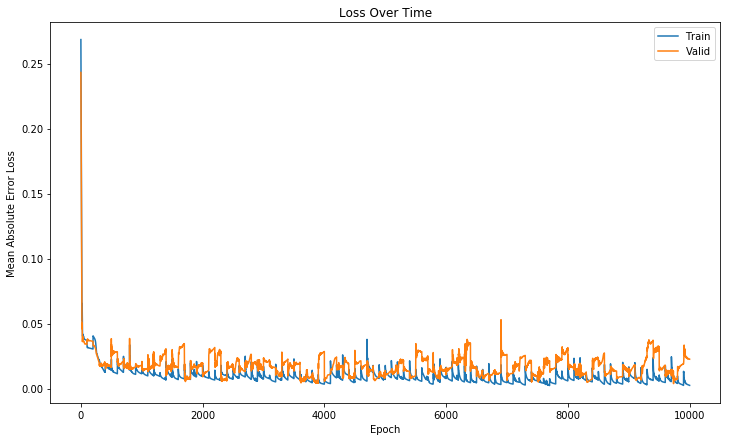

In [133]:
plt.figure(figsize=(12,7))
plt.plot(total_loss)
plt.plot(total_val_loss)

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [134]:
input_seq_test = x_test[4:34].reshape((1,30,1))
output_seq_test = y_test[34:]
decoder_input_test = np.zeros((1,15,1))

In [135]:
pred = model_1.predict([input_seq_test,decoder_input_test])

In [136]:
pred

array([[[0.47467896],
        [0.5040559 ],
        [0.53051174],
        [0.5567493 ],
        [0.57721853],
        [0.5989197 ],
        [0.62301844],
        [0.6479338 ],
        [0.6733523 ],
        [0.6940524 ],
        [0.6688459 ],
        [0.43936715],
        [0.13990769],
        [0.17951953],
        [0.22136885]]], dtype=float32)

In [137]:
pred_values = scaler.inverse_transform(pred.reshape(15,1))
output_seq_test = scaler.inverse_transform(output_seq_test)

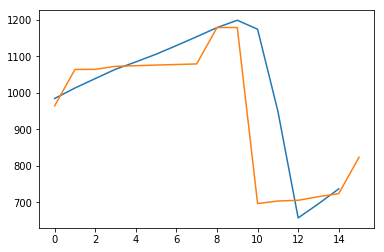

In [138]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

In [26]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

In [180]:
model_2 = create_model([40],1)

In [181]:
total_loss = []
total_val_loss = []
model_2.compile(Adam(), loss = 'mse')

In [182]:
#full batch_size model
full_batch = len(x_train) - input_seq_len - output_seq_len
run_model(model_2,20,256)

Train on 204 samples, validate on 52 samples
Epoch 1/100
204/204 [==============================] - 6s 32ms/step - loss: 0.2617 - val_loss: 0.2838
Epoch 2/100
204/204 [==============================] - 0s 521us/step - loss: 0.2522 - val_loss: 0.2710
Epoch 3/100
204/204 [==============================] - 0s 693us/step - loss: 0.2399 - val_loss: 0.2586
Epoch 4/100
204/204 [==============================] - 0s 747us/step - loss: 0.2280 - val_loss: 0.2465
Epoch 5/100
204/204 [==============================] - 0s 840us/step - loss: 0.2165 - val_loss: 0.2347
Epoch 6/100
204/204 [==============================] - 0s 560us/step - loss: 0.2052 - val_loss: 0.2229
Epoch 7/100
204/204 [==============================] - 0s 609us/step - loss: 0.1941 - val_loss: 0.2112
Epoch 8/100
204/204 [==============================] - 0s 683us/step - loss: 0.1830 - val_loss: 0.1993
Epoch 9/100
204/204 [==============================] - 0s 845us/step - loss: 0.1719 - val_loss: 0.1871
Epoch 10/100
204/204 [=======

Epoch 80/100
204/204 [==============================] - 0s 870us/step - loss: 0.0387 - val_loss: 0.0364
Epoch 81/100
204/204 [==============================] - 0s 895us/step - loss: 0.0386 - val_loss: 0.0365
Epoch 82/100
204/204 [==============================] - 0s 727us/step - loss: 0.0386 - val_loss: 0.0365
Epoch 83/100
204/204 [==============================] - 0s 708us/step - loss: 0.0386 - val_loss: 0.0366
Epoch 84/100
204/204 [==============================] - 0s 614us/step - loss: 0.0386 - val_loss: 0.0366
Epoch 85/100
204/204 [==============================] - 0s 570us/step - loss: 0.0385 - val_loss: 0.0367
Epoch 86/100
204/204 [==============================] - 0s 521us/step - loss: 0.0385 - val_loss: 0.0367
Epoch 87/100
204/204 [==============================] - 0s 605us/step - loss: 0.0385 - val_loss: 0.0366
Epoch 88/100
204/204 [==============================] - 0s 580us/step - loss: 0.0385 - val_loss: 0.0366
Epoch 89/100
204/204 [==============================] - 0s 516us

Epoch 59/100
204/204 [==============================] - 0s 668us/step - loss: 0.0365 - val_loss: 0.0349
Epoch 60/100
204/204 [==============================] - 0s 654us/step - loss: 0.0362 - val_loss: 0.0346
Epoch 61/100
204/204 [==============================] - 0s 600us/step - loss: 0.0360 - val_loss: 0.0344
Epoch 62/100
204/204 [==============================] - 0s 585us/step - loss: 0.0357 - val_loss: 0.0342
Epoch 63/100
204/204 [==============================] - 0s 546us/step - loss: 0.0354 - val_loss: 0.0339
Epoch 64/100
204/204 [==============================] - 0s 541us/step - loss: 0.0351 - val_loss: 0.0336
Epoch 65/100
204/204 [==============================] - 0s 639us/step - loss: 0.0347 - val_loss: 0.0332
Epoch 66/100
204/204 [==============================] - 0s 683us/step - loss: 0.0343 - val_loss: 0.0329
Epoch 67/100
204/204 [==============================] - 0s 511us/step - loss: 0.0338 - val_loss: 0.0325
Epoch 68/100
204/204 [==============================] - 0s 516us

Epoch 38/100
204/204 [==============================] - 0s 609us/step - loss: 0.0194 - val_loss: 0.0281
Epoch 39/100
204/204 [==============================] - 0s 619us/step - loss: 0.0193 - val_loss: 0.0280
Epoch 40/100
204/204 [==============================] - 0s 487us/step - loss: 0.0193 - val_loss: 0.0280
Epoch 41/100
204/204 [==============================] - 0s 521us/step - loss: 0.0192 - val_loss: 0.0278
Epoch 42/100
204/204 [==============================] - 0s 531us/step - loss: 0.0191 - val_loss: 0.0277
Epoch 43/100
204/204 [==============================] - 0s 605us/step - loss: 0.0190 - val_loss: 0.0275
Epoch 44/100
204/204 [==============================] - 0s 531us/step - loss: 0.0190 - val_loss: 0.0274
Epoch 45/100
204/204 [==============================] - 0s 516us/step - loss: 0.0189 - val_loss: 0.0274
Epoch 46/100
204/204 [==============================] - 0s 619us/step - loss: 0.0188 - val_loss: 0.0273
Epoch 47/100
204/204 [==============================] - 0s 590us

Epoch 17/100
204/204 [==============================] - 0s 526us/step - loss: 0.0174 - val_loss: 0.0210
Epoch 18/100
204/204 [==============================] - 0s 664us/step - loss: 0.0175 - val_loss: 0.0210
Epoch 19/100
204/204 [==============================] - 0s 590us/step - loss: 0.0174 - val_loss: 0.0208
Epoch 20/100
204/204 [==============================] - 0s 541us/step - loss: 0.0174 - val_loss: 0.0206
Epoch 21/100
204/204 [==============================] - 0s 531us/step - loss: 0.0174 - val_loss: 0.0207
Epoch 22/100
204/204 [==============================] - 0s 590us/step - loss: 0.0174 - val_loss: 0.0208
Epoch 23/100
204/204 [==============================] - 0s 698us/step - loss: 0.0173 - val_loss: 0.0209
Epoch 24/100
204/204 [==============================] - 0s 609us/step - loss: 0.0173 - val_loss: 0.0209
Epoch 25/100
204/204 [==============================] - 0s 531us/step - loss: 0.0173 - val_loss: 0.0207
Epoch 26/100
204/204 [==============================] - 0s 570us

Epoch 96/100
204/204 [==============================] - 0s 580us/step - loss: 0.0157 - val_loss: 0.0194
Epoch 97/100
204/204 [==============================] - 0s 585us/step - loss: 0.0156 - val_loss: 0.0194
Epoch 98/100
204/204 [==============================] - 0s 511us/step - loss: 0.0156 - val_loss: 0.0194
Epoch 99/100
204/204 [==============================] - 0s 541us/step - loss: 0.0156 - val_loss: 0.0193
Epoch 100/100
204/204 [==============================] - 0s 541us/step - loss: 0.0156 - val_loss: 0.0194
Train on 204 samples, validate on 52 samples
Epoch 1/100
204/204 [==============================] - 0s 649us/step - loss: 0.0174 - val_loss: 0.0181
Epoch 2/100
204/204 [==============================] - 0s 590us/step - loss: 0.0177 - val_loss: 0.0175
Epoch 3/100
204/204 [==============================] - 0s 560us/step - loss: 0.0185 - val_loss: 0.0186
Epoch 4/100
204/204 [==============================] - 0s 600us/step - loss: 0.0183 - val_loss: 0.0175
Epoch 5/100
204/204 [=

Epoch 75/100
204/204 [==============================] - 0s 688us/step - loss: 0.0158 - val_loss: 0.0161
Epoch 76/100
204/204 [==============================] - 0s 605us/step - loss: 0.0158 - val_loss: 0.0161
Epoch 77/100
204/204 [==============================] - 0s 550us/step - loss: 0.0158 - val_loss: 0.0161
Epoch 78/100
204/204 [==============================] - 0s 565us/step - loss: 0.0158 - val_loss: 0.0162
Epoch 79/100
204/204 [==============================] - 0s 590us/step - loss: 0.0158 - val_loss: 0.0161
Epoch 80/100
204/204 [==============================] - 0s 590us/step - loss: 0.0158 - val_loss: 0.0162
Epoch 81/100
204/204 [==============================] - 0s 491us/step - loss: 0.0158 - val_loss: 0.0161
Epoch 82/100
204/204 [==============================] - 0s 560us/step - loss: 0.0158 - val_loss: 0.0162
Epoch 83/100
204/204 [==============================] - 0s 531us/step - loss: 0.0158 - val_loss: 0.0161
Epoch 84/100
204/204 [==============================] - 0s 585us

Epoch 54/100
204/204 [==============================] - 0s 600us/step - loss: 0.0129 - val_loss: 0.0220
Epoch 55/100
204/204 [==============================] - 0s 555us/step - loss: 0.0129 - val_loss: 0.0217
Epoch 56/100
204/204 [==============================] - 0s 580us/step - loss: 0.0129 - val_loss: 0.0218
Epoch 57/100
204/204 [==============================] - 0s 516us/step - loss: 0.0129 - val_loss: 0.0219
Epoch 58/100
204/204 [==============================] - 0s 580us/step - loss: 0.0129 - val_loss: 0.0218
Epoch 59/100
204/204 [==============================] - 0s 531us/step - loss: 0.0129 - val_loss: 0.0220
Epoch 60/100
204/204 [==============================] - 0s 585us/step - loss: 0.0129 - val_loss: 0.0220
Epoch 61/100
204/204 [==============================] - 0s 600us/step - loss: 0.0128 - val_loss: 0.0219
Epoch 62/100
204/204 [==============================] - 0s 565us/step - loss: 0.0128 - val_loss: 0.0222
Epoch 63/100
204/204 [==============================] - 0s 521us

Epoch 33/100
204/204 [==============================] - 0s 624us/step - loss: 0.0141 - val_loss: 0.0117
Epoch 34/100
204/204 [==============================] - 0s 595us/step - loss: 0.0141 - val_loss: 0.0117
Epoch 35/100
204/204 [==============================] - 0s 590us/step - loss: 0.0140 - val_loss: 0.0117
Epoch 36/100
204/204 [==============================] - 0s 570us/step - loss: 0.0140 - val_loss: 0.0117
Epoch 37/100
204/204 [==============================] - 0s 541us/step - loss: 0.0140 - val_loss: 0.0117
Epoch 38/100
204/204 [==============================] - 0s 634us/step - loss: 0.0140 - val_loss: 0.0118
Epoch 39/100
204/204 [==============================] - 0s 546us/step - loss: 0.0140 - val_loss: 0.0118
Epoch 40/100
204/204 [==============================] - 0s 550us/step - loss: 0.0141 - val_loss: 0.0121
Epoch 41/100
204/204 [==============================] - 0s 590us/step - loss: 0.0143 - val_loss: 0.0125
Epoch 42/100
204/204 [==============================] - 0s 570us

Epoch 12/100
204/204 [==============================] - 0s 541us/step - loss: 0.0129 - val_loss: 0.0132
Epoch 13/100
204/204 [==============================] - 0s 595us/step - loss: 0.0129 - val_loss: 0.0131
Epoch 14/100
204/204 [==============================] - 0s 634us/step - loss: 0.0129 - val_loss: 0.0130
Epoch 15/100
204/204 [==============================] - 0s 595us/step - loss: 0.0128 - val_loss: 0.0130
Epoch 16/100
204/204 [==============================] - 0s 491us/step - loss: 0.0128 - val_loss: 0.0130
Epoch 17/100
204/204 [==============================] - 0s 541us/step - loss: 0.0128 - val_loss: 0.0131
Epoch 18/100
204/204 [==============================] - 0s 555us/step - loss: 0.0128 - val_loss: 0.0132
Epoch 19/100
204/204 [==============================] - 0s 501us/step - loss: 0.0128 - val_loss: 0.0132
Epoch 20/100
204/204 [==============================] - 0s 595us/step - loss: 0.0128 - val_loss: 0.0132
Epoch 21/100
204/204 [==============================] - 0s 757us

Epoch 91/100
204/204 [==============================] - 0s 585us/step - loss: 0.0122 - val_loss: 0.0126
Epoch 92/100
204/204 [==============================] - 0s 541us/step - loss: 0.0122 - val_loss: 0.0125
Epoch 93/100
204/204 [==============================] - 0s 491us/step - loss: 0.0122 - val_loss: 0.0125
Epoch 94/100
204/204 [==============================] - 0s 457us/step - loss: 0.0122 - val_loss: 0.0125
Epoch 95/100
204/204 [==============================] - 0s 521us/step - loss: 0.0122 - val_loss: 0.0125
Epoch 96/100
204/204 [==============================] - 0s 457us/step - loss: 0.0122 - val_loss: 0.0125
Epoch 97/100
204/204 [==============================] - 0s 482us/step - loss: 0.0122 - val_loss: 0.0124
Epoch 98/100
204/204 [==============================] - 0s 550us/step - loss: 0.0122 - val_loss: 0.0124
Epoch 99/100
204/204 [==============================] - 0s 560us/step - loss: 0.0121 - val_loss: 0.0124
Epoch 100/100
204/204 [==============================] - 0s 580u

Epoch 70/100
204/204 [==============================] - 0s 550us/step - loss: 0.0145 - val_loss: 0.0166
Epoch 71/100
204/204 [==============================] - 0s 491us/step - loss: 0.0138 - val_loss: 0.0162
Epoch 72/100
204/204 [==============================] - 0s 442us/step - loss: 0.0135 - val_loss: 0.0164
Epoch 73/100
204/204 [==============================] - 0s 472us/step - loss: 0.0136 - val_loss: 0.0166
Epoch 74/100
204/204 [==============================] - 0s 452us/step - loss: 0.0138 - val_loss: 0.0168
Epoch 75/100
204/204 [==============================] - 0s 506us/step - loss: 0.0140 - val_loss: 0.0165
Epoch 76/100
204/204 [==============================] - 0s 624us/step - loss: 0.0136 - val_loss: 0.0163
Epoch 77/100
204/204 [==============================] - 0s 550us/step - loss: 0.0134 - val_loss: 0.0164
Epoch 78/100
204/204 [==============================] - 0s 477us/step - loss: 0.0136 - val_loss: 0.0165
Epoch 79/100
204/204 [==============================] - 0s 491us

Epoch 49/100
204/204 [==============================] - 0s 614us/step - loss: 0.0131 - val_loss: 0.0148
Epoch 50/100
204/204 [==============================] - 0s 501us/step - loss: 0.0131 - val_loss: 0.0139
Epoch 51/100
204/204 [==============================] - 0s 560us/step - loss: 0.0128 - val_loss: 0.0141
Epoch 52/100
204/204 [==============================] - 0s 673us/step - loss: 0.0126 - val_loss: 0.0143
Epoch 53/100
204/204 [==============================] - 0s 555us/step - loss: 0.0127 - val_loss: 0.0139
Epoch 54/100
204/204 [==============================] - 0s 467us/step - loss: 0.0128 - val_loss: 0.0151
Epoch 55/100
204/204 [==============================] - 0s 442us/step - loss: 0.0131 - val_loss: 0.0138
Epoch 56/100
204/204 [==============================] - 0s 487us/step - loss: 0.0131 - val_loss: 0.0152
Epoch 57/100
204/204 [==============================] - 0s 501us/step - loss: 0.0131 - val_loss: 0.0139
Epoch 58/100
204/204 [==============================] - 0s 491us

Epoch 28/100
204/204 [==============================] - 0s 595us/step - loss: 0.0122 - val_loss: 0.0118
Epoch 29/100
204/204 [==============================] - 0s 600us/step - loss: 0.0116 - val_loss: 0.0118
Epoch 30/100
204/204 [==============================] - 0s 718us/step - loss: 0.0115 - val_loss: 0.0126
Epoch 31/100
204/204 [==============================] - 0s 565us/step - loss: 0.0116 - val_loss: 0.0120
Epoch 32/100
204/204 [==============================] - 0s 492us/step - loss: 0.0117 - val_loss: 0.0127
Epoch 33/100
204/204 [==============================] - 0s 536us/step - loss: 0.0117 - val_loss: 0.0118
Epoch 34/100
204/204 [==============================] - 0s 536us/step - loss: 0.0113 - val_loss: 0.0120
Epoch 35/100
204/204 [==============================] - 0s 555us/step - loss: 0.0113 - val_loss: 0.0124
Epoch 36/100
204/204 [==============================] - 0s 516us/step - loss: 0.0114 - val_loss: 0.0119
Epoch 37/100
204/204 [==============================] - 0s 575us

Epoch 7/100
204/204 [==============================] - 0s 767us/step - loss: 0.0127 - val_loss: 0.0110
Epoch 8/100
204/204 [==============================] - 0s 619us/step - loss: 0.0123 - val_loss: 0.0111
Epoch 9/100
204/204 [==============================] - 0s 570us/step - loss: 0.0122 - val_loss: 0.0115
Epoch 10/100
204/204 [==============================] - 0s 629us/step - loss: 0.0124 - val_loss: 0.0110
Epoch 11/100
204/204 [==============================] - 0s 595us/step - loss: 0.0126 - val_loss: 0.0120
Epoch 12/100
204/204 [==============================] - 0s 605us/step - loss: 0.0126 - val_loss: 0.0106
Epoch 13/100
204/204 [==============================] - 0s 609us/step - loss: 0.0125 - val_loss: 0.0113
Epoch 14/100
204/204 [==============================] - 0s 575us/step - loss: 0.0122 - val_loss: 0.0114
Epoch 15/100
204/204 [==============================] - 0s 659us/step - loss: 0.0121 - val_loss: 0.0110
Epoch 16/100
204/204 [==============================] - 0s 614us/st

Epoch 86/100
204/204 [==============================] - 0s 550us/step - loss: 0.0113 - val_loss: 0.0111
Epoch 87/100
204/204 [==============================] - 0s 570us/step - loss: 0.0114 - val_loss: 0.0119
Epoch 88/100
204/204 [==============================] - 0s 521us/step - loss: 0.0113 - val_loss: 0.0112
Epoch 89/100
204/204 [==============================] - 0s 511us/step - loss: 0.0112 - val_loss: 0.0116
Epoch 90/100
204/204 [==============================] - 0s 550us/step - loss: 0.0112 - val_loss: 0.0114
Epoch 91/100
204/204 [==============================] - 0s 609us/step - loss: 0.0111 - val_loss: 0.0114
Epoch 92/100
204/204 [==============================] - 0s 580us/step - loss: 0.0111 - val_loss: 0.0117
Epoch 93/100
204/204 [==============================] - 0s 477us/step - loss: 0.0111 - val_loss: 0.0112
Epoch 94/100
204/204 [==============================] - 0s 501us/step - loss: 0.0112 - val_loss: 0.0120
Epoch 95/100
204/204 [==============================] - 0s 536us

Epoch 65/100
204/204 [==============================] - 0s 693us/step - loss: 0.0102 - val_loss: 0.0124
Epoch 66/100
204/204 [==============================] - 0s 546us/step - loss: 0.0102 - val_loss: 0.0124
Epoch 67/100
204/204 [==============================] - 0s 477us/step - loss: 0.0101 - val_loss: 0.0124
Epoch 68/100
204/204 [==============================] - 0s 531us/step - loss: 0.0101 - val_loss: 0.0123
Epoch 69/100
204/204 [==============================] - 0s 546us/step - loss: 0.0101 - val_loss: 0.0123
Epoch 70/100
204/204 [==============================] - 0s 536us/step - loss: 0.0101 - val_loss: 0.0123
Epoch 71/100
204/204 [==============================] - 0s 609us/step - loss: 0.0101 - val_loss: 0.0124
Epoch 72/100
204/204 [==============================] - 0s 585us/step - loss: 0.0101 - val_loss: 0.0124
Epoch 73/100
204/204 [==============================] - 0s 491us/step - loss: 0.0101 - val_loss: 0.0125
Epoch 74/100
204/204 [==============================] - 0s 521us

Epoch 44/100
204/204 [==============================] - 0s 492us/step - loss: 0.0122 - val_loss: 0.0138
Epoch 45/100
204/204 [==============================] - 0s 531us/step - loss: 0.0121 - val_loss: 0.0139
Epoch 46/100
204/204 [==============================] - 0s 491us/step - loss: 0.0120 - val_loss: 0.0138
Epoch 47/100
204/204 [==============================] - 0s 609us/step - loss: 0.0119 - val_loss: 0.0138
Epoch 48/100
204/204 [==============================] - 0s 536us/step - loss: 0.0119 - val_loss: 0.0141
Epoch 49/100
204/204 [==============================] - 0s 442us/step - loss: 0.0120 - val_loss: 0.0138
Epoch 50/100
204/204 [==============================] - 0s 526us/step - loss: 0.0120 - val_loss: 0.0143
Epoch 51/100
204/204 [==============================] - 0s 472us/step - loss: 0.0121 - val_loss: 0.0139
Epoch 52/100
204/204 [==============================] - 0s 428us/step - loss: 0.0120 - val_loss: 0.0142
Epoch 53/100
204/204 [==============================] - 0s 457us

Epoch 23/100
204/204 [==============================] - 0s 521us/step - loss: 0.0103 - val_loss: 0.0123
Epoch 24/100
204/204 [==============================] - 0s 496us/step - loss: 0.0103 - val_loss: 0.0123
Epoch 25/100
204/204 [==============================] - 0s 526us/step - loss: 0.0103 - val_loss: 0.0128
Epoch 26/100
204/204 [==============================] - 0s 605us/step - loss: 0.0103 - val_loss: 0.0122
Epoch 27/100
204/204 [==============================] - 0s 634us/step - loss: 0.0102 - val_loss: 0.0122
Epoch 28/100
204/204 [==============================] - 0s 619us/step - loss: 0.0102 - val_loss: 0.0127
Epoch 29/100
204/204 [==============================] - 0s 536us/step - loss: 0.0102 - val_loss: 0.0125
Epoch 30/100
204/204 [==============================] - 0s 487us/step - loss: 0.0102 - val_loss: 0.0126
Epoch 31/100
204/204 [==============================] - 0s 437us/step - loss: 0.0101 - val_loss: 0.0128
Epoch 32/100
204/204 [==============================] - 0s 472us

Epoch 2/100
204/204 [==============================] - 0s 585us/step - loss: 0.0116 - val_loss: 0.0112
Epoch 3/100
204/204 [==============================] - 0s 575us/step - loss: 0.0118 - val_loss: 0.0097
Epoch 4/100
204/204 [==============================] - 0s 516us/step - loss: 0.0114 - val_loss: 0.0097
Epoch 5/100
204/204 [==============================] - 0s 634us/step - loss: 0.0113 - val_loss: 0.0099
Epoch 6/100
204/204 [==============================] - 0s 629us/step - loss: 0.0114 - val_loss: 0.0101
Epoch 7/100
204/204 [==============================] - 0s 472us/step - loss: 0.0112 - val_loss: 0.0104
Epoch 8/100
204/204 [==============================] - 0s 526us/step - loss: 0.0112 - val_loss: 0.0101
Epoch 9/100
204/204 [==============================] - 0s 565us/step - loss: 0.0110 - val_loss: 0.0098
Epoch 10/100
204/204 [==============================] - 0s 590us/step - loss: 0.0110 - val_loss: 0.0096
Epoch 11/100
204/204 [==============================] - 0s 526us/step - 

Epoch 81/100
204/204 [==============================] - 0s 605us/step - loss: 0.0100 - val_loss: 0.0096
Epoch 82/100
204/204 [==============================] - 0s 506us/step - loss: 0.0098 - val_loss: 0.0097
Epoch 83/100
204/204 [==============================] - 0s 570us/step - loss: 0.0098 - val_loss: 0.0100
Epoch 84/100
204/204 [==============================] - 0s 664us/step - loss: 0.0099 - val_loss: 0.0097
Epoch 85/100
204/204 [==============================] - 0s 536us/step - loss: 0.0100 - val_loss: 0.0105
Epoch 86/100
204/204 [==============================] - 0s 541us/step - loss: 0.0102 - val_loss: 0.0096
Epoch 87/100
204/204 [==============================] - 0s 570us/step - loss: 0.0101 - val_loss: 0.0101
Epoch 88/100
204/204 [==============================] - 0s 570us/step - loss: 0.0099 - val_loss: 0.0097
Epoch 89/100
204/204 [==============================] - 0s 496us/step - loss: 0.0097 - val_loss: 0.0097
Epoch 90/100
204/204 [==============================] - 0s 496us

Epoch 60/100
204/204 [==============================] - 0s 654us/step - loss: 0.0096 - val_loss: 0.0098
Epoch 61/100
204/204 [==============================] - 0s 531us/step - loss: 0.0096 - val_loss: 0.0101
Epoch 62/100
204/204 [==============================] - 0s 550us/step - loss: 0.0094 - val_loss: 0.0096
Epoch 63/100
204/204 [==============================] - 0s 546us/step - loss: 0.0093 - val_loss: 0.0096
Epoch 64/100
204/204 [==============================] - 0s 600us/step - loss: 0.0092 - val_loss: 0.0096
Epoch 65/100
204/204 [==============================] - 0s 585us/step - loss: 0.0092 - val_loss: 0.0095
Epoch 66/100
204/204 [==============================] - 0s 639us/step - loss: 0.0092 - val_loss: 0.0098
Epoch 67/100
204/204 [==============================] - 0s 605us/step - loss: 0.0092 - val_loss: 0.0095
Epoch 68/100
204/204 [==============================] - 0s 575us/step - loss: 0.0093 - val_loss: 0.0099
Epoch 69/100
204/204 [==============================] - 0s 605us

Epoch 39/100
204/204 [==============================] - 0s 605us/step - loss: 0.0090 - val_loss: 0.0114
Epoch 40/100
204/204 [==============================] - 0s 487us/step - loss: 0.0090 - val_loss: 0.0112
Epoch 41/100
204/204 [==============================] - 0s 492us/step - loss: 0.0091 - val_loss: 0.0116
Epoch 42/100
204/204 [==============================] - 0s 555us/step - loss: 0.0091 - val_loss: 0.0111
Epoch 43/100
204/204 [==============================] - 0s 570us/step - loss: 0.0090 - val_loss: 0.0114
Epoch 44/100
204/204 [==============================] - 0s 526us/step - loss: 0.0090 - val_loss: 0.0113
Epoch 45/100
204/204 [==============================] - 0s 742us/step - loss: 0.0089 - val_loss: 0.0113
Epoch 46/100
204/204 [==============================] - 0s 565us/step - loss: 0.0090 - val_loss: 0.0112
Epoch 47/100
204/204 [==============================] - 0s 536us/step - loss: 0.0089 - val_loss: 0.0111
Epoch 48/100
204/204 [==============================] - 0s 496us

Epoch 18/100
204/204 [==============================] - 0s 590us/step - loss: 0.0095 - val_loss: 0.0100
Epoch 19/100
204/204 [==============================] - 0s 639us/step - loss: 0.0094 - val_loss: 0.0100
Epoch 20/100
204/204 [==============================] - 0s 536us/step - loss: 0.0095 - val_loss: 0.0095
Epoch 21/100
204/204 [==============================] - 0s 467us/step - loss: 0.0096 - val_loss: 0.0103
Epoch 22/100
204/204 [==============================] - 0s 428us/step - loss: 0.0096 - val_loss: 0.0103
Epoch 23/100
204/204 [==============================] - 0s 457us/step - loss: 0.0094 - val_loss: 0.0105
Epoch 24/100
204/204 [==============================] - 0s 536us/step - loss: 0.0092 - val_loss: 0.0102
Epoch 25/100
204/204 [==============================] - 0s 496us/step - loss: 0.0092 - val_loss: 0.0099
Epoch 26/100
204/204 [==============================] - 0s 536us/step - loss: 0.0093 - val_loss: 0.0105
Epoch 27/100
204/204 [==============================] - 0s 536us

Epoch 97/100
204/204 [==============================] - 0s 585us/step - loss: 0.0086 - val_loss: 0.0101
Epoch 98/100
204/204 [==============================] - 0s 541us/step - loss: 0.0087 - val_loss: 0.0107
Epoch 99/100
204/204 [==============================] - 0s 511us/step - loss: 0.0088 - val_loss: 0.0101
Epoch 100/100
204/204 [==============================] - 0s 550us/step - loss: 0.0088 - val_loss: 0.0107
Train on 204 samples, validate on 52 samples
Epoch 1/100
204/204 [==============================] - 0s 575us/step - loss: 0.0088 - val_loss: 0.0090
Epoch 2/100
204/204 [==============================] - 0s 521us/step - loss: 0.0085 - val_loss: 0.0088
Epoch 3/100
204/204 [==============================] - 0s 487us/step - loss: 0.0082 - val_loss: 0.0086
Epoch 4/100
204/204 [==============================] - 0s 546us/step - loss: 0.0080 - val_loss: 0.0087
Epoch 5/100
204/204 [==============================] - 0s 511us/step - loss: 0.0081 - val_loss: 0.0088
Epoch 6/100
204/204 [==

Epoch 76/100
204/204 [==============================] - 0s 536us/step - loss: 0.0070 - val_loss: 0.0079
Epoch 77/100
204/204 [==============================] - 0s 526us/step - loss: 0.0071 - val_loss: 0.0090
Epoch 78/100
204/204 [==============================] - 0s 565us/step - loss: 0.0075 - val_loss: 0.0079
Epoch 79/100
204/204 [==============================] - 0s 580us/step - loss: 0.0070 - val_loss: 0.0079
Epoch 80/100
204/204 [==============================] - 0s 555us/step - loss: 0.0067 - val_loss: 0.0078
Epoch 81/100
204/204 [==============================] - 0s 501us/step - loss: 0.0067 - val_loss: 0.0079
Epoch 82/100
204/204 [==============================] - 0s 590us/step - loss: 0.0068 - val_loss: 0.0081
Epoch 83/100
204/204 [==============================] - 0s 614us/step - loss: 0.0070 - val_loss: 0.0079
Epoch 84/100
204/204 [==============================] - 0s 526us/step - loss: 0.0070 - val_loss: 0.0081
Epoch 85/100
204/204 [==============================] - 0s 511us

In [183]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

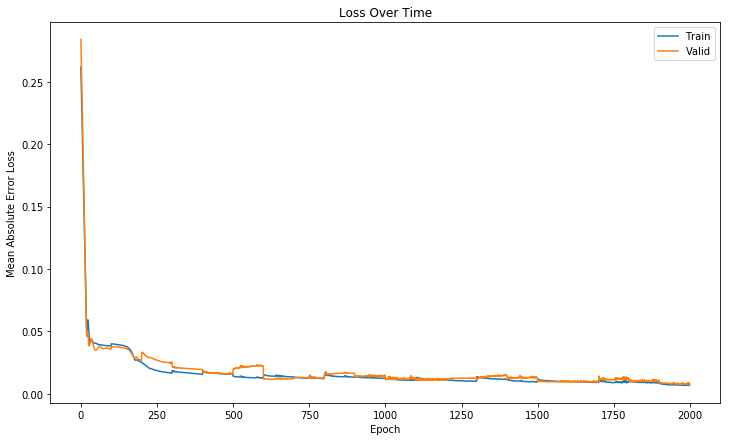

In [184]:
plt.figure(figsize=(12,7))
plt.plot(total_loss)
plt.plot(total_val_loss)

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [185]:
input_seq_test = x_test[4:34].reshape((1,30,1))
output_seq_test = y_test[34:]
decoder_input_test = np.zeros((1,15,1))

In [186]:
pred = model_2.predict([input_seq_test,decoder_input_test])

In [187]:
pred_values = scaler.inverse_transform(pred.reshape(15,1))
output_seq_test = scaler.inverse_transform(output_seq_test)

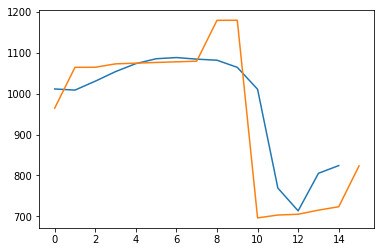

In [188]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

In [144]:
model_3 = create_model([40,40],2)

In [145]:
total_loss = []
total_val_loss = []
model_3.compile(Adam(), loss = 'mse')

In [146]:
#2 layered model
run_model(model_3,100,64)

Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 11s 222ms/step - loss: 0.2506 - val_loss: 0.2352
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2304 - val_loss: 0.2164
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2113 - val_loss: 0.1979
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.1927 - val_loss: 0.1794
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.1740 - val_loss: 0.1605
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.1550 - val_loss: 0.1413
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.1356 - val_loss: 0.1217
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.1160 - val_loss: 0.1024
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0967 - val_loss: 0.0843
Epoch 10/100
51/51 [==============================] - 0s 2ms/s

Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0368
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.0367
Epoch 85/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.0367
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0367
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0367
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0367
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0366
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0366
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0366
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0365


Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0239
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0201 - val_loss: 0.0238
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0199 - val_loss: 0.0237
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0198 - val_loss: 0.0236
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0234
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0196 - val_loss: 0.0233
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0195 - val_loss: 0.0232
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0231
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0193 - val_loss: 0.0230
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0193 - val_loss: 0.0229


Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0189 - val_loss: 0.0203
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0189 - val_loss: 0.0204
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0188 - val_loss: 0.0204
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0188 - val_loss: 0.0205
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0187 - val_loss: 0.0206
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0187 - val_loss: 0.0207
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0186 - val_loss: 0.0207
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0207
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0207
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0208


Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0156
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0156
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0152
Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0153
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0150


Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0190
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0186
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0178
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0177
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0177
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0176
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0178
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0181
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0179
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0173


Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0223
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0221
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0225
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0219
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0232
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0213
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0255
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0212
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0193
Epoch 2/100
51/51 [==============================] - 0s 

Epoch 75/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0192
Epoch 76/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0192
Epoch 77/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0192
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0192
Epoch 79/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0192
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0192
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0192
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0192
Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.0192
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0192


Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0150
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0151
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0150
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0147
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0147
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0148
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0149
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0147
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0145
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0144


Epoch 39/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0246
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0248
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0250
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0252
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0253
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0253
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0252
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0251
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0250
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0251


Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0072
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0076
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0077
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0073
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0073
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0076
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0078


Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.0156
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0159
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0156
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0159
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0153
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0151
Epoch 1

Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0178
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0178
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0178
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0178
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0177
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0177
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0176
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0176
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0175
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0175


Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0172
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0174
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0196
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0147
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0178
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0173
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0148
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0162
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0155
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0146


Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0140
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0142
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0143
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0143
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0148
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0145
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0158
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0162
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0190
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0170


Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0123
Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0123
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0118
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0117
Epoch 38/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0120
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0115


Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0194
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0192
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0192
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0187
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0179
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0180
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0184
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0179
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0173
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0179


Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0181
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0181
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0181
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0181
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0181
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0181
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0073
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0092
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0094
Epoch 4/100
51/51 [==============================] - 0s 2m

Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0115
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0115
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0116
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0117
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0118
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0120
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0120
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0121
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0122


Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0079


Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0060
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0060
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0061
Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0102


Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0122
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0123
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0124
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0124
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0124
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0124
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0124
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0126
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0128


Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0167
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0216
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0251
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0226
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0180
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0166
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0181
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0213
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0234
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0224
Epoch

Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0403
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0403
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0403
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0404
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0401
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0403
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0401
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0402
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0403
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0400


Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0071
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0073
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0075
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0076
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0077
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0078
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0079
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0080
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0080


Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0271
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0234
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0148
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0160
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0246
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0249
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0171
Epoch 59/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0145
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0171


Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0127
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0132
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0131
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0124
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0118
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0120
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0130
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0140
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0143
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0140


Epoch 15/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.0219
Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0236
Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0236
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0231
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0230
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0228
Epoch 21/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0084 - val_loss: 0.0217
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0211
Epoch 23/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0214
Epoch 24/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0222


Epoch 97/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0188
Epoch 98/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0181
Epoch 99/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0187
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0195
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0234 - val_loss: 0.0225
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0225
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0193 - val_loss: 0.0205
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.0192
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0167 - val_loss: 0.0184
Epoch 6/100
51/51 [==============================] - 0s 2ms/

Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0146
Epoch 80/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0145
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0145
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0145
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0144
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0144
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0144
Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0143
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0143
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0143


Epoch 61/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0181
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0182
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0183
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0182
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0182
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0182
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0184
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0185
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0184
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0184


Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0096
Epoch 44/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0097


Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0189
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0192
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0195
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0196
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0197
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0197
Epoch 31/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0196
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0197
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0197
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0196


Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0302
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0181 - val_loss: 0.0297
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.0281
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0275
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0276
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0275
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0270
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0268
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0268
Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0135 - val_loss: 0.0266
Epo

Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0254
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0253
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0252
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0252
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0251
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0250
Epoch 95/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0249
Epoch 96/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0248
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0247
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0246


Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0227
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0226
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0228
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0230
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0231
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0230
Epoch 77/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0230
Epoch 78/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0231
Epoch 79/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0235
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0238


Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0228
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0231
Epoch 55/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0233
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0235
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0236
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0237
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0238
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0238
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0238
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0238


Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0144
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0149
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0151
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0149
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0151
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0155
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0157
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0158
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0162
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0167


Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0282
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0278
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0290
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0303
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0299
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0282
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0286
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0311
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0323
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0315


Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0469
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0442
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.0300
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0189 - val_loss: 0.0261
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0166 - val_loss: 0.0207
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0180
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0156
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0153
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0155
Epoch 8/100
51/51 [==============================] - 0s 2ms/st

Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0154
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0155
Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0155
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0155
Epoch 85/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0156
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0156
Epoch 87/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0157
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0157
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0157
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0157


Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0148
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0148
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0149
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0149
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0151
Epoch 68/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0151
Epoch 69/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0151
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0151
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0151
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0152


Epoch 45/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0226
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0229
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0230
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0231
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0234
Epoch 50/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0239
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0243
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0244
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0244
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0244


Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0140
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0141
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0142
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0142
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0140
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0137
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0135
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0134
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0134
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0134


Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0159
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0153
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0153
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0157
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0163
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0170
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0179
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0190
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0201
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0210
E

Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0231
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0231
Epoch 93/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0231
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0230
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0230
Epoch 96/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0230
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0230
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0229
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0229
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0229

Epoch 73/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0138
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0138
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0139
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0141
Epoch 77/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0141
Epoch 78/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0142
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0143
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0145
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0146
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0147


Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0074
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0074
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0074
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0075
Epoch 64/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0076


Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0298
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0301
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0304
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0301
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0300
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0304
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0302
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0300
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0302
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0303


Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0056
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0059
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0055


Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0095
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0122
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0137
Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0148
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0159
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0163
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0151
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0142
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0139
Epoch 10/100
51/51 [==============================] - 0s 1ms/step

Epoch 83/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0109
Epoch 84/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0110
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0111
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0111
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0112
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0113
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0113
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0113
Epoch 91/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0115
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0114


Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0307
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0305
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0312
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0316
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0310
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0307
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0310
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0311
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0310
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0312


Epoch 47/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0286
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0287
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0287
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0286
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0287
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0290
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0293
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0294
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0295
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0296


Epoch 29/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0198
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0202
Epoch 31/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0206
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0209
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0210
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0208
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0205
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0203
Epoch 37/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0202
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0200


Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0189
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0179
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0174
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0164
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0153
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0156
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0175
Epoch 18/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0163
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0159
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0165


Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0162
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0163
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0166
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0166
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0167
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0167
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0168
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0167
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 2/100
51/51 [==============================] - 0s 

Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0092
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0085
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0089
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0094
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0091
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0090
Epoch 82/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0091
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0092


Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0148
Epoch 58/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0155
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0151
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0152
Epoch 61/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0155
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0151
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0150
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0153
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0150
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0166


Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0136
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0134
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0131
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0144
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0143
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0145
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0144
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0144
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0139
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0136


Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0075
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0072
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0068
Epoch 26/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0071
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0072


Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0228
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0199
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0196
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0182
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0161
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0176
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0180
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0169
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0169
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0182
Epoch 1

Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0236
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0236
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0236
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0236
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0237
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0238
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0237
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0236
Epoch 93/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0235
Epoch 94/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0236


Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0275
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0271
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0272
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0267
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0267
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0261
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0278
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0279
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0275
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0276


Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0102
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0099
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0101
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0103
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0099


Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0284
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0283
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0287
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0290
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0282
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0290
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0279
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0281
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0282
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0275


Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0071
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0077
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0050


Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 99/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0045
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0042
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0046
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0053
Epoch 4/100
51/51 [==============================] - 0s 2m

Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0068
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 84/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0077
Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0069


Epoch 59/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0163
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0161
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0158
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0157
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0158
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0159
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0160
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0157
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0153
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0150


Epoch 41/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0109
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0106
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0102
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0103
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0108
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0106
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0103
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0106
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0108
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0103


Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0195
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0188
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0184
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0182
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0180
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0180
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0182
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0183
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0184
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0182


Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0235
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0243
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0250
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0256
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0258
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0256
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0248
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0241
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0237
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0241
Epoch 

Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0240
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0241
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0242
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0243
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0243
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0244
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0243
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0248
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0243
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0257


Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0109
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0099
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0094
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0103
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0104
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0096
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0101
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0103
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0099


Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 51/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0072
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0072
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0071
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0071
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0071
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0071


Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0095
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0095
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0096
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0096
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0096
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0094
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0093
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0094
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0095
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0094


Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0157
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0131
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0108
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0099
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0097
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0106
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0115
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0118


Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0092
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0091
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0092
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0092
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0191 - val_loss: 0.0081
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.0115
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0138
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 5/100
51/51 [==============================] - 0s 2ms

Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0114
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0114
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0113
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0113
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0113
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0113
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0113
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0113
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0112
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0112


Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6741e-04 - val_loss: 0.0134
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6131e-04 - val_loss: 0.0134
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 9.5579e-04 - val_loss: 0.0134
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 9.5047e-04 - val_loss: 0.0134
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4530e-04 - val_loss: 0.0134
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4034e-04 - val_loss: 0.0134
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3531e-04 - val_loss: 0.0134
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3036e-04 - val_loss: 0.0134
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 9.2558e-04 - val_loss: 0.0134
Epoch 69/100
51/51 [==============================] - 0s 2ms/ste

Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0136
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0125
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0123
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0130
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0136
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0125
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0109
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0106
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0120
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0115


Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0110
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0101
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0080
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0075
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0080
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0069
Epoch 28/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0061
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0096
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0095
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0067


Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0162
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0178
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0177
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0178
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0178
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0175
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0170
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0166
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0166
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0171
Epoch 

Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0256
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0256
Epoch 88/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0257
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0256
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0256
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0256
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9883e-04 - val_loss: 0.0256
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9533e-04 - val_loss: 0.0256
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9174e-04 - val_loss: 0.0256
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8832e-04 - v

Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0084
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0086
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0085
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0088
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0087
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0078
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0081
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0083


Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0112
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0111
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0113
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0114
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0113
Epoch 55/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0114
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0114
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0113
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0111
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0110


Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0108
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0108
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0108
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0108
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0109
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0109


Epoch 13/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0107
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0104
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0105
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0106
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0116
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0122
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0130
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0124
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0116


Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 7.5451e-04 - val_loss: 0.0119
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 7.5178e-04 - val_loss: 0.0119
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 7.4896e-04 - val_loss: 0.0119
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 7.4612e-04 - val_loss: 0.0119
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 7.4341e-04 - val_loss: 0.0119
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 7.4067e-04 - val_loss: 0.0119
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 7.3805e-04 - val_loss: 0.0119
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0196
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0210
Epoch 3/100
51/51 [==========

Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0333
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0327
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0331
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0327
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0322
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0330
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0321
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0329
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0331
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0319


Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0172
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0171
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0172
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0170
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0168
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0168
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0171
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0175
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0179
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0180


Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0168
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0168
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0168
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0167
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0167
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0167
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0169
Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0171
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0170
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0168


Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0051


Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0091
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0075
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0071
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0071
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0073
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0075
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0078
Epoch 

Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4393e-04 - val_loss: 0.0085
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4914e-04 - val_loss: 0.0084
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3979e-04 - val_loss: 0.0084
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3152e-04 - val_loss: 0.0085
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3390e-04 - val_loss: 0.0085
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 9.2054e-04 - val_loss: 0.0084
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 9.2275e-04 - val_loss: 0.0085
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 9.1526e-04 - val_loss: 0.0086
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 9.1045e-04 - val_loss: 0.0085
Epoch 95/100
51/51 [==============================] - 0s 2ms/ste

Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0114
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0114
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0114
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0115
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0116
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0117
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0117
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0118
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0118


Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0049


Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0097
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0103
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0090
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0080
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0079
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0091
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0090


Epoch 12/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0078
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0081
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0073
Epoch 15/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0058
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0060
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0067


Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9772e-04 - val_loss: 0.0049
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9378e-04 - val_loss: 0.0049
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8993e-04 - val_loss: 0.0049
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8601e-04 - val_loss: 0.0050
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8265e-04 - val_loss: 0.0050
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 9.7913e-04 - val_loss: 0.0050
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0135
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0131
Epoch 3/100
51/51 [==============

Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0105
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0107
Epoch 78/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0110
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0112
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0110
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0108
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0107
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0110
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0111
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0110


Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0247
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0248
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0241
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0248
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0251
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0249
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0240
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0244
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0254
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0254


Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0195
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0187
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0213
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0223
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0216
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0210
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0214
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0218
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0210
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0226


Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0119
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0122
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0125
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0127
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0127
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0127
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0127
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0127
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0126
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0124


Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0068
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0089
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0091
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0100
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0106
Epoch 1

Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0117
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0117
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0117


Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0144
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0143
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0138
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0153
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0135
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0137
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0140
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0128
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0136
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0133


Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0118
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0116
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0118
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0121
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0123
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0124
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0125
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0126
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0125
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0124


Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0115
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0118
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0119
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0120
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0123
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0125
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0125
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0125
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0127


Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0082
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0073
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0082
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0073
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0077
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0085


Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0097
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0098
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0098
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0098
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0098
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0098
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0118
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0130
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0140
Epoch 4/100
51/51 [==============================] - 0s 2m

Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0133
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0134
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0134
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0134
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0134
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0134
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0134
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0135
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0135
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0135


Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0081
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0081
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0081
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0081
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0081
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0081
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0082
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0082


Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0231
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0230
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0218
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0189
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0219
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0192
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0203
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0226
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0224
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0198


Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0161
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0162
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0167
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0166
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0162
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0166
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0164
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0159
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0163
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0171


Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0267
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0192
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0127
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0123
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0173
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0205
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0190
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0149
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0112
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0098
Epoch 1

Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0082
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0082
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0082
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0082
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0082
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0082
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0082
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0082


Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0037


Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0095
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0094
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0094
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0095
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0096
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0095
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0096
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0098
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0098
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0097


Epoch 30/100
51/51 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0115
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0124
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0141
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0129
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0118
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0113
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0129
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0135
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0121


Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0063
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0058


Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0050


In [147]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [148]:
plt.figure(figsize=(12,7))
plt.plot(total_loss)
plt.plot(total_val_loss)

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [149]:
input_seq_test = x_test[4:34].reshape((1,30,1))
output_seq_test = y_test[34:]
decoder_input_test = np.zeros((1,15,1))

In [150]:
pred = model_3.predict([input_seq_test,decoder_input_test])

In [151]:
pred_values = scaler.inverse_transform(pred.reshape(15,1))
output_seq_test = scaler.inverse_transform(output_seq_test)

In [152]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

In [224]:
model1_bi = create_model([40],1,bidirectional=True)

In [225]:
total_loss = []
total_val_loss = []
model1_bi.compile(Adam(), loss = 'mse')

In [226]:
#bi 1 layered model
start_time = time.time()
run_model(model1_bi,1,3000,full_batch)
end_time = time.time()

Train on 369 samples, validate on 93 samples
Epoch 1/3000
369/369 [==============================] - 8s 22ms/step - loss: 0.2352 - val_loss: 0.2082
Epoch 2/3000
369/369 [==============================] - 0s 997us/step - loss: 0.2131 - val_loss: 0.1875
Epoch 3/3000
369/369 [==============================] - 0s 994us/step - loss: 0.1915 - val_loss: 0.1671
Epoch 4/3000
369/369 [==============================] - 0s 943us/step - loss: 0.1702 - val_loss: 0.1468
Epoch 5/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.1491 - val_loss: 0.1266
Epoch 6/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.1281 - val_loss: 0.1066
Epoch 7/3000
369/369 [==============================] - 0s 984us/step - loss: 0.1074 - val_loss: 0.0874
Epoch 8/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0875 - val_loss: 0.0699
Epoch 9/3000
369/369 [==============================] - 0s 990us/step - loss: 0.0695 - val_loss: 0.0561
Epoch 10/3000
369/369 [===

Epoch 80/3000
369/369 [==============================] - 0s 952us/step - loss: 0.0312 - val_loss: 0.0294
Epoch 81/3000
369/369 [==============================] - 0s 910us/step - loss: 0.0312 - val_loss: 0.0293
Epoch 82/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0292
Epoch 83/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0291
Epoch 84/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0290
Epoch 85/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0289
Epoch 86/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0288
Epoch 87/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0287
Epoch 88/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0286
Epoch 89/3000
369/369 [==============================] - 0s 932us/ste

369/369 [==============================] - 0s 824us/step - loss: 0.0204 - val_loss: 0.0203
Epoch 159/3000
369/369 [==============================] - 0s 789us/step - loss: 0.0203 - val_loss: 0.0202
Epoch 160/3000
369/369 [==============================] - 0s 807us/step - loss: 0.0202 - val_loss: 0.0202
Epoch 161/3000
369/369 [==============================] - 0s 822us/step - loss: 0.0201 - val_loss: 0.0202
Epoch 162/3000
369/369 [==============================] - 0s 824us/step - loss: 0.0200 - val_loss: 0.0201
Epoch 163/3000
369/369 [==============================] - 0s 801us/step - loss: 0.0200 - val_loss: 0.0201
Epoch 164/3000
369/369 [==============================] - 0s 825us/step - loss: 0.0199 - val_loss: 0.0201
Epoch 165/3000
369/369 [==============================] - 0s 815us/step - loss: 0.0198 - val_loss: 0.0201
Epoch 166/3000
369/369 [==============================] - 0s 813us/step - loss: 0.0198 - val_loss: 0.0200
Epoch 167/3000
369/369 [==============================] - 0s 

Epoch 236/3000
369/369 [==============================] - 0s 825us/step - loss: 0.0169 - val_loss: 0.0181
Epoch 237/3000
369/369 [==============================] - 0s 796us/step - loss: 0.0168 - val_loss: 0.0181
Epoch 238/3000
369/369 [==============================] - 0s 862us/step - loss: 0.0168 - val_loss: 0.0180
Epoch 239/3000
369/369 [==============================] - 0s 810us/step - loss: 0.0168 - val_loss: 0.0180
Epoch 240/3000
369/369 [==============================] - 0s 832us/step - loss: 0.0167 - val_loss: 0.0180
Epoch 241/3000
369/369 [==============================] - 0s 828us/step - loss: 0.0167 - val_loss: 0.0180
Epoch 242/3000
369/369 [==============================] - 0s 834us/step - loss: 0.0166 - val_loss: 0.0180
Epoch 243/3000
369/369 [==============================] - 0s 814us/step - loss: 0.0166 - val_loss: 0.0179
Epoch 244/3000
369/369 [==============================] - 0s 817us/step - loss: 0.0166 - val_loss: 0.0179
Epoch 245/3000
369/369 [======================

Epoch 314/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0144 - val_loss: 0.0172
Epoch 315/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0184
Epoch 316/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0156 - val_loss: 0.0179
Epoch 317/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0155 - val_loss: 0.0177
Epoch 318/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0171
Epoch 319/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 0.0176
Epoch 320/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0152 - val_loss: 0.0173
Epoch 321/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0173
Epoch 322/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0171
Epoch 323/3000
369/369 [==============================] - 0s 1ms

Epoch 393/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0134 - val_loss: 0.0166
Epoch 394/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0133 - val_loss: 0.0166
Epoch 395/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0133 - val_loss: 0.0166
Epoch 396/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0166
Epoch 397/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0133 - val_loss: 0.0165
Epoch 398/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0133 - val_loss: 0.0165
Epoch 399/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0165
Epoch 400/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0165
Epoch 401/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0165
Epoch 402/3000
369/369 [==============================] - 1s 1ms

Epoch 472/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0162
Epoch 473/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0161
Epoch 474/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0161
Epoch 475/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0162
Epoch 476/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0161
Epoch 477/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0161
Epoch 478/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0162
Epoch 479/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0161
Epoch 480/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0127 - val_loss: 0.0160
Epoch 481/3000
369/369 [==============================] - 0s 1ms

Epoch 551/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0159
Epoch 552/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0158
Epoch 553/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0160
Epoch 554/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0159
Epoch 555/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0158
Epoch 556/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0160
Epoch 557/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0159
Epoch 558/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0158
Epoch 559/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0160
Epoch 560/3000
369/369 [==============================] - 1s 1ms

Epoch 630/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 631/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 632/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 633/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 634/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 635/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 636/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 637/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 638/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 639/3000
369/369 [==============================] - 1s 2ms

Epoch 709/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0153
Epoch 710/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0156
Epoch 711/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0155
Epoch 712/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0154
Epoch 713/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0155
Epoch 714/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0157
Epoch 715/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0154
Epoch 716/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0154
Epoch 717/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0155
Epoch 718/3000
369/369 [==============================] - 0s 1ms

Epoch 788/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0155
Epoch 789/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0153
Epoch 790/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0153
Epoch 791/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0116 - val_loss: 0.0152
Epoch 792/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0115 - val_loss: 0.0151
Epoch 793/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0115 - val_loss: 0.0154
Epoch 794/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0153
Epoch 795/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0153
Epoch 796/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 797/3000
369/369 [==============================] - 1s 2ms

Epoch 867/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0148
Epoch 868/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0152
Epoch 869/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 870/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0150
Epoch 871/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0153
Epoch 872/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0148
Epoch 873/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 874/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 875/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 876/3000
369/369 [==============================] - 1s 2ms

Epoch 946/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0128 - val_loss: 0.0165
Epoch 947/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0132 - val_loss: 0.0156
Epoch 948/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0156
Epoch 949/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0130 - val_loss: 0.0148
Epoch 950/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.0157
Epoch 951/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0149
Epoch 952/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 953/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0150
Epoch 954/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0115 - val_loss: 0.0152
Epoch 955/3000
369/369 [==============================] - 0s 1ms

Epoch 1025/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0136
Epoch 1026/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0136
Epoch 1027/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0136
Epoch 1028/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0135
Epoch 1029/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0135
Epoch 1030/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0106 - val_loss: 0.0137
Epoch 1031/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 1032/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0137
Epoch 1033/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0135
Epoch 1034/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 0.0123
Epoch 1104/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 1105/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 0.0124
Epoch 1106/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0132
Epoch 1107/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0127
Epoch 1108/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0133
Epoch 1109/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0125
Epoch 1110/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0124
Epoch 1111/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0121
Epoch 1112/3000
369/369 [==============================] - 1s 2ms/step 

Epoch 1182/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0109
Epoch 1183/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0110
Epoch 1184/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0109
Epoch 1185/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0110
Epoch 1186/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0112
Epoch 1187/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0109
Epoch 1188/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 1189/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0109
Epoch 1190/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0106
Epoch 1191/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0093
Epoch 1261/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0094
Epoch 1262/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 1263/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0094
Epoch 1264/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0092
Epoch 1265/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0098
Epoch 1266/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0096
Epoch 1267/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0112
Epoch 1268/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 1269/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 1339/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0081
Epoch 1340/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 1341/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 1342/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 1343/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0081
Epoch 1344/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0091
Epoch 1345/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 1346/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 1347/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0090
Epoch 1348/3000
369/369 [==============================

369/369 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 1418/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 1419/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 1420/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 1421/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 1422/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 1423/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0078
Epoch 1424/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0121
Epoch 1425/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0122
Epoch 1426/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 1496/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 1497/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 1498/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0090
Epoch 1499/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 1500/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 1501/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 1502/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 1503/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0081
Epoch 1504/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 1505/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 1575/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 1576/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 1577/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 1578/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 1579/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0069
Epoch 1580/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 1581/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 1582/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 1583/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 1653/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 1654/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 1655/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 1656/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0061
Epoch 1657/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 1658/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 1659/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0060
Epoch 1660/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0061
Epoch 1661/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 1662/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 1732/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 1733/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 1734/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 1735/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 1736/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 1737/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0063
Epoch 1738/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 1739/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 1740/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 1810/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 1811/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 1812/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 1813/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 1814/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 1815/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0058
Epoch 1816/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 1817/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 1818/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 1819/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 1889/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 1890/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 1891/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 1892/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 1893/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 1894/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 1895/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 1896/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 1897/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 1967/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 1968/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 1969/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 1970/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 1971/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 1972/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 1973/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 1974/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 1975/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 1976/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 2046/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 2047/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 2048/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 2049/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 2050/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 2051/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 2052/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 2053/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 2054/3000
369/369 [==============================] - 1s 2ms/step 

Epoch 2124/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 2125/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 2126/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 2127/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 2128/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 2129/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 2130/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 2131/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 2132/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 2133/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 2203/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2204/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 2205/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2206/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2207/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 2208/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2209/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2210/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2211/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 2281/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 2282/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 2283/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 2284/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 2285/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 2286/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 2287/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2288/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 2289/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 2290/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 2360/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 2361/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 2362/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 2363/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 2364/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 2365/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 2366/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 2367/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 2368/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 2438/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 2439/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0069
Epoch 2440/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0075
Epoch 2441/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 2442/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 2443/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 2444/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 2445/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0077
Epoch 2446/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 2447/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2517/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2518/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2519/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2520/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2521/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2522/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2523/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2524/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2525/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 2595/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 2596/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 2597/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 2598/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 2599/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 2600/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 2601/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 2602/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 2603/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 2604/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 2674/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 2675/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 2676/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 2677/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 2678/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 2679/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 2680/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 2681/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 2682/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 2752/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 2753/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0058
Epoch 2754/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 2755/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 2756/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 2757/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 2758/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 2759/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 2760/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 2761/3000
369/369 [==============================

369/369 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2831/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2832/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2833/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2834/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2835/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2836/3000
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2837/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2838/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2839/3000
369/369 [==============================] - 0s 1ms/step 

Epoch 2909/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 2910/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 2911/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 2912/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 2913/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 2914/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 2915/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 2916/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 2917/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 2918/3000
369/369 [==============================

369/369 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 2988/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 2989/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 2990/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 2991/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 2992/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 2993/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 2994/3000
369/369 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 2995/3000
369/369 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 2996/3000
369/369 [==============================] - 0s 1ms/step 

In [227]:
run_time = (end_time - start_time)/60
run_time

23.986190497875214

In [228]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

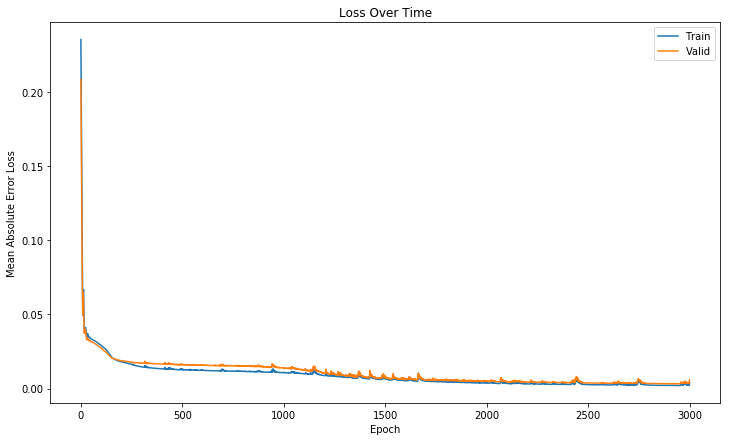

In [229]:
plt.figure(figsize=(12,7))
plt.plot(total_loss)
plt.plot(total_val_loss)

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [234]:
input_seq_test = x_test[5:35].reshape((1,30,1))
output_seq_test = y_test[35:]
decoder_input_test = np.zeros((1,15,1))

In [235]:
pred = model1_bi.predict([input_seq_test,decoder_input_test])

In [236]:
pred_values = scaler.inverse_transform(pred.reshape(15,1))
output_seq_test = scaler.inverse_transform(output_seq_test)

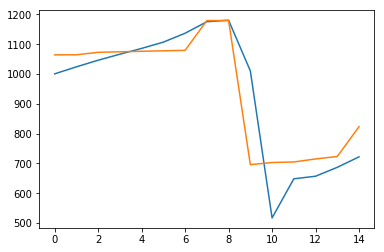

In [237]:
#1,3k
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

In [223]:
#3,1k
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

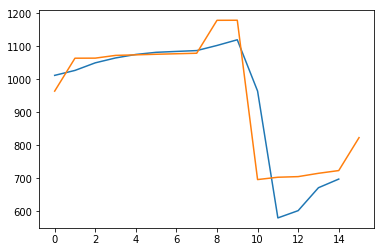

In [212]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

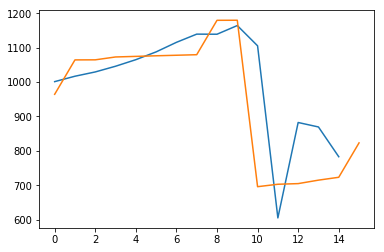

In [53]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

In [161]:
model2_bi = create_model([40,40],2,bidirectional=True)

In [162]:
total_loss = []
total_val_loss = []
model2_bi.compile(Adam(), loss = 'mse')

In [163]:
#bi 2 layered model
start_time = time.time()
run_model(model2_bi,100,64)
end_time = time.time()

Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 11s 213ms/step - loss: 0.2457 - val_loss: 0.2448
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.2169 - val_loss: 0.2151
Epoch 3/100
51/51 [==============================] - 0s 4ms/step - loss: 0.1888 - val_loss: 0.1843
Epoch 4/100
51/51 [==============================] - 0s 4ms/step - loss: 0.1599 - val_loss: 0.1513
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.1163
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0980 - val_loss: 0.0810
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0676 - val_loss: 0.0510
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0449 - val_loss: 0.0397
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0541
Epoch 10/100
51/51 [==============================] - 0s 4ms/s

Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0257
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.0256
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0257
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0259
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0259
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0256
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0253
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0250
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0251
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0253


Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0259
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0259
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0259
Epoch 68/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0259
Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0260
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0260
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0260
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0260
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0259
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0259


Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0259
Epoch 48/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0262
Epoch 49/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0259
Epoch 50/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0265
Epoch 51/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0257
Epoch 52/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0127 - val_loss: 0.0257
Epoch 53/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0256
Epoch 54/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0254
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0260
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0253


Epoch 29/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0142 - val_loss: 0.0208
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0209
Epoch 31/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0210
Epoch 32/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0210
Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0209
Epoch 34/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0208
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0207
Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0206
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0204
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0202


Epoch 11/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0099
Epoch 12/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0102
Epoch 13/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0104
Epoch 14/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0099
Epoch 15/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0094
Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0091
Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0089
Epoch 18/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0091
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0097
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0101


Epoch 93/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 95/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 96/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 97/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 98/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 99/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 100/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0099
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 2/100
51/51 [==============================] - 0s 

Epoch 75/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0108
Epoch 76/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0109
Epoch 77/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0110
Epoch 78/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 79/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0112
Epoch 80/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 81/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0119
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0108
Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0167
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0165


Epoch 57/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0177
Epoch 58/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0177
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0178
Epoch 60/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0178
Epoch 61/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0178
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0178
Epoch 63/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0178
Epoch 64/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0178
Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0178
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0177


Epoch 39/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0255
Epoch 40/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0264
Epoch 41/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0267
Epoch 42/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0253
Epoch 43/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0267
Epoch 44/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0267
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0256
Epoch 46/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0266
Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0260
Epoch 48/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0256


Epoch 21/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0197
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0190
Epoch 23/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0192
Epoch 24/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0195
Epoch 25/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0193
Epoch 26/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0093 - val_loss: 0.0185
Epoch 27/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0177
Epoch 28/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0178
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0184
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0187


Epoch 3/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0159
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0161
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0155
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0160
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0160
Epoch 8/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0155
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0134 - val_loss: 0.0227
Epoch 10/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0267 - val_loss: 0.0258
Epoch 11/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0290
Epoch 12/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0254
Epoch 1

Epoch 85/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0177
Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0177
Epoch 87/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0178
Epoch 88/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0178
Epoch 89/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0179
Epoch 90/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0179
Epoch 91/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0180
Epoch 92/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0181
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0182
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0183


Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0145
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0146
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0145
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0144
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0145
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0144
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0144
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0146
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0146
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0146


Epoch 49/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0299
Epoch 50/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0259
Epoch 51/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0245
Epoch 52/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0231
Epoch 53/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0272
Epoch 54/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0229
Epoch 55/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0234
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0228
Epoch 57/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0257
Epoch 58/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0240


Epoch 31/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0179
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0180
Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0186
Epoch 34/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0187
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0180
Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0175
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0177
Epoch 38/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0178
Epoch 39/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0175
Epoch 40/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0173


Epoch 13/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0207
Epoch 14/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0192
Epoch 15/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0176
Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0179
Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0189
Epoch 18/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0186
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0185
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0183
Epoch 21/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0171
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0166


Epoch 95/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0121
Epoch 96/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0127
Epoch 97/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0122
Epoch 98/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0129
Epoch 99/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0123
Epoch 100/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0130
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0167 - val_loss: 0.0160
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0182 - val_loss: 0.0226
Epoch 4/100
51/51 [==============================] - 0s 3m

Epoch 77/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0163
Epoch 78/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0163
Epoch 79/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0164
Epoch 80/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0163
Epoch 81/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0163
Epoch 82/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0163
Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0162
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0162
Epoch 85/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0162
Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0163


Epoch 59/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0171
Epoch 60/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0171
Epoch 61/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0173
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0173
Epoch 63/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0174
Epoch 64/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0173
Epoch 65/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0176
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0174
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0181
Epoch 68/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0171


Epoch 41/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0365
Epoch 42/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0367
Epoch 43/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0374
Epoch 44/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0375
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0378
Epoch 46/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0383
Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0389
Epoch 48/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0390
Epoch 49/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0395
Epoch 50/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0393


Epoch 23/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0129
Epoch 24/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0130
Epoch 25/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0132
Epoch 26/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0133
Epoch 27/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0133
Epoch 28/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0130
Epoch 29/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0126
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0123
Epoch 31/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0124
Epoch 32/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0126


Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0155 - val_loss: 0.0118
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0143 - val_loss: 0.0104
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0137 - val_loss: 0.0097
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0097
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0134 - val_loss: 0.0105
Epoch 10/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 11/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 12/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0126
Epoch 13/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0120 - val_loss: 0.0123
Epoch 14/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch

Epoch 87/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0133
Epoch 88/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0129
Epoch 89/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0131
Epoch 90/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0130
Epoch 91/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0127
Epoch 92/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0128
Epoch 93/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0128
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0127
Epoch 95/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0128
Epoch 96/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0127


Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0278
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0270
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0274
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0276
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0272
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0283
Epoch 75/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0274
Epoch 76/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0278
Epoch 77/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0279
Epoch 78/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0279


Epoch 51/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0300
Epoch 52/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0303
Epoch 53/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0300
Epoch 54/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0300
Epoch 55/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0306
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0307
Epoch 57/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0306
Epoch 58/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0308
Epoch 59/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0307
Epoch 60/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0307


Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0218
Epoch 34/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0217
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0215
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0210
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0210
Epoch 38/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0220
Epoch 39/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0228
Epoch 40/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0232
Epoch 41/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0231
Epoch 42/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0230


Epoch 15/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0151
Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.0157
Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0142
Epoch 18/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0148
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0150
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0154
Epoch 21/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0160
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0144
Epoch 23/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0159
Epoch 24/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0154


Epoch 97/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0213
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0214
Epoch 99/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0214
Epoch 100/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0215
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.0263
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0217
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.0212
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0128 - val_loss: 0.0208
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0116 - val_loss: 0.0208
Epoch 6/100
51/51 [==============================] - 0s 3ms/

Epoch 79/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0241
Epoch 80/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0231
Epoch 81/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0241
Epoch 82/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0259
Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0231
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0227
Epoch 85/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0244
Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0239
Epoch 87/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0228
Epoch 88/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0234


Epoch 61/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0230
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0184
Epoch 63/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0181
Epoch 64/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0216
Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0199
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0190
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0203
Epoch 68/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0211
Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0201
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0204


Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0246
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0233
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0253
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0226
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0254
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0232
Epoch 49/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0244
Epoch 50/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0245
Epoch 51/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0229
Epoch 52/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0253


Epoch 25/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0083
Epoch 26/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0081
Epoch 27/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0080
Epoch 28/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0082
Epoch 29/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0084
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0085
Epoch 31/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0085
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0087
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0089
Epoch 34/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0089


Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0114
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0110
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 11/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0096
Epoch 12/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0084 - val_loss: 0.0095
Epoch 13/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0095
Epoch 14/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0091
Epoch 15/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0077
Epo

Epoch 89/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0109
Epoch 90/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0109
Epoch 91/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0110
Epoch 92/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0109
Epoch 93/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0113
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0107
Epoch 95/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0103
Epoch 96/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0108
Epoch 97/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0111
Epoch 98/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0109


Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 75/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 76/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 77/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 78/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 79/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 80/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0039


Epoch 53/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 54/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 57/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 58/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 59/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 60/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 61/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0048


Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0113
Epoch 36/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0116
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0115
Epoch 38/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0119
Epoch 39/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0124
Epoch 40/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0121
Epoch 41/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0115
Epoch 42/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0117
Epoch 43/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0119
Epoch 44/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0118


Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0134
Epoch 18/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0132
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0133
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0137
Epoch 21/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0131
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0125
Epoch 23/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0123
Epoch 24/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0124
Epoch 25/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0128
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0129


Epoch 99/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0120
Epoch 100/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0120
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0131
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0147
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0138
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0138
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0137
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0133
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0136
Epoch 8/100
51/51 [==============================] - 0s 3ms/st

Epoch 81/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0149
Epoch 82/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0149
Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0149
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0149
Epoch 85/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0150
Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0150
Epoch 87/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0149
Epoch 88/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0149
Epoch 89/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch 90/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0149


Epoch 63/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0197
Epoch 64/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0197
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0200
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0201
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0204
Epoch 68/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0207
Epoch 69/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0206
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0207
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0207
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0206


Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0092
Epoch 46/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0091
Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0092
Epoch 48/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0094
Epoch 49/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0095
Epoch 50/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0093
Epoch 51/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0093
Epoch 52/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0093
Epoch 53/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0094
Epoch 54/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0093


Epoch 27/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0130
Epoch 28/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0134
Epoch 29/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0135
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0131
Epoch 31/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0126
Epoch 32/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0126
Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0130
Epoch 34/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0133
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0128
Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0122


Epoch 9/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0233
Epoch 10/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0220
Epoch 11/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0229
Epoch 12/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0236
Epoch 13/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0245
Epoch 14/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0256
Epoch 15/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0262
Epoch 16/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0255
Epoch 17/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0236
Epoch 18/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0224
E

Epoch 91/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0259
Epoch 92/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0255
Epoch 93/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0252
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0252
Epoch 95/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0251
Epoch 96/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0250
Epoch 97/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0252
Epoch 98/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0259
Epoch 99/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0267
Epoch 100/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0272

Epoch 73/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0238
Epoch 74/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0239
Epoch 75/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0241
Epoch 76/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0242
Epoch 77/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0243
Epoch 78/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0244
Epoch 79/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0244
Epoch 80/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0245
Epoch 81/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0246
Epoch 82/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0248


Epoch 55/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0100
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0102
Epoch 57/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0104
Epoch 58/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0103
Epoch 59/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0103
Epoch 60/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0103
Epoch 61/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0105
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0106
Epoch 63/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0106
Epoch 64/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0103


Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0164
Epoch 38/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0164
Epoch 39/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0164
Epoch 40/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0164
Epoch 41/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0164
Epoch 42/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0166
Epoch 43/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0168
Epoch 44/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0170
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0170
Epoch 46/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0171


Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0240
Epoch 20/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0229
Epoch 21/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0211
Epoch 22/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0201
Epoch 23/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0203
Epoch 24/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0209
Epoch 25/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0204
Epoch 26/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0195
Epoch 27/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0193
Epoch 28/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0197


Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0199
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0231
Epoch 4/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0281
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0316
Epoch 6/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0329
Epoch 7/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0309
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0253
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0272
Epoch 10/100
51/51 [==============================] - 0s 4ms/step

Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0215
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0218
Epoch 85/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0216
Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0215
Epoch 87/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0219
Epoch 88/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0215
Epoch 89/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0218
Epoch 90/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0215
Epoch 91/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0217
Epoch 92/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0216


Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0189
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0190
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0192
Epoch 68/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0192
Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0193
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0193
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0193
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0194
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0195
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0196


Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0136
Epoch 48/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0135
Epoch 49/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0137
Epoch 50/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0137
Epoch 51/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0138
Epoch 52/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0138
Epoch 53/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0137
Epoch 54/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0137
Epoch 55/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0138
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0138


Epoch 29/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0075
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0072
Epoch 31/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0070
Epoch 32/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0071
Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0075
Epoch 34/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0077
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0078
Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0078
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0078
Epoch 38/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0077


Epoch 11/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0113
Epoch 12/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0116
Epoch 13/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0123
Epoch 14/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0121
Epoch 15/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0119
Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0121
Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0126
Epoch 18/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0127
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0121
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0116


Epoch 93/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0120
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0120
Epoch 95/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0119
Epoch 96/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0119
Epoch 97/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0120
Epoch 98/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0120
Epoch 99/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0120
Epoch 100/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0120
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0188 - val_loss: 0.0229
Epoch 2/100
51/51 [==============================] - 0s 

Epoch 75/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0178
Epoch 76/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0181
Epoch 77/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0177
Epoch 78/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0179
Epoch 79/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0178
Epoch 80/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0175
Epoch 81/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0176
Epoch 82/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0175
Epoch 83/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0174
Epoch 84/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0177


Epoch 57/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0235
Epoch 58/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0236
Epoch 59/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0230
Epoch 60/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0228
Epoch 61/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0236
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0230
Epoch 63/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0242
Epoch 64/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0247
Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0253
Epoch 66/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0256


Epoch 39/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0336
Epoch 40/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0332
Epoch 41/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0337
Epoch 42/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0349
Epoch 43/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0359
Epoch 44/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0360
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0359
Epoch 46/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0363
Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0373
Epoch 48/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0379


Epoch 21/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0107
Epoch 23/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0095
Epoch 24/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0099
Epoch 25/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0106
Epoch 26/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0089
Epoch 27/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0085
Epoch 28/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0088
Epoch 29/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0083
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0082


Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0159
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0146
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0142
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0145
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0144
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0137
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0134
Epoch 10/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0135
Epoch 11/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0136
Epoch 12/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0133
Epoch 1

Epoch 85/100
51/51 [==============================] - 0s 3ms/step - loss: 9.0485e-04 - val_loss: 0.0121
Epoch 86/100
51/51 [==============================] - 0s 4ms/step - loss: 9.0000e-04 - val_loss: 0.0121
Epoch 87/100
51/51 [==============================] - 0s 3ms/step - loss: 8.9538e-04 - val_loss: 0.0121
Epoch 88/100
51/51 [==============================] - 0s 4ms/step - loss: 8.9080e-04 - val_loss: 0.0121
Epoch 89/100
51/51 [==============================] - 0s 3ms/step - loss: 8.8631e-04 - val_loss: 0.0122
Epoch 90/100
51/51 [==============================] - 0s 3ms/step - loss: 8.8193e-04 - val_loss: 0.0122
Epoch 91/100
51/51 [==============================] - 0s 3ms/step - loss: 8.7768e-04 - val_loss: 0.0122
Epoch 92/100
51/51 [==============================] - 0s 4ms/step - loss: 8.7343e-04 - val_loss: 0.0122
Epoch 93/100
51/51 [==============================] - 0s 4ms/step - loss: 8.6937e-04 - val_loss: 0.0122
Epoch 94/100
51/51 [==============================] - 0s 3ms/ste

Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0107
Epoch 67/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0107
Epoch 68/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0106
Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0106
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0107
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0107
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0107
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 9.9390e-04 - val_loss: 0.0108
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 9.8696e-04 - val_loss: 0.0108
Epoch 75/100
51/51 [==============================] - 0s 3ms/step - loss: 9.8020e-04 - val_l

Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0201
Epoch 48/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0201
Epoch 49/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0200
Epoch 50/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0199
Epoch 51/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0200
Epoch 52/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0200
Epoch 53/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0201
Epoch 54/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0201
Epoch 55/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0201
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0200


Epoch 28/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0060
Epoch 29/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0070
Epoch 31/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 32/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 34/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0070
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0057


Epoch 10/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0063
Epoch 11/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 12/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0072
Epoch 13/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 14/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 15/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0076
Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 18/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0079
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0081


Epoch 92/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0082
Epoch 93/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0081
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0082
Epoch 95/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0080
Epoch 96/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0082
Epoch 97/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0082
Epoch 98/100
51/51 [==============================] - 0s 4ms/step - loss: 9.9675e-04 - val_loss: 0.0084
Epoch 99/100
51/51 [==============================] - 0s 4ms/step - loss: 9.9206e-04 - val_loss: 0.0084
Epoch 100/100
51/51 [==============================] - 0s 4ms/step - loss: 9.8097e-04 - val_loss: 0.0082
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [========================

Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 8.2161e-04 - val_loss: 0.0063
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 8.1752e-04 - val_loss: 0.0062
Epoch 75/100
51/51 [==============================] - 0s 3ms/step - loss: 8.1387e-04 - val_loss: 0.0061
Epoch 76/100
51/51 [==============================] - 0s 3ms/step - loss: 8.1004e-04 - val_loss: 0.0062
Epoch 77/100
51/51 [==============================] - 0s 3ms/step - loss: 8.0670e-04 - val_loss: 0.0063
Epoch 78/100
51/51 [==============================] - 0s 3ms/step - loss: 8.0349e-04 - val_loss: 0.0063
Epoch 79/100
51/51 [==============================] - 0s 3ms/step - loss: 8.0052e-04 - val_loss: 0.0062
Epoch 80/100
51/51 [==============================] - 0s 3ms/step - loss: 7.9706e-04 - val_loss: 0.0061
Epoch 81/100
51/51 [==============================] - 0s 3ms/step - loss: 7.9401e-04 - val_loss: 0.0060
Epoch 82/100
51/51 [==============================] - 0s 3ms/ste

Epoch 54/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0074
Epoch 55/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 57/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0068
Epoch 58/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 59/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 60/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0069
Epoch 61/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0069
Epoch 63/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0071


Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0132
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0134
Epoch 38/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0135
Epoch 39/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0134
Epoch 40/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0132
Epoch 41/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0131
Epoch 42/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0130
Epoch 43/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0131
Epoch 44/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0132
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0134


Epoch 16/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0088
Epoch 18/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0100
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0098
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 21/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0059
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 23/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 24/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 25/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0058


51/51 [==============================] - 0s 3ms/step - loss: 7.3692e-04 - val_loss: 0.0052
Epoch 97/100
51/51 [==============================] - 0s 3ms/step - loss: 7.3444e-04 - val_loss: 0.0052
Epoch 98/100
51/51 [==============================] - 0s 3ms/step - loss: 7.3203e-04 - val_loss: 0.0052
Epoch 99/100
51/51 [==============================] - 0s 3ms/step - loss: 7.2976e-04 - val_loss: 0.0052
Epoch 100/100
51/51 [==============================] - 0s 3ms/step - loss: 7.2738e-04 - val_loss: 0.0053
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0139
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0133
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0143
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0135
Epoch 5/100
51/51 [==============================] -

Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 8.8711e-04 - val_loss: 0.0069
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 8.8100e-04 - val_loss: 0.0069
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 8.7521e-04 - val_loss: 0.0069
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 8.6981e-04 - val_loss: 0.0069
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 8.6426e-04 - val_loss: 0.0069
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 8.5914e-04 - val_loss: 0.0069
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 8.5388e-04 - val_loss: 0.0069
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 8.4901e-04 - val_loss: 0.0069
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 8.4400e-04 - val_loss: 0.0069
Epoch 86/100
51/51 [==============================] - 0s 2ms/ste

Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 60/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9800e-04 - val_loss: 0.0025
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8652e-04 - val_loss: 0.0025
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 9.7387e-04 - val_loss: 0.0025
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6212e-04 - val_loss: 0.0025
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 9.5351e-04

51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0068
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0080
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0092
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0090
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0079
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0072
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0069
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0075
Epoch 48/100


Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 20/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0057
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0057
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0056


Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 8.1677e-04 - val_loss: 0.0062
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 8.1445e-04 - val_loss: 0.0062
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0070
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0081
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0087
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0089
Epoch 8/100
51/51 [==============================] - 0

Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0102
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8820e-04 - val_loss: 0.0102
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 9.7325e-04 - val_loss: 0.0102
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 9.5900e-04 - val_loss: 0.0102
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4431e-04 - val_loss: 0.0102
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3010e-04 - val_loss: 0.0102
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 9.1617e-04 - val_loss: 0.0102
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 9.0291e-04 - val_loss: 0.0102
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 8.9036e-04 - val_loss: 0.0102
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - 

Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0102
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0103
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0103
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0101
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9986e-04 - val_loss: 0.0100
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8765e-04 - val_loss: 0.0100
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8015e-04 - val_loss: 0.0100
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6292e-04 - val_loss: 0.0101
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4812e-04 - val_loss: 0.0100
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3486

Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0197
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0200
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0202
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0203
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0204
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0204
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0203
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0201
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0199
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0198


Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0160
Epoch 25/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0163
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0160
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0156
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0159
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0161
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0162
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0164
Epoch 32/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0168
Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0169


Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0044
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch

Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 7.3893e-04 - val_loss: 0.0060
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 7.3388e-04 - val_loss: 0.0060
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 7.2898e-04 - val_loss: 0.0060
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 7.2403e-04 - val_loss: 0.0060
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 7.1941e-04 - val_loss: 0.0060
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 7.1462e-04 - val_loss: 0.0061
Epoch 92/100
51/51 [==============================] - 0s 3ms/step - loss: 7.1004e-04 - val_loss: 0.0061
Epoch 93/100
51/51 [==============================] - 0s 3ms/step - loss: 7.0549e-04 - val_loss: 0.0061
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 7.0105e-04 - val_loss: 0.0061
Epoch 95/100
51/51 [==============================] - 0s 2ms/ste

Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 7.1564e-04 - val_loss: 0.0083
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 7.0928e-04 - val_loss: 0.0083
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 7.0343e-04 - val_loss: 0.0083
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9714e-04 - val_loss: 0.0083
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9165e-04 - val_loss: 0.0083
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 6.8598e-04 - val_loss: 0.0083
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 6.8007e-04 - val_loss: 0.0084
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 6.7494e-04 - val_loss: 0.0084
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 6.6976e-04 - val_loss: 0.0084
Epoch 75/100
51/51 [==============================] - 0s 2ms/ste

Epoch 46/100
51/51 [==============================] - 0s 3ms/step - loss: 6.5467e-04 - val_loss: 0.0058
Epoch 47/100
51/51 [==============================] - 0s 3ms/step - loss: 6.5208e-04 - val_loss: 0.0057
Epoch 48/100
51/51 [==============================] - 0s 3ms/step - loss: 6.4575e-04 - val_loss: 0.0056
Epoch 49/100
51/51 [==============================] - 0s 3ms/step - loss: 6.3992e-04 - val_loss: 0.0055
Epoch 50/100
51/51 [==============================] - 0s 3ms/step - loss: 6.3564e-04 - val_loss: 0.0054
Epoch 51/100
51/51 [==============================] - 0s 3ms/step - loss: 6.3246e-04 - val_loss: 0.0055
Epoch 52/100
51/51 [==============================] - 0s 3ms/step - loss: 6.2804e-04 - val_loss: 0.0057
Epoch 53/100
51/51 [==============================] - 0s 3ms/step - loss: 6.2423e-04 - val_loss: 0.0057
Epoch 54/100
51/51 [==============================] - 0s 4ms/step - loss: 6.2074e-04 - val_loss: 0.0056
Epoch 55/100
51/51 [==============================] - 0s 2ms/ste

Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6422e-04 - val_loss: 0.0042
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6353e-04 - val_loss: 0.0042
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4316e-04 - val_loss: 0.0042
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 9.0382e-04 - val_loss: 0.0043
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 8.7293e-04 - val_loss: 0.0044
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 8.5740e-04 - val_loss: 0.0044
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 8.

Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0139
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0178
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0171
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0160
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0142
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0151
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0167
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0163
Epoch 13/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0154
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0130
Epoch

Epoch 86/100
51/51 [==============================] - 0s 3ms/step - loss: 7.0282e-04 - val_loss: 0.0108
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 7.0072e-04 - val_loss: 0.0108
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9858e-04 - val_loss: 0.0109
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9662e-04 - val_loss: 0.0108
Epoch 90/100
51/51 [==============================] - 0s 3ms/step - loss: 6.9457e-04 - val_loss: 0.0108
Epoch 91/100
51/51 [==============================] - 0s 3ms/step - loss: 6.9260e-04 - val_loss: 0.0108
Epoch 92/100
51/51 [==============================] - 0s 3ms/step - loss: 6.9090e-04 - val_loss: 0.0108
Epoch 93/100
51/51 [==============================] - 0s 3ms/step - loss: 6.8880e-04 - val_loss: 0.0108
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 6.8715e-04 - val_loss: 0.0108
Epoch 95/100
51/51 [==============================] - 0s 5ms/ste

Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 8.7345e-04 - val_loss: 0.0107
Epoch 68/100
51/51 [==============================] - 0s 3ms/step - loss: 8.6168e-04 - val_loss: 0.0107
Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 8.5849e-04 - val_loss: 0.0107
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 8.4558e-04 - val_loss: 0.0108
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 8.3960e-04 - val_loss: 0.0108
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 8.3273e-04 - val_loss: 0.0108
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 8.2663e-04 - val_loss: 0.0108
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 8.1852e-04 - val_loss: 0.0109
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 8.1227e-04 - val_loss: 0.0110
Epoch 76/100
51/51 [==============================] - 0s 3ms/ste

Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0140
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0133
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0138
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0153
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6157e-04 - val_loss: 0.0143
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0137
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0140
Epoch 55/100
51/51 [==============================] - 0s 3ms/step - loss: 9.6706e-04 - val_loss: 0.0142
Epoch 56/100
51/51 [==============================] - 0s 3ms/step - loss: 9.6010e-04 - val_loss: 0.0138
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 9.1802e-04 - v

Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0093
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0093
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0095
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0097
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0093
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0092
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0093
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0095


51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0091
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0095
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0093
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0088
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0091
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0087
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0082
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0081
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0087
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0088
Epoch 17/100
51

Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9270e-04 - val_loss: 0.0092
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9088e-04 - val_loss: 0.0092
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 6.8911e-04 - val_loss: 0.0092
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 6.8733e-04 - val_loss: 0.0092
Epoch 91/100
51/51 [==============================] - 0s 3ms/step - loss: 6.8563e-04 - val_loss: 0.0092
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 6.8401e-04 - val_loss: 0.0092
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 6.8229e-04 - val_loss: 0.0092
Epoch 94/100
51/51 [==============================] - 0s 3ms/step - loss: 6.8067e-04 - val_loss: 0.0092
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 6.7906e-04 - val_loss: 0.0092
Epoch 96/100
51/51 [==============================] - 0s 2ms/ste

Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 8.8234e-04 - val_loss: 0.0055
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 8.7631e-04 - val_loss: 0.0055
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 8.7032e-04 - val_loss: 0.0055
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 8.6410e-04 - val_loss: 0.0055
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 8.5822e-04 - val_loss: 0.0055
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 8.5244e-04 - val_loss: 0.0055
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 8.4726e-04 - val_loss: 0.0055
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 8.4203e-04 - val_loss: 0.0055
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 8.3641e-04 - val_loss: 0.0055
Epoch 77/100
51/51 [==============================] - 0s 2ms/ste

Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 7.1144e-04 - val_loss: 0.0055
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 7.0340e-04 - val_loss: 0.0055
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9911e-04 - val_loss: 0.0055
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9298e-04 - val_loss: 0.0055
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 6.8773e-04 - val_loss: 0.0055
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 6.8444e-04 - val_loss: 0.0055
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 6.7780e-04 - val_loss: 0.0055
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 6.7418e-04 - val_loss: 0.0055
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 6.6851e-04 - val_loss: 0.0055
Epoch 57/100
51/51 [==============================] - 0s 2ms/ste

Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0118
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0121
Epoch 30/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0123
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0127
Epoch 32/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0131
Epoch 33/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0129
Epoch 34/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0122
Epoch 35/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0116
Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0111
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0111


51/51 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0086
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0071
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0072
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0093
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0091
Epoch 17/100
51

Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 5.6232e-04 - val_loss: 0.0071
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 5.6107e-04 - val_loss: 0.0071
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 5.5996e-04 - val_loss: 0.0072
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 5.5883e-04 - val_loss: 0.0072
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 5.5781e-04 - val_loss: 0.0072
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 5.5664e-04 - val_loss: 0.0071
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 5.5551e-04 - val_loss: 0.0071
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 5.5443e-04 - val_loss: 0.0072
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 5.5338e-04 - val_loss: 0.0072
Epoch 96/100
51/51 [==============================] - 0s 2ms/ste

Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 7.3825e-04 - val_loss: 0.0071
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 7.3334e-04 - val_loss: 0.0071
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 7.2749e-04 - val_loss: 0.0070
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 7.2313e-04 - val_loss: 0.0070
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 7.1779e-04 - val_loss: 0.0070
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 7.1361e-04 - val_loss: 0.0070
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 7.0958e-04 - val_loss: 0.0070
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 7.0438e-04 - val_loss: 0.0070
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 7.0070e-04 - val_loss: 0.0070
Epoch 76/100
51/51 [==============================] - 0s 2ms/ste

Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 6.6233e-04 - val_loss: 0.0107
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 6.5677e-04 - val_loss: 0.0109
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 6.5074e-04 - val_loss: 0.0111
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 6.4668e-04 - val_loss: 0.0114
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 6.4086e-04 - val_loss: 0.0117
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 6.3776e-04 - val_loss: 0.0118
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 6.3390e-04 - val_loss: 0.0118
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 6.2722e-04 - val_loss: 0.0116
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 6.2333e-04 - val_loss: 0.0115
Epoch 56/100
51/51 [==============================] - 0s 2ms/ste

Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0044


Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0127
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0141
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0142
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0138
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0131
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0120
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0105
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0095
Epoch 17/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0089
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0091
E

Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0083
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0083
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084

51/51 [==============================] - 0s 2ms/step - loss: 9.2710e-04 - val_loss: 0.0028
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 9.2359e-04 - val_loss: 0.0028
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 9.2005e-04 - val_loss: 0.0028
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 9.1625e-04 - val_loss: 0.0028
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 9.1258e-04 - val_loss: 0.0028
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 9.0920e-04 - val_loss: 0.0028
Epoch 78/100
51/51 [==============================] - 0s 2ms/step - loss: 9.0571e-04 - val_loss: 0.0028
Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 9.0222e-04 - val_loss: 0.0028
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 8.9892e-04 - val_loss: 0.0028
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 8.9

Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0070
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0071
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0071
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0072
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0070
Epoch 60/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0060


Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 40/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0071
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0073
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0074
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0075


51/51 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0086
Epoch 16/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 17/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0092
Epoch 18/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0095
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0086
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 21/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0086
Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0099
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0101
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0096
Epoch 25/100


51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 98/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0092
Epoch 99/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 100/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0094
Train on 51 samples, validate on 13 samples
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0061
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0074
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0081
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 

Epoch 79/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 80/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 81/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 82/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 83/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 84/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 87/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0101


Epoch 61/100
51/51 [==============================] - 0s 2ms/step - loss: 9.5323e-04 - val_loss: 0.0130
Epoch 62/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4098e-04 - val_loss: 0.0129
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3256e-04 - val_loss: 0.0129
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 9.2678e-04 - val_loss: 0.0130
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 9.1338e-04 - val_loss: 0.0130
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 9.1022e-04 - val_loss: 0.0129
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 8.9966e-04 - val_loss: 0.0129
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 8.9722e-04 - val_loss: 0.0129
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 8.8927e-04 - val_loss: 0.0131
Epoch 70/100
51/51 [==============================] - 0s 2ms/ste

Epoch 41/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 42/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0098
Epoch 43/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0096
Epoch 44/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 45/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0094
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0098
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0098
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0097


Epoch 22/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 23/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 24/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 25/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 26/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0033


Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0064
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0070
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0072
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0079
Epoch 12

51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0076
Epoch 85/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9635e-04 - val_loss: 0.0076
Epoch 86/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9875e-04 - val_loss: 0.0076
Epoch 87/100
51/51 [==============================] - 0s 3ms/step - loss: 9.8678e-04 - val_loss: 0.0076
Epoch 88/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8757e-04 - val_loss: 0.0076
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 9.7761e-04 - val_loss: 0.0076
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 9.7772e-04 - val_loss: 0.0076
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6837e-04 - val_loss: 0.0076
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6686e-04 - val_loss: 0.0076
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6130e

Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6577e-04 - val_loss: 0.0060
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 9.5425e-04 - val_loss: 0.0060
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4426e-04 - val_loss: 0.0060
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3455e-04 - val_loss: 0.0060
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 9.2526e-04 - val_loss: 0.0060
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 9.1589e-04 - val_loss: 0.0060
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 9.0690e-04 - val_loss: 0.0060
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 8.9897e-04 - val_loss: 0.0060
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 8.9117e-04 - val_loss: 0.0060
Epoch 74/100
51/51 [==============================] - 0s 2ms/ste

51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0113
Epoch 46/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0113
Epoch 47/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0112
Epoch 48/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0111
Epoch 49/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0112
Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0113
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0114
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0114
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0115
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0115
Epoch 55/100


Epoch 27/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0106
Epoch 28/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0115
Epoch 29/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0112
Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0106
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0101
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0106
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0105
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0104
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0104
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0106


51/51 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0192
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0205
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0221
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0207
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0200
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0204
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0203
Epoch 13/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0206
Epoch 14/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0204
Epoch 15/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0200
Epoch 16/100
51/

51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0209
Epoch 89/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0208
Epoch 90/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9895e-04 - val_loss: 0.0207
Epoch 91/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9245e-04 - val_loss: 0.0207
Epoch 92/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8338e-04 - val_loss: 0.0207
Epoch 93/100
51/51 [==============================] - 0s 2ms/step - loss: 9.7478e-04 - val_loss: 0.0206
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6845e-04 - val_loss: 0.0206
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 9.6039e-04 - val_loss: 0.0206
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 9.5217e-04 - val_loss: 0.0205
Epoch 97/100
51/51 [==============================] - 0s 2ms/step - loss: 9.4566e-04 

Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 7.7805e-04 - val_loss: 0.0021
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 7.9997e-04 - val_loss: 0.0020
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 7.9462e-04 - val_loss: 0.0019
Epoch 72/100
51/51 [==============================] - 0s 2ms/step - loss: 7.3117e-04 - val_loss: 0.0018
Epoch 73/100
51/51 [==============================] - 0s 2ms/step - loss: 7.8277e-04 - val_loss: 0.0019
Epoch 74/100
51/51 [==============================] - 0s 2ms/step - loss: 7.1463e-04 - val_loss: 0.0019
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 7.3363e-04 - val_loss: 0.0020
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9154e-04 - val_loss: 0.0020
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 6.9241e-04 - val_loss: 0.0019
Epoch 78/100
51/51 [==============================] - 0s 2ms/ste

Epoch 50/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 51/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 52/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 53/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 54/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 55/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 57/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9567e-04 - val_loss: 0.0029
Epoch 59/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8780e-04 - val_loss:

Epoch 30/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0153
Epoch 31/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0151
Epoch 32/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0148
Epoch 33/100
51/51 [==============================] - 0s 2ms/step - loss: 9.9690e-04 - val_loss: 0.0145
Epoch 34/100
51/51 [==============================] - 0s 2ms/step - loss: 9.8049e-04 - val_loss: 0.0143
Epoch 35/100
51/51 [==============================] - 0s 2ms/step - loss: 9.3039e-04 - val_loss: 0.0146
Epoch 36/100
51/51 [==============================] - 0s 2ms/step - loss: 9.0096e-04 - val_loss: 0.0147
Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 8.9645e-04 - val_loss: 0.0146
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 8.6153e-04 - val_loss: 0.0145
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 8.

In [164]:
run_time = (end_time - start_time)/60
run_time

23.801937667528787

In [165]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

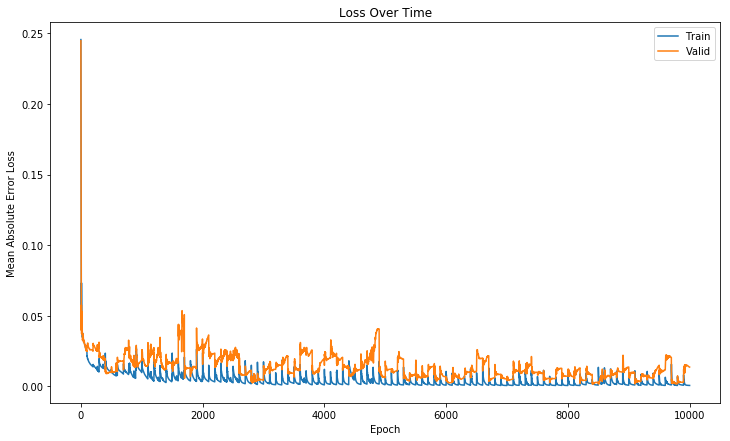

In [166]:
plt.figure(figsize=(12,7))
plt.plot(total_loss)
plt.plot(total_val_loss)

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [175]:
input_seq_test = x_test[1:31].reshape((1,30,1))
output_seq_test = y_test[31:]
decoder_input_test = np.zeros((1,15,1))

In [176]:
pred = model2_bi.predict([input_seq_test,decoder_input_test])

In [177]:
pred_values = scaler.inverse_transform(pred.reshape(15,1))
output_seq_test = scaler.inverse_transform(output_seq_test)

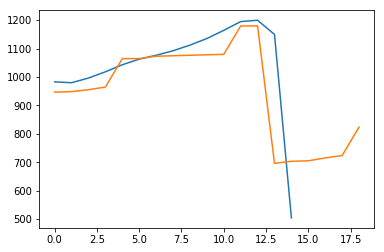

In [178]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

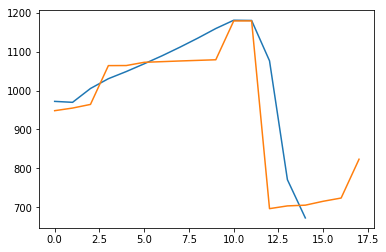

In [123]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

In [89]:
model3_bi = create_model([40,40],2,bidirectional=True)

In [90]:
total_loss = []
total_val_loss = []
model3_bi.compile(Adam(), loss = 'mse')

In [91]:
import time

In [92]:
#bi 2 layered model
start_time = time.time()
run_model(model3_bi,20,full_batch)
end_time = time.time()

Train on 369 samples, validate on 93 samples
Epoch 1/100
369/369 [==============================] - 14s 37ms/step - loss: 0.2450 - val_loss: 0.2407
Epoch 2/100
369/369 [==============================] - 1s 2ms/step - loss: 0.2187 - val_loss: 0.2038
Epoch 3/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1845 - val_loss: 0.1670
Epoch 4/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1507 - val_loss: 0.1298
Epoch 5/100
369/369 [==============================] - 1s 2ms/step - loss: 0.1165 - val_loss: 0.0929
Epoch 6/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0828 - val_loss: 0.0601
Epoch 7/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0534 - val_loss: 0.0410
Epoch 8/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0374 - val_loss: 0.0508
Epoch 9/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0494 - val_loss: 0.0714
Epoch 10/100
369/369 [======================

Epoch 81/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0272 - val_loss: 0.0335
Epoch 82/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0333
Epoch 83/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0332
Epoch 84/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0331
Epoch 85/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0329
Epoch 86/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0328
Epoch 87/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0264 - val_loss: 0.0326
Epoch 88/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0325
Epoch 89/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0260 - val_loss: 0.0323
Epoch 90/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0259

Epoch 61/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0193
Epoch 62/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0192
Epoch 63/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0192
Epoch 64/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0192
Epoch 65/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0191
Epoch 66/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0185 - val_loss: 0.0191
Epoch 67/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0184 - val_loss: 0.0190
Epoch 68/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0190
Epoch 69/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0190
Epoch 70/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0184

Epoch 41/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0175
Epoch 42/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0175
Epoch 43/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0176
Epoch 44/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0175
Epoch 45/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0176
Epoch 46/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0162 - val_loss: 0.0175
Epoch 47/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0174
Epoch 48/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0175
Epoch 49/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0174
Epoch 50/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0160

Epoch 21/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0150 - val_loss: 0.0183
Epoch 22/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0185
Epoch 23/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0175
Epoch 24/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0179
Epoch 25/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0185
Epoch 26/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0176
Epoch 27/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0179
Epoch 28/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0180
Epoch 29/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0181
Epoch 30/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0143

369/369 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0147
Epoch 2/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 3/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0148
Epoch 4/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 5/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0147
Epoch 6/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0147
Epoch 7/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 8/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 9/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 10/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0148
E

Epoch 82/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0143
Epoch 83/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0144
Epoch 84/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0142
Epoch 85/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0144
Epoch 86/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0143
Epoch 87/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0147
Epoch 88/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0145
Epoch 89/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0146
Epoch 90/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0141
Epoch 91/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0119

Epoch 62/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 63/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0129
Epoch 64/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 65/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0117 - val_loss: 0.0120
Epoch 66/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0126
Epoch 67/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0120 - val_loss: 0.0123
Epoch 68/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0126
Epoch 69/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0122
Epoch 70/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0119
Epoch 71/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0112

Epoch 42/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0120
Epoch 43/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 44/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 45/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 46/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0121
Epoch 47/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0124
Epoch 48/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0123
Epoch 49/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0119
Epoch 50/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 51/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0110

Epoch 22/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 23/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 24/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 25/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 26/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 27/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 28/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 29/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 30/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 31/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0087

Epoch 2/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0091
Epoch 3/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 4/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 5/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0092
Epoch 6/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 7/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 8/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 9/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0088
Epoch 10/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 11/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0076 - val_l

Epoch 83/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 84/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0104
Epoch 85/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0109
Epoch 86/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0105
Epoch 87/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0118
Epoch 88/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0101
Epoch 89/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0092
Epoch 90/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0079 - val_loss: 0.0115
Epoch 91/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0097
Epoch 92/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0073

Epoch 63/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0091
Epoch 64/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0082
Epoch 65/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0085
Epoch 66/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 67/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0083
Epoch 68/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 69/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0089
Epoch 70/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 71/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0081
Epoch 72/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0064

Epoch 43/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 44/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 45/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0074
Epoch 46/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0059
Epoch 47/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 48/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 49/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0057
Epoch 50/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 51/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 52/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0073

Epoch 23/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0079
Epoch 24/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0077
Epoch 25/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0074
Epoch 26/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0084
Epoch 27/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0053 - val_loss: 0.0079
Epoch 28/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0087
Epoch 29/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 30/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0090
Epoch 31/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 32/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0052

Epoch 3/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 4/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 5/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 6/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 7/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 8/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 9/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 10/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 11/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 12/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0048 - val_

Epoch 84/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 85/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 86/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 87/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 88/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 89/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 90/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 91/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 92/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 93/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0041

Epoch 64/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 65/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 66/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 67/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 68/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 69/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 70/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 71/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 72/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 73/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0038

Epoch 44/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 45/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 46/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 47/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 48/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 49/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 50/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 51/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 52/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 53/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0036

Epoch 24/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 25/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 26/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 27/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 28/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 29/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 30/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 31/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 32/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 33/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0029

Epoch 4/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 5/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 6/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 7/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 8/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 9/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 10/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 11/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 12/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 13/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0033 - val

Epoch 85/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 86/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 87/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 88/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 89/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 90/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 91/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 92/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 93/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 94/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0022

Epoch 65/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 66/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 67/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 68/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 69/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 70/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 71/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 72/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 73/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 74/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020

Epoch 45/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 46/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 47/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 48/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 49/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 50/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 51/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 52/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 53/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 54/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0020

Epoch 25/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 26/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 27/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 28/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 29/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 30/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 31/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 32/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 33/100
369/369 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 34/100
369/369 [==============================] - 1s 3ms/step - loss: 0.0025

In [93]:
run_time = (end_time - start_time)/60
run_time

32.39260759751002

In [94]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

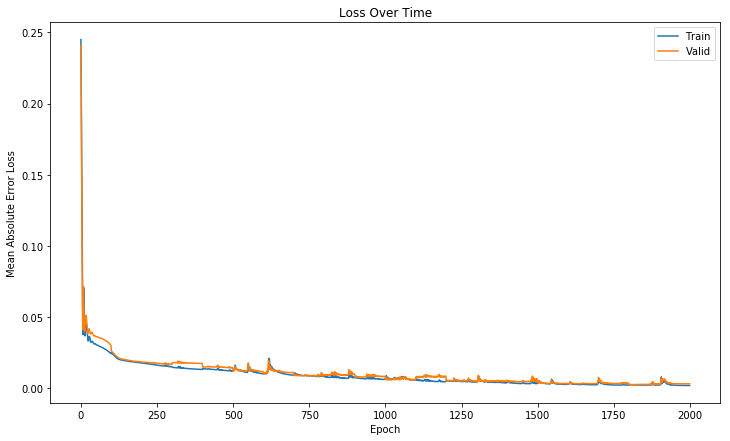

In [95]:
plt.figure(figsize=(12,7))
plt.plot(total_loss)
plt.plot(total_val_loss)

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [197]:
input_seq_test = x_test[2:32].reshape((1,30,1))
output_seq_test = y_test[32:]
decoder_input_test = np.zeros((1,15,1))

In [198]:
pred = model3_bi.predict([input_seq_test,decoder_input_test])

In [199]:
pred_values = scaler.inverse_transform(pred.reshape(15,1))
output_seq_test = scaler.inverse_transform(output_seq_test)

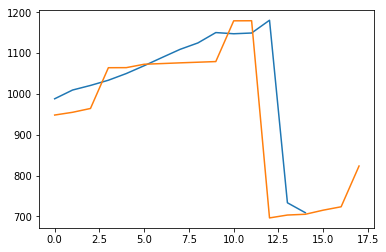

In [200]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")

In [63]:
#Teacher Forcing

'''
encoder_inputs = Input(shape=(None, n_in_features))
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
#encoder_states1 = [state_h1, state_c1]
#encoder = Dropout(0.5)(encoder)
encoder_outputs, state_h2, state_c2 = LSTM(latent_dim, return_state=True)(encoder_outputs1)
# We discard `encoder_outputs` and only keep the states.
encoder_states2 = [state_h2, state_c2]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, n_out_features))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states2)
#do1 = Dropout(.5)(decoder_outputs1)
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1, initial_state=encoder_states2)#, intial_state=[h1,c1])
#do2 = Dropout(.5)(decoder_outputs2)
decoder_dense = Dense(n_out_features, activation='linear')
decoder_output = decoder_dense(decoder_outputs2)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_output)

model.summary()

'''

"\nencoder_inputs = Input(shape=(None, n_in_features))\nencoder_lstm1 = LSTM(latent_dim, return_sequences=True,return_state=True)\nencoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)\n#encoder_states1 = [state_h1, state_c1]\n#encoder = Dropout(0.5)(encoder)\nencoder_outputs, state_h2, state_c2 = LSTM(latent_dim, return_state=True)(encoder_outputs1)\n# We discard `encoder_outputs` and only keep the states.\nencoder_states2 = [state_h2, state_c2]\n\n# Set up the decoder, using `encoder_states` as initial state.\ndecoder_inputs = Input(shape=(None, n_out_features))\n# We set up our decoder to return full output sequences,\n# and to return internal states as well. We don't use the \n# return states in the training model, but we will use them in inference.\ndecoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)\ndecoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states2)\n#do1 = Dropout(.5)(decoder_outputs1)\ndecoder_lstm2 = LST

In [64]:
'''
#encoder_states = encoder_states1 + encoder_states2
encoder_model = Model(encoder_inputs, encoder_states2)


decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs1,_ ,_ = decoder_lstm1(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs2, output_h, ouput_c = decoder_lstm2(
    decoder_outputs1, initial_state=decoder_states_inputs)

decoder_states = [output_h, ouput_c]
decoder_outputs3 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs3] + decoder_states)
    
'''

'\n#encoder_states = encoder_states1 + encoder_states2\nencoder_model = Model(encoder_inputs, encoder_states2)\n\n\ndecoder_state_input_h = Input(shape=(latent_dim,))\ndecoder_state_input_c = Input(shape=(latent_dim,))\ndecoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]\n\ndecoder_outputs1,_ ,_ = decoder_lstm1(\n    decoder_inputs, initial_state=decoder_states_inputs)\n\ndecoder_outputs2, output_h, ouput_c = decoder_lstm2(\n    decoder_outputs1, initial_state=decoder_states_inputs)\n\ndecoder_states = [output_h, ouput_c]\ndecoder_outputs3 = decoder_dense(decoder_outputs2)\ndecoder_model = Model(\n    [decoder_inputs] + decoder_states_inputs,\n    [decoder_outputs3] + decoder_states)\n    \n'

In [65]:
'''

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,output_seq_len,1))
    
    for i in range(output_seq_len):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq
    
'''

'\n\ndef decode_sequence(input_seq):\n    \n    # Encode the input as state vectors.\n    states_value = encoder_model.predict(input_seq)\n\n    # Generate empty target sequence of length 1.\n    target_seq = np.zeros((1, 1, 1))\n    \n    # Populate the first target sequence with end of encoding series pageviews\n    target_seq[0, 0, 0] = input_seq[0, -1, 0]\n\n    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions\n    # (to simplify, here we assume a batch of size 1).\n\n    decoded_seq = np.zeros((1,output_seq_len,1))\n    \n    for i in range(output_seq_len):\n        \n        output, h, c = decoder_model.predict([target_seq] + states_value)\n        \n        decoded_seq[0,i,0] = output[0,0,0]\n\n        # Update the target sequence (of length 1).\n        target_seq = np.zeros((1, 1, 1))\n        target_seq[0, 0, 0] = output[0,0,0]\n\n        # Update states\n        states_value = [h, c]\n\n    return decoded_seq\n    \n'